In [1]:
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import ast 

In [2]:
run_mode='scene'

data=pd.read_csv("/Users/vayungoel/Desktop/passt/final_hear21_embeddings_finetuned_def_model_train_all_blocks.csv")
test_data=pd.read_csv("/Users/vayungoel/Desktop/passt/final_hear21_embeddings_finetuned_def_model_test_all_blocks.csv")
df=pd.DataFrame()
df['file_name']=test_data['file_name']
df.head()

acc_list=[]
loss_list=[]

Device_Initialization

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

String to List of list conversion for embeddings

In [4]:
def train_ready(data,col_name):
    new_list=[]
    for i in range(len(data)):
        temp_list=[]
        x=data[col_name][i]
        tensor_string = x

# Extract the numbers part of the string
        numbers_string = tensor_string.split("[[")[1].split("]]")[0]

# Parse the string into a Python list
        tensor_list = ast.literal_eval("[" + numbers_string + "]")

# Convert the list to a numpy array
        numpy_array = np.array(tensor_list)
        list_data=list(numpy_array)
        
        new_list.append(list_data)
    return new_list

**Function for plotting class distribution**

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def class_distribution(data_list,kk='train'):
    # Get the unique classes
    unique_classes = list(set(data_list))
    
    # Create a dictionary to store the class counts
    class_counts = {cls: 0 for cls in unique_classes}
    
    # Count the occurrences of each class
    for item in data_list:
        class_counts[item] += 1
    
    # Convert the counts to a sorted list of tuples
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Print the per-class distribution
    print(f"Per-class distribution for {kk} data:")
    for cls, count in sorted_counts:
        print(f"{cls}: {count}")
    
    # Plot the histogram
    classes = [cls for cls, _ in sorted_counts]
    counts = [count for _, count in sorted_counts]
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution Histogram")
    plt.xticks(rotation=90)
    plt.show()
    
    return class_counts

In [6]:
number_of_classes=len(list(np.unique(np.array(data[run_mode]))))
number_of_classes

10

**MODEL DEFINITION**

In [7]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

One-Hot encoding the labels 

Train

In [8]:
y=data[run_mode].tolist()
print(y)
label_array_train = np.array(y).reshape(-1, 1)
encoder=OneHotEncoder()
y_one_hot_encoded = encoder.fit_transform(label_array_train).toarray()
# print(len(y_one_hot_encoded))
y_one_hot_encoded

['airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport', 'airport'

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
y_test=test_data[run_mode].tolist()
label_array_test=np.array(y_test).reshape(-1,1)
encoder=OneHotEncoder()
y_test_one_hot_encoded = encoder.fit_transform(label_array_test).toarray()
y_test_one_hot_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
class_names = list(np.unique(y_test))

Test

2968
Per-class distribution for test data:
street_pedestrian: 297
metro: 297
park: 297
shopping_mall: 297
bus: 297
public_square: 297
metro_station: 297
street_traffic: 297
tram: 296
airport: 296


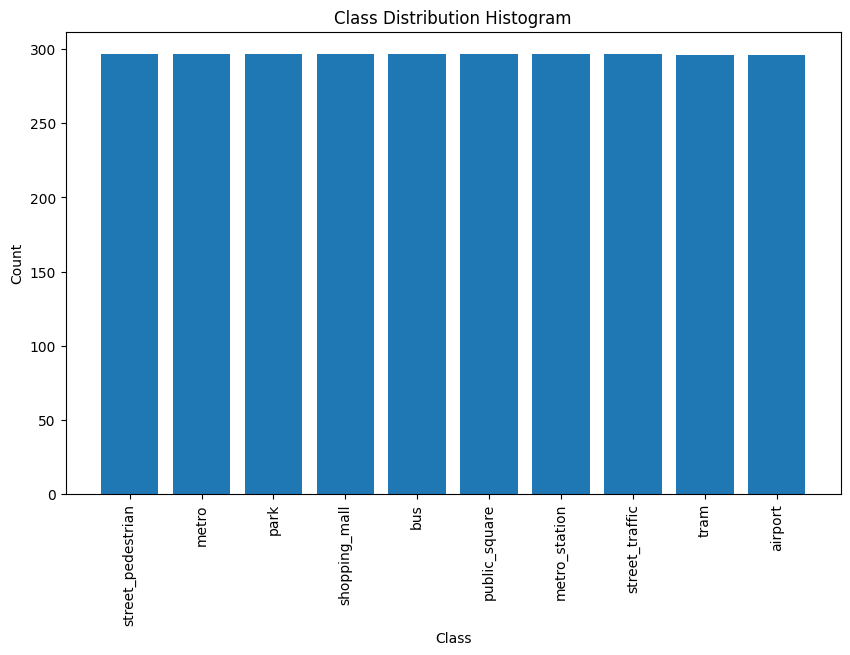

{'street_pedestrian': 297,
 'metro': 297,
 'park': 297,
 'tram': 296,
 'shopping_mall': 297,
 'airport': 296,
 'bus': 297,
 'public_square': 297,
 'metro_station': 297,
 'street_traffic': 297}

In [11]:
reverse=encoder.inverse_transform(y_test_one_hot_encoded)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst,kk='test')

# BLOCK-1

**TRAIN**

In [12]:
Block_number=1


In [13]:
# print(f'embedding{Block_number}')
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [15]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


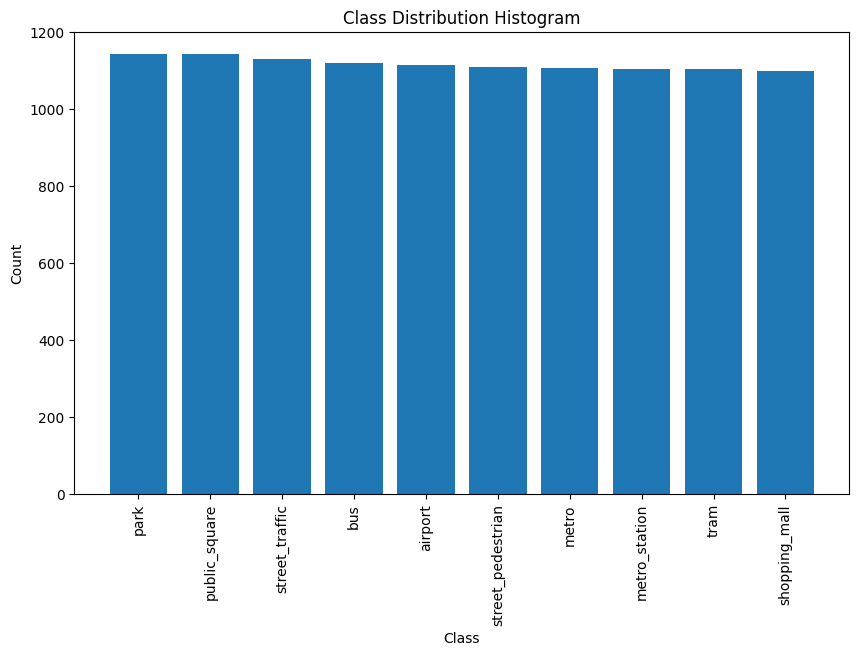

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [16]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


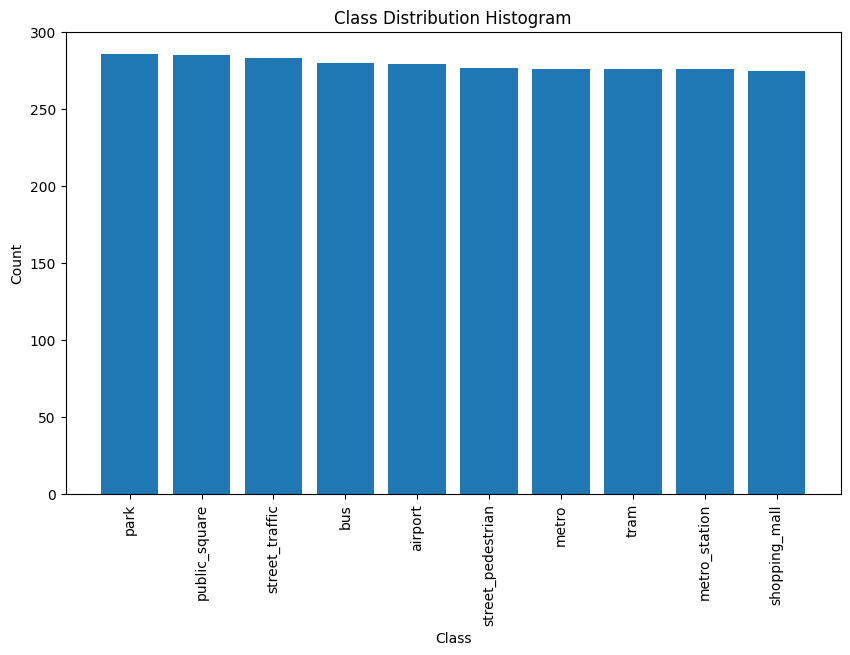

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [17]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [18]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [19]:
X_train_tensor.shape

torch.Size([11169, 768])

In [20]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 418.82batch/s, acc=0.156, loss=2.27] 


Epoch 0 validation: Cross-entropy=2.26, Accuracy=17.3%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 382.37batch/s, acc=0.156, loss=2.23] 


Epoch 1 validation: Cross-entropy=2.22, Accuracy=17.8%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 423.95batch/s, acc=0.172, loss=2.19] 


Epoch 2 validation: Cross-entropy=2.19, Accuracy=18.5%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 431.70batch/s, acc=0.188, loss=2.16] 


Epoch 3 validation: Cross-entropy=2.17, Accuracy=19.0%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 388.10batch/s, acc=0.219, loss=2.14] 


Epoch 4 validation: Cross-entropy=2.15, Accuracy=19.4%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 377.28batch/s, acc=0.219, loss=2.12] 


Epoch 5 validation: Cross-entropy=2.14, Accuracy=19.5%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 362.70batch/s, acc=0.234, loss=2.11] 


Epoch 6 validation: Cross-entropy=2.13, Accuracy=19.9%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 345.05batch/s, acc=0.25, loss=2.09]  


Epoch 7 validation: Cross-entropy=2.13, Accuracy=20.2%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 335.80batch/s, acc=0.266, loss=2.08] 


Epoch 8 validation: Cross-entropy=2.12, Accuracy=20.8%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 341.22batch/s, acc=0.266, loss=2.07] 


Epoch 9 validation: Cross-entropy=2.11, Accuracy=20.9%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 318.31batch/s, acc=0.266, loss=2.06] 


Epoch 10 validation: Cross-entropy=2.11, Accuracy=21.4%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 347.61batch/s, acc=0.281, loss=2.05]


Epoch 11 validation: Cross-entropy=2.10, Accuracy=21.6%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 345.40batch/s, acc=0.266, loss=2.04] 


Epoch 12 validation: Cross-entropy=2.10, Accuracy=21.7%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 447.99batch/s, acc=0.297, loss=2.03]


Epoch 13 validation: Cross-entropy=2.09, Accuracy=21.5%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 425.24batch/s, acc=0.297, loss=2.03]


Epoch 14 validation: Cross-entropy=2.09, Accuracy=21.8%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 422.03batch/s, acc=0.312, loss=2.02] 


Epoch 15 validation: Cross-entropy=2.09, Accuracy=22.0%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 415.54batch/s, acc=0.312, loss=2.02] 


Epoch 16 validation: Cross-entropy=2.09, Accuracy=22.3%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 481.79batch/s, acc=0.312, loss=2.01]


Epoch 17 validation: Cross-entropy=2.08, Accuracy=22.3%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 339.34batch/s, acc=0.312, loss=2.01]


Epoch 18 validation: Cross-entropy=2.08, Accuracy=22.6%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 407.88batch/s, acc=0.312, loss=2]   


Epoch 19 validation: Cross-entropy=2.08, Accuracy=22.6%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 477.67batch/s, acc=0.312, loss=2]   


Epoch 20 validation: Cross-entropy=2.08, Accuracy=22.6%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 401.35batch/s, acc=0.328, loss=2]    


Epoch 21 validation: Cross-entropy=2.07, Accuracy=22.6%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 393.32batch/s, acc=0.328, loss=2]    


Epoch 22 validation: Cross-entropy=2.07, Accuracy=22.8%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 357.13batch/s, acc=0.297, loss=1.99] 


Epoch 23 validation: Cross-entropy=2.07, Accuracy=23.0%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 460.71batch/s, acc=0.344, loss=1.99] 


Epoch 24 validation: Cross-entropy=2.07, Accuracy=22.8%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 438.06batch/s, acc=0.312, loss=1.99] 


Epoch 25 validation: Cross-entropy=2.07, Accuracy=23.2%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 429.55batch/s, acc=0.312, loss=1.98] 


Epoch 26 validation: Cross-entropy=2.06, Accuracy=23.0%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 450.87batch/s, acc=0.312, loss=1.98] 


Epoch 27 validation: Cross-entropy=2.06, Accuracy=23.1%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 380.31batch/s, acc=0.312, loss=1.98] 


Epoch 28 validation: Cross-entropy=2.06, Accuracy=23.8%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 320.70batch/s, acc=0.312, loss=1.98] 


Epoch 29 validation: Cross-entropy=2.06, Accuracy=23.8%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 344.94batch/s, acc=0.297, loss=1.98] 


Epoch 30 validation: Cross-entropy=2.06, Accuracy=24.0%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 322.31batch/s, acc=0.328, loss=1.97] 


Epoch 31 validation: Cross-entropy=2.05, Accuracy=24.1%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 375.22batch/s, acc=0.328, loss=1.97] 


Epoch 32 validation: Cross-entropy=2.05, Accuracy=24.5%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 348.17batch/s, acc=0.312, loss=1.97]


Epoch 33 validation: Cross-entropy=2.05, Accuracy=24.7%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 370.73batch/s, acc=0.312, loss=1.97]


Epoch 34 validation: Cross-entropy=2.05, Accuracy=24.7%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 324.72batch/s, acc=0.312, loss=1.97]


Epoch 35 validation: Cross-entropy=2.05, Accuracy=24.8%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 423.39batch/s, acc=0.312, loss=1.97]


Epoch 36 validation: Cross-entropy=2.05, Accuracy=24.7%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 374.42batch/s, acc=0.312, loss=1.96]


Epoch 37 validation: Cross-entropy=2.04, Accuracy=24.6%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 311.80batch/s, acc=0.312, loss=1.96]


Epoch 38 validation: Cross-entropy=2.04, Accuracy=25.0%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 423.69batch/s, acc=0.328, loss=1.96]


Epoch 39 validation: Cross-entropy=2.04, Accuracy=25.1%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 367.43batch/s, acc=0.328, loss=1.96]


Epoch 40 validation: Cross-entropy=2.04, Accuracy=25.2%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 309.95batch/s, acc=0.328, loss=1.96]


Epoch 41 validation: Cross-entropy=2.04, Accuracy=25.2%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 369.77batch/s, acc=0.328, loss=1.95]


Epoch 42 validation: Cross-entropy=2.04, Accuracy=25.3%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 381.82batch/s, acc=0.328, loss=1.95]


Epoch 43 validation: Cross-entropy=2.03, Accuracy=25.5%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 332.43batch/s, acc=0.328, loss=1.95]


Epoch 44 validation: Cross-entropy=2.03, Accuracy=25.5%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 434.25batch/s, acc=0.328, loss=1.95]


Epoch 45 validation: Cross-entropy=2.03, Accuracy=25.5%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 386.90batch/s, acc=0.359, loss=1.95]


Epoch 46 validation: Cross-entropy=2.03, Accuracy=25.6%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 380.83batch/s, acc=0.359, loss=1.95]


Epoch 47 validation: Cross-entropy=2.03, Accuracy=25.7%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 451.24batch/s, acc=0.359, loss=1.94]


Epoch 48 validation: Cross-entropy=2.03, Accuracy=25.8%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 341.77batch/s, acc=0.359, loss=1.94]


Epoch 49 validation: Cross-entropy=2.02, Accuracy=25.8%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 375.89batch/s, acc=0.359, loss=1.94]


Epoch 50 validation: Cross-entropy=2.02, Accuracy=26.0%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 407.30batch/s, acc=0.359, loss=1.94]


Epoch 51 validation: Cross-entropy=2.02, Accuracy=25.6%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 427.21batch/s, acc=0.359, loss=1.94]


Epoch 52 validation: Cross-entropy=2.02, Accuracy=25.6%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 383.01batch/s, acc=0.359, loss=1.94]


Epoch 53 validation: Cross-entropy=2.02, Accuracy=26.1%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 401.21batch/s, acc=0.359, loss=1.93]


Epoch 54 validation: Cross-entropy=2.02, Accuracy=25.8%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 430.07batch/s, acc=0.359, loss=1.93]


Epoch 55 validation: Cross-entropy=2.01, Accuracy=26.2%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 332.67batch/s, acc=0.359, loss=1.93]


Epoch 56 validation: Cross-entropy=2.01, Accuracy=26.2%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 382.05batch/s, acc=0.359, loss=1.93]


Epoch 57 validation: Cross-entropy=2.01, Accuracy=26.2%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 445.51batch/s, acc=0.359, loss=1.93]


Epoch 58 validation: Cross-entropy=2.01, Accuracy=26.6%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 388.73batch/s, acc=0.359, loss=1.93]


Epoch 59 validation: Cross-entropy=2.01, Accuracy=26.5%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 387.05batch/s, acc=0.359, loss=1.92]


Epoch 60 validation: Cross-entropy=2.01, Accuracy=26.5%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 436.44batch/s, acc=0.359, loss=1.92]


Epoch 61 validation: Cross-entropy=2.01, Accuracy=26.6%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 407.53batch/s, acc=0.359, loss=1.92]


Epoch 62 validation: Cross-entropy=2.01, Accuracy=26.5%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 394.57batch/s, acc=0.359, loss=1.92]


Epoch 63 validation: Cross-entropy=2.00, Accuracy=26.7%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 381.08batch/s, acc=0.375, loss=1.92]


Epoch 64 validation: Cross-entropy=2.00, Accuracy=26.7%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 371.27batch/s, acc=0.375, loss=1.91]


Epoch 65 validation: Cross-entropy=2.00, Accuracy=26.8%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 371.34batch/s, acc=0.375, loss=1.91]


Epoch 66 validation: Cross-entropy=2.00, Accuracy=26.7%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 396.84batch/s, acc=0.359, loss=1.91]


Epoch 67 validation: Cross-entropy=2.00, Accuracy=26.6%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 428.07batch/s, acc=0.359, loss=1.91]


Epoch 68 validation: Cross-entropy=2.00, Accuracy=26.7%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 383.38batch/s, acc=0.359, loss=1.91]


Epoch 69 validation: Cross-entropy=2.00, Accuracy=26.7%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 387.03batch/s, acc=0.359, loss=1.9] 


Epoch 70 validation: Cross-entropy=2.00, Accuracy=26.7%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 442.93batch/s, acc=0.359, loss=1.9] 


Epoch 71 validation: Cross-entropy=2.00, Accuracy=26.5%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 352.60batch/s, acc=0.359, loss=1.9] 


Epoch 72 validation: Cross-entropy=1.99, Accuracy=26.6%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 386.87batch/s, acc=0.375, loss=1.9] 


Epoch 73 validation: Cross-entropy=1.99, Accuracy=26.6%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 453.83batch/s, acc=0.359, loss=1.9] 


Epoch 74 validation: Cross-entropy=1.99, Accuracy=26.8%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 386.08batch/s, acc=0.375, loss=1.9] 


Epoch 75 validation: Cross-entropy=1.99, Accuracy=27.0%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 380.63batch/s, acc=0.375, loss=1.9] 


Epoch 76 validation: Cross-entropy=1.99, Accuracy=26.8%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 406.13batch/s, acc=0.375, loss=1.89]


Epoch 77 validation: Cross-entropy=1.99, Accuracy=26.8%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 425.13batch/s, acc=0.375, loss=1.89]


Epoch 78 validation: Cross-entropy=1.99, Accuracy=27.0%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 342.86batch/s, acc=0.375, loss=1.89]


Epoch 79 validation: Cross-entropy=1.99, Accuracy=27.2%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 417.79batch/s, acc=0.406, loss=1.89]


Epoch 80 validation: Cross-entropy=1.99, Accuracy=27.1%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 403.54batch/s, acc=0.391, loss=1.89]


Epoch 81 validation: Cross-entropy=1.99, Accuracy=27.3%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 384.35batch/s, acc=0.406, loss=1.89]


Epoch 82 validation: Cross-entropy=1.98, Accuracy=27.2%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 389.79batch/s, acc=0.406, loss=1.89]


Epoch 83 validation: Cross-entropy=1.98, Accuracy=27.5%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 442.07batch/s, acc=0.406, loss=1.88]


Epoch 84 validation: Cross-entropy=1.98, Accuracy=27.4%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 382.58batch/s, acc=0.391, loss=1.88]


Epoch 85 validation: Cross-entropy=1.98, Accuracy=27.5%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 383.05batch/s, acc=0.422, loss=1.88]


Epoch 86 validation: Cross-entropy=1.98, Accuracy=27.4%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 390.70batch/s, acc=0.406, loss=1.88]


Epoch 87 validation: Cross-entropy=1.98, Accuracy=27.4%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 381.62batch/s, acc=0.406, loss=1.88]


Epoch 88 validation: Cross-entropy=1.98, Accuracy=27.4%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 386.44batch/s, acc=0.391, loss=1.88]


Epoch 89 validation: Cross-entropy=1.98, Accuracy=27.5%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 448.57batch/s, acc=0.406, loss=1.88]


Epoch 90 validation: Cross-entropy=1.98, Accuracy=27.7%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 373.90batch/s, acc=0.406, loss=1.87]


Epoch 91 validation: Cross-entropy=1.98, Accuracy=27.7%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 388.36batch/s, acc=0.391, loss=1.87]


Epoch 92 validation: Cross-entropy=1.98, Accuracy=27.6%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 388.09batch/s, acc=0.406, loss=1.87]


Epoch 93 validation: Cross-entropy=1.97, Accuracy=27.6%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 449.25batch/s, acc=0.406, loss=1.87]


Epoch 94 validation: Cross-entropy=1.97, Accuracy=27.7%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 340.90batch/s, acc=0.406, loss=1.87]


Epoch 95 validation: Cross-entropy=1.97, Accuracy=27.7%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 390.18batch/s, acc=0.391, loss=1.87]


Epoch 96 validation: Cross-entropy=1.97, Accuracy=27.7%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 444.64batch/s, acc=0.391, loss=1.87]


Epoch 97 validation: Cross-entropy=1.97, Accuracy=27.8%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 379.99batch/s, acc=0.406, loss=1.86]


Epoch 98 validation: Cross-entropy=1.97, Accuracy=27.9%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 379.96batch/s, acc=0.438, loss=1.86]


Epoch 99 validation: Cross-entropy=1.97, Accuracy=28.0%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 421.36batch/s, acc=0.438, loss=1.86]


Epoch 100 validation: Cross-entropy=1.97, Accuracy=28.1%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 414.49batch/s, acc=0.438, loss=1.86]


Epoch 101 validation: Cross-entropy=1.97, Accuracy=27.9%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 382.29batch/s, acc=0.438, loss=1.86]


Epoch 102 validation: Cross-entropy=1.97, Accuracy=28.0%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 388.55batch/s, acc=0.438, loss=1.86]


Epoch 103 validation: Cross-entropy=1.97, Accuracy=27.9%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 377.28batch/s, acc=0.438, loss=1.86]


Epoch 104 validation: Cross-entropy=1.97, Accuracy=28.1%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 386.83batch/s, acc=0.438, loss=1.86]


Epoch 105 validation: Cross-entropy=1.97, Accuracy=28.1%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 381.37batch/s, acc=0.438, loss=1.86]


Epoch 106 validation: Cross-entropy=1.97, Accuracy=28.1%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 445.16batch/s, acc=0.438, loss=1.86]


Epoch 107 validation: Cross-entropy=1.96, Accuracy=28.1%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 385.95batch/s, acc=0.422, loss=1.85]


Epoch 108 validation: Cross-entropy=1.96, Accuracy=28.2%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 390.91batch/s, acc=0.406, loss=1.85]


Epoch 109 validation: Cross-entropy=1.96, Accuracy=28.1%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 441.49batch/s, acc=0.422, loss=1.85]


Epoch 110 validation: Cross-entropy=1.96, Accuracy=28.0%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 383.98batch/s, acc=0.406, loss=1.85]


Epoch 111 validation: Cross-entropy=1.96, Accuracy=27.8%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 336.56batch/s, acc=0.406, loss=1.85]


Epoch 112 validation: Cross-entropy=1.96, Accuracy=27.9%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 443.46batch/s, acc=0.391, loss=1.85]


Epoch 113 validation: Cross-entropy=1.96, Accuracy=28.1%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 371.61batch/s, acc=0.406, loss=1.85]


Epoch 114 validation: Cross-entropy=1.96, Accuracy=28.2%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 385.82batch/s, acc=0.406, loss=1.85]


Epoch 115 validation: Cross-entropy=1.96, Accuracy=28.1%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 440.33batch/s, acc=0.406, loss=1.85]


Epoch 116 validation: Cross-entropy=1.96, Accuracy=28.2%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 377.75batch/s, acc=0.406, loss=1.85]


Epoch 117 validation: Cross-entropy=1.96, Accuracy=28.4%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 380.22batch/s, acc=0.406, loss=1.85]


Epoch 118 validation: Cross-entropy=1.96, Accuracy=28.3%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 338.07batch/s, acc=0.406, loss=1.85]


Epoch 119 validation: Cross-entropy=1.96, Accuracy=28.5%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 432.78batch/s, acc=0.406, loss=1.85]


Epoch 120 validation: Cross-entropy=1.96, Accuracy=28.4%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 391.76batch/s, acc=0.406, loss=1.84]


Epoch 121 validation: Cross-entropy=1.96, Accuracy=28.5%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 378.35batch/s, acc=0.406, loss=1.84]


Epoch 122 validation: Cross-entropy=1.96, Accuracy=28.3%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 439.30batch/s, acc=0.422, loss=1.84]


Epoch 123 validation: Cross-entropy=1.95, Accuracy=28.4%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 381.57batch/s, acc=0.391, loss=1.84]


Epoch 124 validation: Cross-entropy=1.95, Accuracy=28.6%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 387.88batch/s, acc=0.391, loss=1.84]


Epoch 125 validation: Cross-entropy=1.95, Accuracy=28.2%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 445.22batch/s, acc=0.391, loss=1.84]


Epoch 126 validation: Cross-entropy=1.95, Accuracy=28.6%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 382.71batch/s, acc=0.406, loss=1.84]


Epoch 127 validation: Cross-entropy=1.95, Accuracy=28.2%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 336.97batch/s, acc=0.391, loss=1.84]


Epoch 128 validation: Cross-entropy=1.95, Accuracy=28.1%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 420.58batch/s, acc=0.391, loss=1.84]


Epoch 129 validation: Cross-entropy=1.95, Accuracy=28.4%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 420.80batch/s, acc=0.391, loss=1.84]


Epoch 130 validation: Cross-entropy=1.95, Accuracy=28.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 405.78batch/s, acc=0.391, loss=1.83]


Epoch 131 validation: Cross-entropy=1.95, Accuracy=28.2%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 438.04batch/s, acc=0.406, loss=1.83]


Epoch 132 validation: Cross-entropy=1.95, Accuracy=28.2%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 428.17batch/s, acc=0.391, loss=1.83]


Epoch 133 validation: Cross-entropy=1.95, Accuracy=28.3%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 392.35batch/s, acc=0.391, loss=1.83]


Epoch 134 validation: Cross-entropy=1.95, Accuracy=28.5%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 374.78batch/s, acc=0.391, loss=1.83]


Epoch 135 validation: Cross-entropy=1.95, Accuracy=28.2%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 430.88batch/s, acc=0.391, loss=1.83]


Epoch 136 validation: Cross-entropy=1.95, Accuracy=28.5%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 388.21batch/s, acc=0.391, loss=1.83]


Epoch 137 validation: Cross-entropy=1.95, Accuracy=28.5%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 390.38batch/s, acc=0.391, loss=1.83]


Epoch 138 validation: Cross-entropy=1.95, Accuracy=28.5%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 394.38batch/s, acc=0.391, loss=1.83]


Epoch 139 validation: Cross-entropy=1.95, Accuracy=28.5%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 382.34batch/s, acc=0.391, loss=1.83]


Epoch 140 validation: Cross-entropy=1.94, Accuracy=28.5%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 403.49batch/s, acc=0.391, loss=1.83]


Epoch 141 validation: Cross-entropy=1.94, Accuracy=28.5%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 457.76batch/s, acc=0.391, loss=1.83]


Epoch 142 validation: Cross-entropy=1.94, Accuracy=28.6%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 385.38batch/s, acc=0.391, loss=1.83]


Epoch 143 validation: Cross-entropy=1.94, Accuracy=28.8%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 388.17batch/s, acc=0.391, loss=1.82]


Epoch 144 validation: Cross-entropy=1.94, Accuracy=28.7%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 444.72batch/s, acc=0.391, loss=1.82]


Epoch 145 validation: Cross-entropy=1.94, Accuracy=28.7%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 339.80batch/s, acc=0.391, loss=1.82]


Epoch 146 validation: Cross-entropy=1.94, Accuracy=28.7%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 384.06batch/s, acc=0.391, loss=1.82]


Epoch 147 validation: Cross-entropy=1.94, Accuracy=28.8%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 460.26batch/s, acc=0.391, loss=1.82]


Epoch 148 validation: Cross-entropy=1.94, Accuracy=28.7%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 386.93batch/s, acc=0.391, loss=1.82]


Epoch 149 validation: Cross-entropy=1.94, Accuracy=28.9%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 384.32batch/s, acc=0.391, loss=1.82]


Epoch 150 validation: Cross-entropy=1.94, Accuracy=28.9%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 446.52batch/s, acc=0.391, loss=1.82]


Epoch 151 validation: Cross-entropy=1.94, Accuracy=28.6%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 394.86batch/s, acc=0.391, loss=1.82]


Epoch 152 validation: Cross-entropy=1.94, Accuracy=28.8%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 390.58batch/s, acc=0.391, loss=1.82]


Epoch 153 validation: Cross-entropy=1.94, Accuracy=28.7%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 336.79batch/s, acc=0.391, loss=1.82]


Epoch 154 validation: Cross-entropy=1.94, Accuracy=28.8%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 448.26batch/s, acc=0.391, loss=1.82]


Epoch 155 validation: Cross-entropy=1.94, Accuracy=28.9%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 386.68batch/s, acc=0.391, loss=1.82]


Epoch 156 validation: Cross-entropy=1.94, Accuracy=28.6%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 391.67batch/s, acc=0.391, loss=1.82]


Epoch 157 validation: Cross-entropy=1.94, Accuracy=28.7%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 433.17batch/s, acc=0.391, loss=1.82]


Epoch 158 validation: Cross-entropy=1.93, Accuracy=28.8%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 387.49batch/s, acc=0.391, loss=1.82]


Epoch 159 validation: Cross-entropy=1.93, Accuracy=28.9%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 386.78batch/s, acc=0.391, loss=1.82]


Epoch 160 validation: Cross-entropy=1.93, Accuracy=28.9%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 447.15batch/s, acc=0.391, loss=1.82]


Epoch 161 validation: Cross-entropy=1.93, Accuracy=29.0%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 386.03batch/s, acc=0.391, loss=1.82]


Epoch 162 validation: Cross-entropy=1.93, Accuracy=29.0%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 333.28batch/s, acc=0.406, loss=1.81]


Epoch 163 validation: Cross-entropy=1.93, Accuracy=29.2%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 440.35batch/s, acc=0.406, loss=1.81]


Epoch 164 validation: Cross-entropy=1.93, Accuracy=29.0%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 380.58batch/s, acc=0.406, loss=1.81]


Epoch 165 validation: Cross-entropy=1.93, Accuracy=28.9%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 374.65batch/s, acc=0.391, loss=1.81]


Epoch 166 validation: Cross-entropy=1.93, Accuracy=29.0%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 440.33batch/s, acc=0.406, loss=1.81]


Epoch 167 validation: Cross-entropy=1.93, Accuracy=28.9%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 387.61batch/s, acc=0.406, loss=1.82]


Epoch 168 validation: Cross-entropy=1.93, Accuracy=29.0%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 388.67batch/s, acc=0.391, loss=1.81]


Epoch 169 validation: Cross-entropy=1.93, Accuracy=29.2%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 445.82batch/s, acc=0.391, loss=1.81]


Epoch 170 validation: Cross-entropy=1.93, Accuracy=29.2%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 389.41batch/s, acc=0.406, loss=1.81]


Epoch 171 validation: Cross-entropy=1.93, Accuracy=29.1%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 344.69batch/s, acc=0.391, loss=1.81]


Epoch 172 validation: Cross-entropy=1.93, Accuracy=29.2%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 438.95batch/s, acc=0.406, loss=1.81]


Epoch 173 validation: Cross-entropy=1.93, Accuracy=29.5%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 386.29batch/s, acc=0.406, loss=1.81]


Epoch 174 validation: Cross-entropy=1.93, Accuracy=29.5%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 385.29batch/s, acc=0.391, loss=1.81]


Epoch 175 validation: Cross-entropy=1.93, Accuracy=29.4%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 392.62batch/s, acc=0.391, loss=1.81]


Epoch 176 validation: Cross-entropy=1.92, Accuracy=29.5%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 430.82batch/s, acc=0.391, loss=1.81]


Epoch 177 validation: Cross-entropy=1.92, Accuracy=29.6%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 388.89batch/s, acc=0.406, loss=1.81]


Epoch 178 validation: Cross-entropy=1.92, Accuracy=29.5%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 375.96batch/s, acc=0.391, loss=1.81]


Epoch 179 validation: Cross-entropy=1.92, Accuracy=29.6%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 382.77batch/s, acc=0.391, loss=1.81]


Epoch 180 validation: Cross-entropy=1.92, Accuracy=29.6%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 385.04batch/s, acc=0.391, loss=1.81]


Epoch 181 validation: Cross-entropy=1.92, Accuracy=29.8%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 387.78batch/s, acc=0.391, loss=1.81]


Epoch 182 validation: Cross-entropy=1.92, Accuracy=29.7%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 444.00batch/s, acc=0.406, loss=1.81]


Epoch 183 validation: Cross-entropy=1.92, Accuracy=29.6%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 375.96batch/s, acc=0.406, loss=1.81]


Epoch 184 validation: Cross-entropy=1.92, Accuracy=29.7%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 379.63batch/s, acc=0.406, loss=1.81]


Epoch 185 validation: Cross-entropy=1.92, Accuracy=29.6%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 443.33batch/s, acc=0.406, loss=1.81]


Epoch 186 validation: Cross-entropy=1.92, Accuracy=29.7%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 377.08batch/s, acc=0.406, loss=1.81]


Epoch 187 validation: Cross-entropy=1.92, Accuracy=29.7%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 382.16batch/s, acc=0.391, loss=1.81]


Epoch 188 validation: Cross-entropy=1.92, Accuracy=29.8%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 353.92batch/s, acc=0.391, loss=1.81]


Epoch 189 validation: Cross-entropy=1.92, Accuracy=29.7%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 426.84batch/s, acc=0.391, loss=1.81]


Epoch 190 validation: Cross-entropy=1.92, Accuracy=29.9%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 387.15batch/s, acc=0.391, loss=1.81]


Epoch 191 validation: Cross-entropy=1.92, Accuracy=29.9%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 386.40batch/s, acc=0.406, loss=1.81]


Epoch 192 validation: Cross-entropy=1.92, Accuracy=29.8%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 449.11batch/s, acc=0.406, loss=1.81]


Epoch 193 validation: Cross-entropy=1.92, Accuracy=29.8%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 386.07batch/s, acc=0.391, loss=1.8] 


Epoch 194 validation: Cross-entropy=1.92, Accuracy=30.0%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 395.88batch/s, acc=0.391, loss=1.8] 


Epoch 195 validation: Cross-entropy=1.92, Accuracy=29.7%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 451.04batch/s, acc=0.406, loss=1.8] 


Epoch 196 validation: Cross-entropy=1.92, Accuracy=29.9%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 333.99batch/s, acc=0.406, loss=1.8] 


Epoch 197 validation: Cross-entropy=1.91, Accuracy=30.0%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 393.33batch/s, acc=0.406, loss=1.8] 


Epoch 198 validation: Cross-entropy=1.91, Accuracy=29.8%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 432.78batch/s, acc=0.406, loss=1.8] 


Epoch 199 validation: Cross-entropy=1.91, Accuracy=29.9%


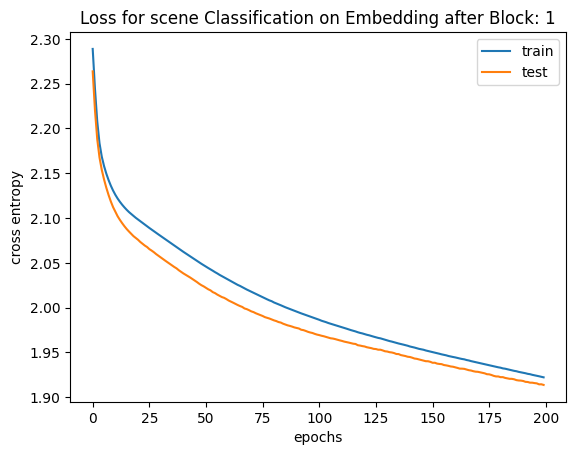

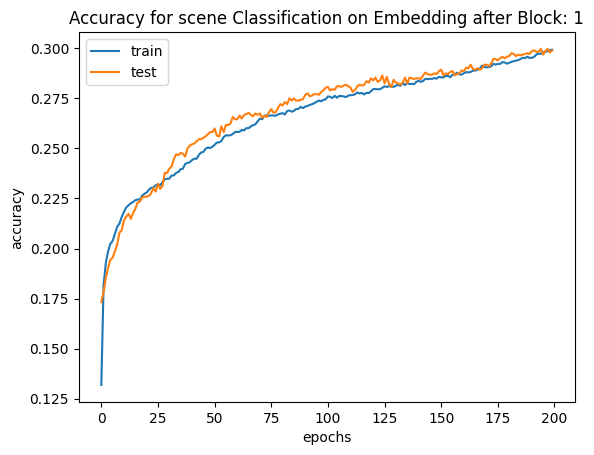

In [22]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [23]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [24]:
X_test=train_ready(test_data,col_name)

In [25]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

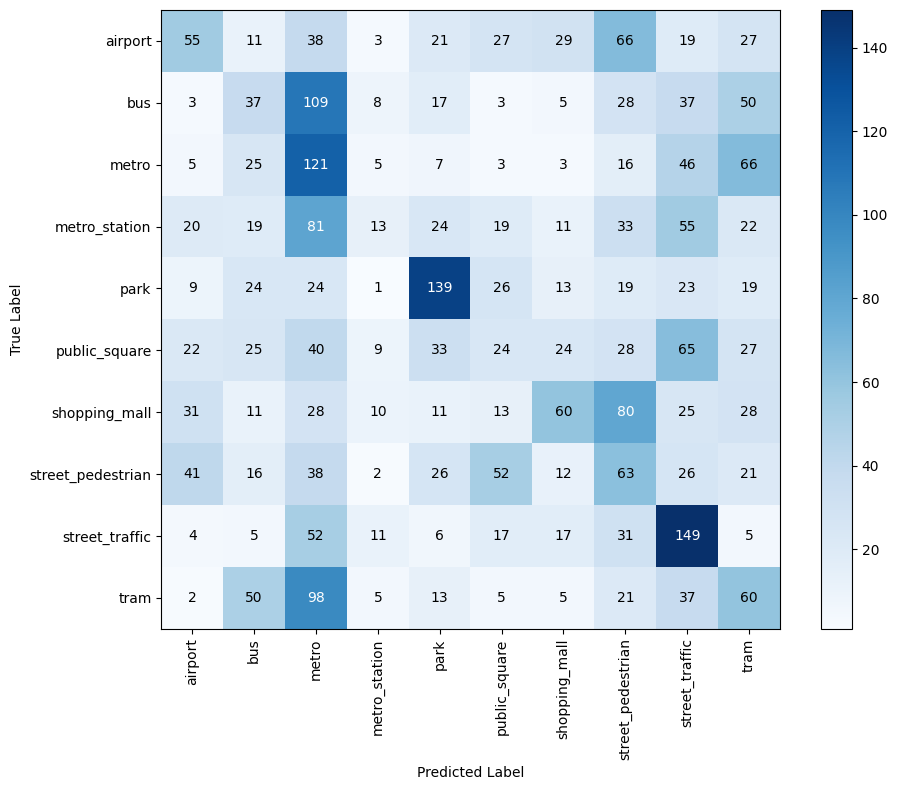

Accuracy: 0.2429


In [26]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-2

In [27]:
Block_number=2

In [28]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [30]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


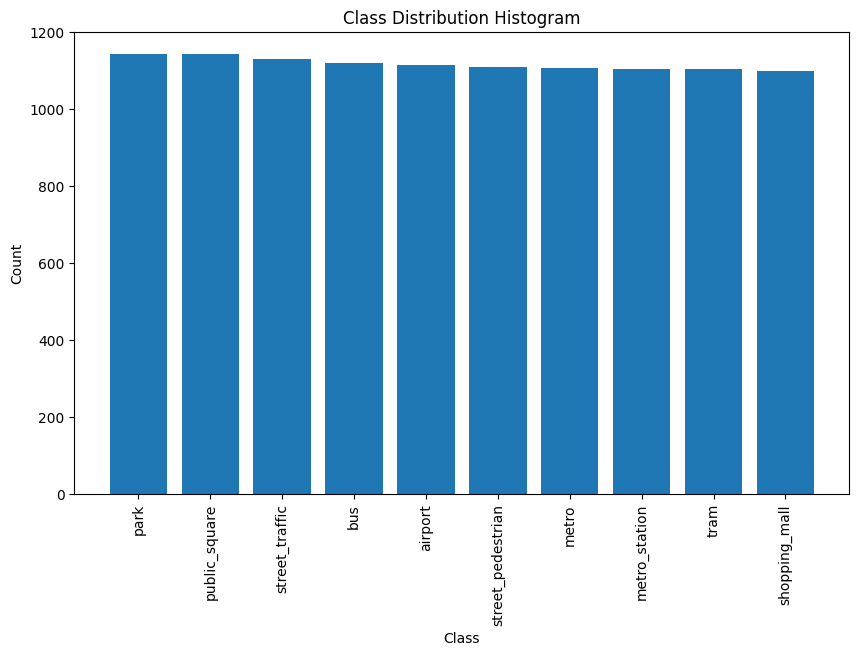

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [31]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


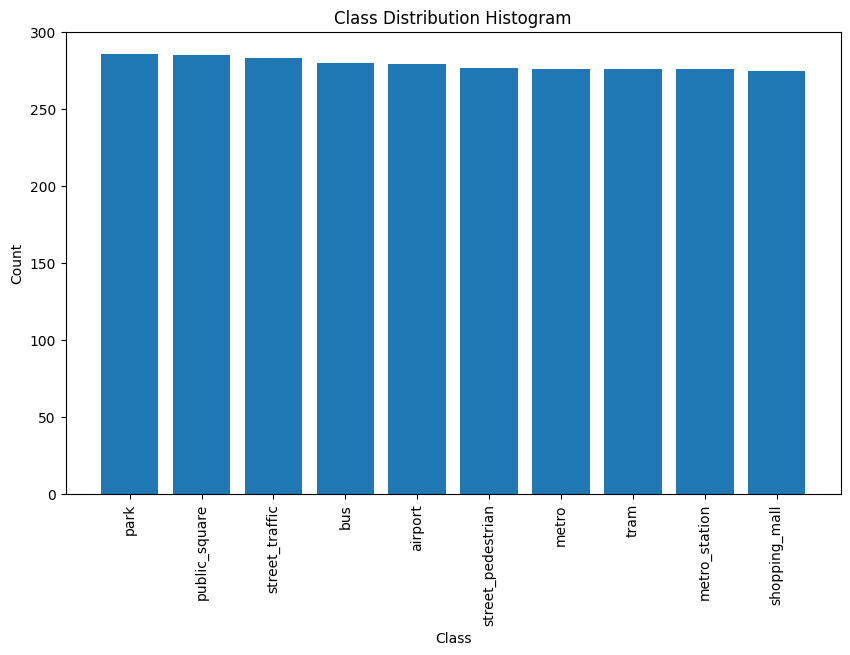

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [32]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [33]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [34]:
X_train_tensor.shape

torch.Size([11169, 768])

In [35]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 414.17batch/s, acc=0.188, loss=2.16] 


Epoch 0 validation: Cross-entropy=2.17, Accuracy=22.1%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 426.65batch/s, acc=0.234, loss=2.06]


Epoch 1 validation: Cross-entropy=2.08, Accuracy=25.8%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 431.52batch/s, acc=0.266, loss=1.98]


Epoch 2 validation: Cross-entropy=2.00, Accuracy=29.4%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 487.64batch/s, acc=0.312, loss=1.9] 


Epoch 3 validation: Cross-entropy=1.93, Accuracy=31.5%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 425.59batch/s, acc=0.312, loss=1.84]


Epoch 4 validation: Cross-entropy=1.87, Accuracy=33.7%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 431.18batch/s, acc=0.328, loss=1.8] 


Epoch 5 validation: Cross-entropy=1.82, Accuracy=34.9%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 406.25batch/s, acc=0.312, loss=1.77]


Epoch 6 validation: Cross-entropy=1.78, Accuracy=36.2%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 454.53batch/s, acc=0.328, loss=1.75]


Epoch 7 validation: Cross-entropy=1.74, Accuracy=37.1%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 426.93batch/s, acc=0.328, loss=1.73]


Epoch 8 validation: Cross-entropy=1.71, Accuracy=38.2%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 428.16batch/s, acc=0.359, loss=1.72]


Epoch 9 validation: Cross-entropy=1.69, Accuracy=39.7%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 489.27batch/s, acc=0.359, loss=1.7] 


Epoch 10 validation: Cross-entropy=1.67, Accuracy=40.3%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 381.00batch/s, acc=0.359, loss=1.69]


Epoch 11 validation: Cross-entropy=1.65, Accuracy=40.7%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 432.60batch/s, acc=0.359, loss=1.68]


Epoch 12 validation: Cross-entropy=1.63, Accuracy=41.4%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 433.53batch/s, acc=0.375, loss=1.67]


Epoch 13 validation: Cross-entropy=1.62, Accuracy=41.8%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 447.96batch/s, acc=0.375, loss=1.66]


Epoch 14 validation: Cross-entropy=1.61, Accuracy=42.1%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 430.65batch/s, acc=0.375, loss=1.66]


Epoch 15 validation: Cross-entropy=1.59, Accuracy=42.6%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 379.61batch/s, acc=0.375, loss=1.65]


Epoch 16 validation: Cross-entropy=1.58, Accuracy=43.3%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 473.23batch/s, acc=0.375, loss=1.64]


Epoch 17 validation: Cross-entropy=1.57, Accuracy=43.6%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 426.08batch/s, acc=0.375, loss=1.63]


Epoch 18 validation: Cross-entropy=1.56, Accuracy=44.0%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 409.87batch/s, acc=0.375, loss=1.63]


Epoch 19 validation: Cross-entropy=1.55, Accuracy=44.2%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 404.54batch/s, acc=0.391, loss=1.62]


Epoch 20 validation: Cross-entropy=1.54, Accuracy=44.3%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 396.45batch/s, acc=0.406, loss=1.62]


Epoch 21 validation: Cross-entropy=1.53, Accuracy=44.6%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 455.00batch/s, acc=0.406, loss=1.61]


Epoch 22 validation: Cross-entropy=1.53, Accuracy=45.2%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 432.35batch/s, acc=0.406, loss=1.61]


Epoch 23 validation: Cross-entropy=1.52, Accuracy=45.4%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 433.78batch/s, acc=0.406, loss=1.6] 


Epoch 24 validation: Cross-entropy=1.51, Accuracy=45.5%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 445.71batch/s, acc=0.406, loss=1.6] 


Epoch 25 validation: Cross-entropy=1.51, Accuracy=45.9%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 488.59batch/s, acc=0.422, loss=1.59]


Epoch 26 validation: Cross-entropy=1.50, Accuracy=46.2%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 387.45batch/s, acc=0.406, loss=1.59]


Epoch 27 validation: Cross-entropy=1.49, Accuracy=46.2%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 434.25batch/s, acc=0.422, loss=1.58]


Epoch 28 validation: Cross-entropy=1.49, Accuracy=46.4%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 491.75batch/s, acc=0.422, loss=1.58]


Epoch 29 validation: Cross-entropy=1.48, Accuracy=46.6%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 434.34batch/s, acc=0.422, loss=1.58]


Epoch 30 validation: Cross-entropy=1.48, Accuracy=46.7%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 434.13batch/s, acc=0.422, loss=1.57]


Epoch 31 validation: Cross-entropy=1.47, Accuracy=46.9%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 393.50batch/s, acc=0.406, loss=1.57]


Epoch 32 validation: Cross-entropy=1.47, Accuracy=46.9%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 493.33batch/s, acc=0.406, loss=1.56]


Epoch 33 validation: Cross-entropy=1.46, Accuracy=46.9%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 436.16batch/s, acc=0.406, loss=1.56]


Epoch 34 validation: Cross-entropy=1.46, Accuracy=46.9%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 429.92batch/s, acc=0.406, loss=1.56]


Epoch 35 validation: Cross-entropy=1.45, Accuracy=46.9%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 493.18batch/s, acc=0.406, loss=1.55]


Epoch 36 validation: Cross-entropy=1.45, Accuracy=46.9%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 389.14batch/s, acc=0.406, loss=1.55]


Epoch 37 validation: Cross-entropy=1.44, Accuracy=47.2%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 432.95batch/s, acc=0.406, loss=1.55]


Epoch 38 validation: Cross-entropy=1.44, Accuracy=47.3%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 493.61batch/s, acc=0.406, loss=1.55]


Epoch 39 validation: Cross-entropy=1.44, Accuracy=47.3%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 438.26batch/s, acc=0.406, loss=1.54]


Epoch 40 validation: Cross-entropy=1.43, Accuracy=47.6%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 424.49batch/s, acc=0.406, loss=1.54]


Epoch 41 validation: Cross-entropy=1.43, Accuracy=47.7%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 379.78batch/s, acc=0.406, loss=1.54]


Epoch 42 validation: Cross-entropy=1.42, Accuracy=47.7%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 442.36batch/s, acc=0.406, loss=1.53]


Epoch 43 validation: Cross-entropy=1.42, Accuracy=47.9%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 483.26batch/s, acc=0.406, loss=1.53]


Epoch 44 validation: Cross-entropy=1.42, Accuracy=47.8%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 435.12batch/s, acc=0.406, loss=1.53]


Epoch 45 validation: Cross-entropy=1.41, Accuracy=48.0%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 438.54batch/s, acc=0.406, loss=1.53]


Epoch 46 validation: Cross-entropy=1.41, Accuracy=47.9%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 489.11batch/s, acc=0.391, loss=1.52]


Epoch 47 validation: Cross-entropy=1.41, Accuracy=47.9%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 378.75batch/s, acc=0.391, loss=1.52]


Epoch 48 validation: Cross-entropy=1.40, Accuracy=47.9%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 438.95batch/s, acc=0.391, loss=1.52]


Epoch 49 validation: Cross-entropy=1.40, Accuracy=48.0%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 492.56batch/s, acc=0.391, loss=1.51]


Epoch 50 validation: Cross-entropy=1.40, Accuracy=48.3%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 440.48batch/s, acc=0.391, loss=1.51]


Epoch 51 validation: Cross-entropy=1.39, Accuracy=48.2%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 439.63batch/s, acc=0.391, loss=1.51]


Epoch 52 validation: Cross-entropy=1.39, Accuracy=48.4%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 385.92batch/s, acc=0.391, loss=1.51]


Epoch 53 validation: Cross-entropy=1.39, Accuracy=48.3%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 492.55batch/s, acc=0.391, loss=1.5] 


Epoch 54 validation: Cross-entropy=1.39, Accuracy=48.4%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 426.41batch/s, acc=0.391, loss=1.5] 


Epoch 55 validation: Cross-entropy=1.38, Accuracy=48.5%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 425.75batch/s, acc=0.391, loss=1.5] 


Epoch 56 validation: Cross-entropy=1.38, Accuracy=48.7%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 470.08batch/s, acc=0.391, loss=1.49]


Epoch 57 validation: Cross-entropy=1.38, Accuracy=48.9%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 408.31batch/s, acc=0.391, loss=1.49]


Epoch 58 validation: Cross-entropy=1.38, Accuracy=48.8%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 437.99batch/s, acc=0.391, loss=1.49]


Epoch 59 validation: Cross-entropy=1.37, Accuracy=48.8%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 436.00batch/s, acc=0.391, loss=1.49]


Epoch 60 validation: Cross-entropy=1.37, Accuracy=48.7%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 497.10batch/s, acc=0.391, loss=1.48]


Epoch 61 validation: Cross-entropy=1.37, Accuracy=48.8%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 437.37batch/s, acc=0.391, loss=1.48]


Epoch 62 validation: Cross-entropy=1.37, Accuracy=48.9%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 405.98batch/s, acc=0.391, loss=1.48]


Epoch 63 validation: Cross-entropy=1.36, Accuracy=48.9%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 459.91batch/s, acc=0.391, loss=1.48]


Epoch 64 validation: Cross-entropy=1.36, Accuracy=49.1%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 438.21batch/s, acc=0.391, loss=1.47]


Epoch 65 validation: Cross-entropy=1.36, Accuracy=49.1%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 437.33batch/s, acc=0.391, loss=1.47]


Epoch 66 validation: Cross-entropy=1.36, Accuracy=49.1%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 448.86batch/s, acc=0.406, loss=1.47]


Epoch 67 validation: Cross-entropy=1.36, Accuracy=49.4%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 378.46batch/s, acc=0.406, loss=1.47]


Epoch 68 validation: Cross-entropy=1.35, Accuracy=49.6%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 357.82batch/s, acc=0.406, loss=1.46]


Epoch 69 validation: Cross-entropy=1.35, Accuracy=49.6%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 378.33batch/s, acc=0.422, loss=1.46]


Epoch 70 validation: Cross-entropy=1.35, Accuracy=49.9%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 421.05batch/s, acc=0.422, loss=1.46]


Epoch 71 validation: Cross-entropy=1.35, Accuracy=50.0%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 297.13batch/s, acc=0.422, loss=1.45]


Epoch 72 validation: Cross-entropy=1.35, Accuracy=50.1%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 362.75batch/s, acc=0.422, loss=1.45]


Epoch 73 validation: Cross-entropy=1.35, Accuracy=50.1%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 375.59batch/s, acc=0.438, loss=1.45]


Epoch 74 validation: Cross-entropy=1.34, Accuracy=50.2%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 353.93batch/s, acc=0.438, loss=1.45]


Epoch 75 validation: Cross-entropy=1.34, Accuracy=50.3%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 367.22batch/s, acc=0.422, loss=1.45]


Epoch 76 validation: Cross-entropy=1.34, Accuracy=50.4%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 355.24batch/s, acc=0.438, loss=1.44]


Epoch 77 validation: Cross-entropy=1.34, Accuracy=50.4%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 365.58batch/s, acc=0.438, loss=1.44]


Epoch 78 validation: Cross-entropy=1.34, Accuracy=50.4%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 469.00batch/s, acc=0.438, loss=1.44]


Epoch 79 validation: Cross-entropy=1.34, Accuracy=50.5%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 429.11batch/s, acc=0.438, loss=1.44]


Epoch 80 validation: Cross-entropy=1.33, Accuracy=50.6%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 380.85batch/s, acc=0.438, loss=1.43]


Epoch 81 validation: Cross-entropy=1.33, Accuracy=50.6%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 383.54batch/s, acc=0.438, loss=1.43]


Epoch 82 validation: Cross-entropy=1.33, Accuracy=50.7%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 390.82batch/s, acc=0.438, loss=1.43]


Epoch 83 validation: Cross-entropy=1.33, Accuracy=50.8%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 332.18batch/s, acc=0.438, loss=1.43]


Epoch 84 validation: Cross-entropy=1.33, Accuracy=50.8%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 293.93batch/s, acc=0.438, loss=1.42]


Epoch 85 validation: Cross-entropy=1.33, Accuracy=50.7%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 335.69batch/s, acc=0.438, loss=1.42] 


Epoch 86 validation: Cross-entropy=1.33, Accuracy=50.8%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 407.82batch/s, acc=0.438, loss=1.42] 


Epoch 87 validation: Cross-entropy=1.32, Accuracy=50.7%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 359.12batch/s, acc=0.438, loss=1.42] 


Epoch 88 validation: Cross-entropy=1.32, Accuracy=50.9%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 349.48batch/s, acc=0.438, loss=1.41] 


Epoch 89 validation: Cross-entropy=1.32, Accuracy=51.0%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 427.13batch/s, acc=0.438, loss=1.41] 


Epoch 90 validation: Cross-entropy=1.32, Accuracy=51.0%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 326.05batch/s, acc=0.453, loss=1.41]


Epoch 91 validation: Cross-entropy=1.32, Accuracy=51.0%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 366.78batch/s, acc=0.438, loss=1.4]  


Epoch 92 validation: Cross-entropy=1.32, Accuracy=51.1%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 405.30batch/s, acc=0.438, loss=1.4]  


Epoch 93 validation: Cross-entropy=1.32, Accuracy=51.1%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 393.95batch/s, acc=0.453, loss=1.4]  


Epoch 94 validation: Cross-entropy=1.32, Accuracy=51.1%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 372.12batch/s, acc=0.453, loss=1.4]  


Epoch 95 validation: Cross-entropy=1.31, Accuracy=51.2%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 325.48batch/s, acc=0.453, loss=1.39]


Epoch 96 validation: Cross-entropy=1.31, Accuracy=51.0%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 436.63batch/s, acc=0.469, loss=1.39] 


Epoch 97 validation: Cross-entropy=1.31, Accuracy=51.3%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 376.92batch/s, acc=0.453, loss=1.39] 


Epoch 98 validation: Cross-entropy=1.31, Accuracy=51.2%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 377.79batch/s, acc=0.453, loss=1.39] 


Epoch 99 validation: Cross-entropy=1.31, Accuracy=51.3%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 382.03batch/s, acc=0.469, loss=1.39] 


Epoch 100 validation: Cross-entropy=1.31, Accuracy=51.4%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 364.98batch/s, acc=0.469, loss=1.38] 


Epoch 101 validation: Cross-entropy=1.31, Accuracy=51.5%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 376.37batch/s, acc=0.469, loss=1.38] 


Epoch 102 validation: Cross-entropy=1.31, Accuracy=51.5%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 419.09batch/s, acc=0.484, loss=1.38] 


Epoch 103 validation: Cross-entropy=1.30, Accuracy=51.5%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 400.86batch/s, acc=0.484, loss=1.38] 


Epoch 104 validation: Cross-entropy=1.30, Accuracy=51.6%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 311.64batch/s, acc=0.484, loss=1.37] 


Epoch 105 validation: Cross-entropy=1.30, Accuracy=51.5%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 370.88batch/s, acc=0.469, loss=1.37] 


Epoch 106 validation: Cross-entropy=1.30, Accuracy=51.6%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 442.52batch/s, acc=0.484, loss=1.37] 


Epoch 107 validation: Cross-entropy=1.30, Accuracy=51.6%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 372.87batch/s, acc=0.469, loss=1.37]


Epoch 108 validation: Cross-entropy=1.30, Accuracy=51.6%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 334.69batch/s, acc=0.484, loss=1.37] 


Epoch 109 validation: Cross-entropy=1.30, Accuracy=51.5%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 442.30batch/s, acc=0.484, loss=1.36] 


Epoch 110 validation: Cross-entropy=1.30, Accuracy=51.5%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 381.07batch/s, acc=0.484, loss=1.36] 


Epoch 111 validation: Cross-entropy=1.30, Accuracy=51.5%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 375.69batch/s, acc=0.5, loss=1.36]   


Epoch 112 validation: Cross-entropy=1.30, Accuracy=51.6%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 375.74batch/s, acc=0.5, loss=1.36]   


Epoch 113 validation: Cross-entropy=1.29, Accuracy=51.7%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 380.84batch/s, acc=0.5, loss=1.36]   


Epoch 114 validation: Cross-entropy=1.29, Accuracy=51.7%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 383.74batch/s, acc=0.5, loss=1.35]  


Epoch 115 validation: Cross-entropy=1.29, Accuracy=51.7%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 385.10batch/s, acc=0.5, loss=1.35]   


Epoch 116 validation: Cross-entropy=1.29, Accuracy=51.7%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 441.74batch/s, acc=0.5, loss=1.35]   


Epoch 117 validation: Cross-entropy=1.29, Accuracy=51.8%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 338.87batch/s, acc=0.5, loss=1.35]   


Epoch 118 validation: Cross-entropy=1.29, Accuracy=51.8%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 376.45batch/s, acc=0.5, loss=1.34]   


Epoch 119 validation: Cross-entropy=1.29, Accuracy=52.0%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 388.86batch/s, acc=0.5, loss=1.34]   


Epoch 120 validation: Cross-entropy=1.29, Accuracy=51.8%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 439.69batch/s, acc=0.5, loss=1.34]   


Epoch 121 validation: Cross-entropy=1.29, Accuracy=51.8%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 325.13batch/s, acc=0.5, loss=1.34]   


Epoch 122 validation: Cross-entropy=1.29, Accuracy=51.9%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 376.63batch/s, acc=0.5, loss=1.34]   


Epoch 123 validation: Cross-entropy=1.28, Accuracy=51.8%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 419.03batch/s, acc=0.5, loss=1.33]   


Epoch 124 validation: Cross-entropy=1.28, Accuracy=51.8%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 375.10batch/s, acc=0.5, loss=1.33]   


Epoch 125 validation: Cross-entropy=1.28, Accuracy=51.8%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 376.86batch/s, acc=0.5, loss=1.33]   


Epoch 126 validation: Cross-entropy=1.28, Accuracy=51.8%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 384.02batch/s, acc=0.5, loss=1.33]   


Epoch 127 validation: Cross-entropy=1.28, Accuracy=51.8%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 361.36batch/s, acc=0.5, loss=1.32]   


Epoch 128 validation: Cross-entropy=1.28, Accuracy=51.9%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 372.62batch/s, acc=0.5, loss=1.33]   


Epoch 129 validation: Cross-entropy=1.28, Accuracy=52.0%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 372.13batch/s, acc=0.5, loss=1.32]   


Epoch 130 validation: Cross-entropy=1.28, Accuracy=52.1%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 372.77batch/s, acc=0.5, loss=1.32]   


Epoch 131 validation: Cross-entropy=1.28, Accuracy=52.2%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 366.53batch/s, acc=0.5, loss=1.32]   


Epoch 132 validation: Cross-entropy=1.28, Accuracy=52.1%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 380.91batch/s, acc=0.5, loss=1.32]   


Epoch 133 validation: Cross-entropy=1.28, Accuracy=52.1%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 425.48batch/s, acc=0.5, loss=1.31]   


Epoch 134 validation: Cross-entropy=1.28, Accuracy=52.3%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 335.24batch/s, acc=0.5, loss=1.31]   


Epoch 135 validation: Cross-entropy=1.27, Accuracy=52.3%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 389.09batch/s, acc=0.5, loss=1.31]   


Epoch 136 validation: Cross-entropy=1.27, Accuracy=52.5%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 376.93batch/s, acc=0.5, loss=1.31]   


Epoch 137 validation: Cross-entropy=1.27, Accuracy=52.6%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 435.07batch/s, acc=0.5, loss=1.31]   


Epoch 138 validation: Cross-entropy=1.27, Accuracy=52.5%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 382.51batch/s, acc=0.5, loss=1.3]    


Epoch 139 validation: Cross-entropy=1.27, Accuracy=52.6%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 334.66batch/s, acc=0.5, loss=1.3]    


Epoch 140 validation: Cross-entropy=1.27, Accuracy=52.7%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 435.94batch/s, acc=0.5, loss=1.3]    


Epoch 141 validation: Cross-entropy=1.27, Accuracy=52.6%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 381.25batch/s, acc=0.484, loss=1.3]  


Epoch 142 validation: Cross-entropy=1.27, Accuracy=52.7%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 376.53batch/s, acc=0.484, loss=1.3]  


Epoch 143 validation: Cross-entropy=1.27, Accuracy=52.5%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 377.05batch/s, acc=0.484, loss=1.3]  


Epoch 144 validation: Cross-entropy=1.27, Accuracy=52.4%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 376.95batch/s, acc=0.484, loss=1.29] 


Epoch 145 validation: Cross-entropy=1.27, Accuracy=52.8%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 383.06batch/s, acc=0.484, loss=1.29] 


Epoch 146 validation: Cross-entropy=1.27, Accuracy=52.5%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 402.42batch/s, acc=0.484, loss=1.29] 


Epoch 147 validation: Cross-entropy=1.26, Accuracy=52.6%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 350.15batch/s, acc=0.484, loss=1.29] 


Epoch 148 validation: Cross-entropy=1.26, Accuracy=52.5%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 380.53batch/s, acc=0.484, loss=1.28] 


Epoch 149 validation: Cross-entropy=1.26, Accuracy=52.6%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 370.68batch/s, acc=0.484, loss=1.28] 


Epoch 150 validation: Cross-entropy=1.26, Accuracy=52.6%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 439.96batch/s, acc=0.484, loss=1.28] 


Epoch 151 validation: Cross-entropy=1.26, Accuracy=52.6%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 335.53batch/s, acc=0.484, loss=1.28] 


Epoch 152 validation: Cross-entropy=1.26, Accuracy=52.6%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 382.25batch/s, acc=0.484, loss=1.28] 


Epoch 153 validation: Cross-entropy=1.26, Accuracy=52.7%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 437.19batch/s, acc=0.484, loss=1.28] 


Epoch 154 validation: Cross-entropy=1.26, Accuracy=52.6%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 378.10batch/s, acc=0.484, loss=1.27] 


Epoch 155 validation: Cross-entropy=1.26, Accuracy=52.6%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 374.39batch/s, acc=0.484, loss=1.27] 


Epoch 156 validation: Cross-entropy=1.26, Accuracy=52.8%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 336.38batch/s, acc=0.484, loss=1.27] 


Epoch 157 validation: Cross-entropy=1.26, Accuracy=52.7%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 429.59batch/s, acc=0.484, loss=1.27] 


Epoch 158 validation: Cross-entropy=1.26, Accuracy=52.7%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 401.82batch/s, acc=0.484, loss=1.27] 


Epoch 159 validation: Cross-entropy=1.26, Accuracy=52.8%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 376.82batch/s, acc=0.484, loss=1.27] 


Epoch 160 validation: Cross-entropy=1.25, Accuracy=52.8%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 373.40batch/s, acc=0.484, loss=1.26] 


Epoch 161 validation: Cross-entropy=1.25, Accuracy=52.8%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 384.04batch/s, acc=0.484, loss=1.26] 


Epoch 162 validation: Cross-entropy=1.25, Accuracy=52.8%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 384.94batch/s, acc=0.484, loss=1.26] 


Epoch 163 validation: Cross-entropy=1.25, Accuracy=52.8%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 445.00batch/s, acc=0.484, loss=1.26] 


Epoch 164 validation: Cross-entropy=1.25, Accuracy=52.8%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 335.45batch/s, acc=0.484, loss=1.26] 


Epoch 165 validation: Cross-entropy=1.25, Accuracy=53.0%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 374.91batch/s, acc=0.484, loss=1.26] 


Epoch 166 validation: Cross-entropy=1.25, Accuracy=52.9%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 375.88batch/s, acc=0.484, loss=1.26] 


Epoch 167 validation: Cross-entropy=1.25, Accuracy=53.1%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 417.55batch/s, acc=0.484, loss=1.25] 


Epoch 168 validation: Cross-entropy=1.25, Accuracy=53.0%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 325.80batch/s, acc=0.484, loss=1.25] 


Epoch 169 validation: Cross-entropy=1.25, Accuracy=53.0%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 380.27batch/s, acc=0.484, loss=1.25] 


Epoch 170 validation: Cross-entropy=1.25, Accuracy=53.1%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 424.65batch/s, acc=0.484, loss=1.25] 


Epoch 171 validation: Cross-entropy=1.25, Accuracy=53.1%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 374.09batch/s, acc=0.484, loss=1.25] 


Epoch 172 validation: Cross-entropy=1.25, Accuracy=53.1%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 335.80batch/s, acc=0.484, loss=1.25] 


Epoch 173 validation: Cross-entropy=1.24, Accuracy=53.0%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 420.04batch/s, acc=0.484, loss=1.25] 


Epoch 174 validation: Cross-entropy=1.24, Accuracy=53.1%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 380.51batch/s, acc=0.484, loss=1.24] 


Epoch 175 validation: Cross-entropy=1.24, Accuracy=53.2%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 357.68batch/s, acc=0.5, loss=1.24]   


Epoch 176 validation: Cross-entropy=1.24, Accuracy=53.1%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 395.81batch/s, acc=0.5, loss=1.24]   


Epoch 177 validation: Cross-entropy=1.24, Accuracy=53.0%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 346.92batch/s, acc=0.5, loss=1.24]   


Epoch 178 validation: Cross-entropy=1.24, Accuracy=53.1%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 364.69batch/s, acc=0.5, loss=1.24]   


Epoch 179 validation: Cross-entropy=1.24, Accuracy=53.2%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 379.49batch/s, acc=0.484, loss=1.24] 


Epoch 180 validation: Cross-entropy=1.24, Accuracy=53.1%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 421.93batch/s, acc=0.484, loss=1.24] 


Epoch 181 validation: Cross-entropy=1.24, Accuracy=53.3%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 327.00batch/s, acc=0.5, loss=1.24]   


Epoch 182 validation: Cross-entropy=1.24, Accuracy=53.1%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 369.76batch/s, acc=0.5, loss=1.23]   


Epoch 183 validation: Cross-entropy=1.24, Accuracy=53.2%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 422.97batch/s, acc=0.5, loss=1.23]   


Epoch 184 validation: Cross-entropy=1.24, Accuracy=53.3%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 369.61batch/s, acc=0.5, loss=1.23]   


Epoch 185 validation: Cross-entropy=1.24, Accuracy=53.2%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 315.33batch/s, acc=0.5, loss=1.23]   


Epoch 186 validation: Cross-entropy=1.24, Accuracy=53.3%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 386.91batch/s, acc=0.484, loss=1.23] 


Epoch 187 validation: Cross-entropy=1.23, Accuracy=53.2%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 410.31batch/s, acc=0.484, loss=1.23] 


Epoch 188 validation: Cross-entropy=1.23, Accuracy=53.3%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 367.94batch/s, acc=0.484, loss=1.23] 


Epoch 189 validation: Cross-entropy=1.23, Accuracy=53.2%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 322.25batch/s, acc=0.484, loss=1.22] 


Epoch 190 validation: Cross-entropy=1.23, Accuracy=53.3%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 425.76batch/s, acc=0.484, loss=1.22] 


Epoch 191 validation: Cross-entropy=1.23, Accuracy=53.5%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 360.72batch/s, acc=0.484, loss=1.22] 


Epoch 192 validation: Cross-entropy=1.23, Accuracy=53.3%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 365.69batch/s, acc=0.484, loss=1.22] 


Epoch 193 validation: Cross-entropy=1.23, Accuracy=53.5%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 331.09batch/s, acc=0.484, loss=1.22] 


Epoch 194 validation: Cross-entropy=1.23, Accuracy=53.2%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 400.61batch/s, acc=0.5, loss=1.22]   


Epoch 195 validation: Cross-entropy=1.23, Accuracy=53.3%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 366.98batch/s, acc=0.5, loss=1.22]   


Epoch 196 validation: Cross-entropy=1.23, Accuracy=53.5%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 353.20batch/s, acc=0.5, loss=1.21]   


Epoch 197 validation: Cross-entropy=1.23, Accuracy=53.3%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 363.41batch/s, acc=0.484, loss=1.21] 


Epoch 198 validation: Cross-entropy=1.23, Accuracy=53.5%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 367.66batch/s, acc=0.484, loss=1.21] 


Epoch 199 validation: Cross-entropy=1.23, Accuracy=53.5%


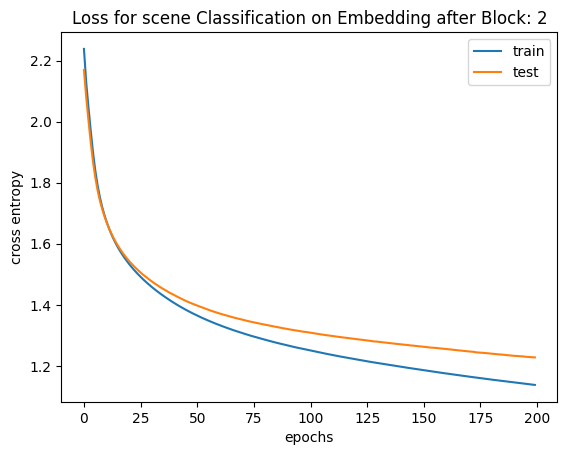

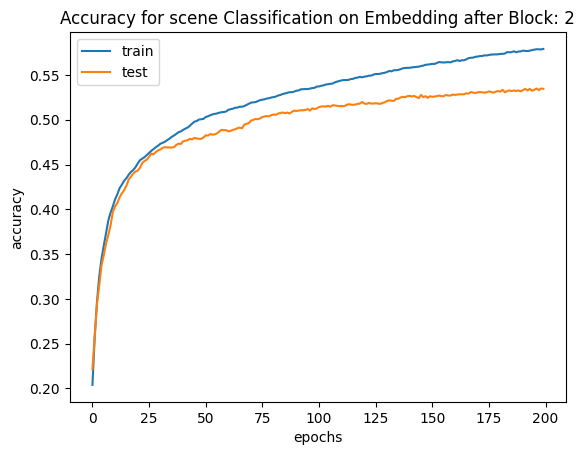

In [37]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [38]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [39]:
X_test=train_ready(test_data,col_name)

In [40]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

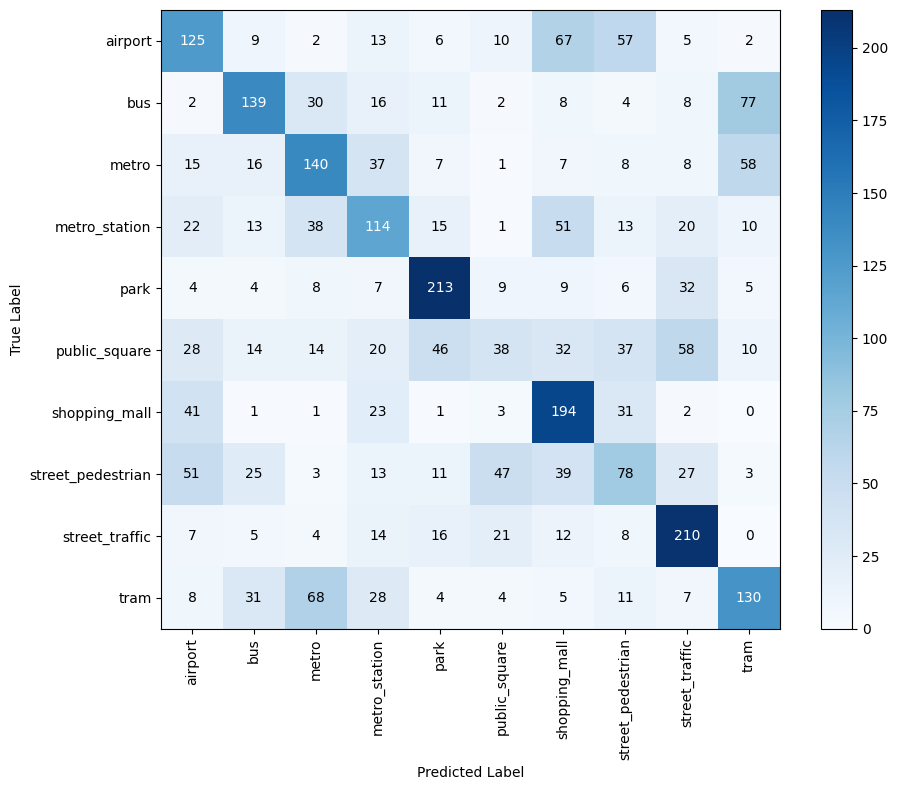

Accuracy: 0.4653


In [41]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)

# Block-3

In [42]:
Block_number=3

In [43]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [44]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [45]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


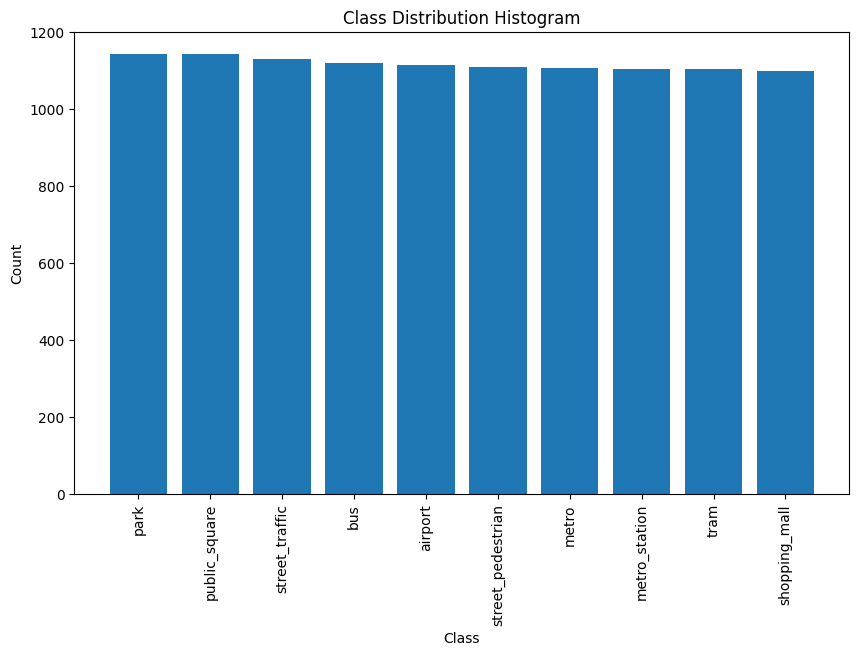

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [46]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


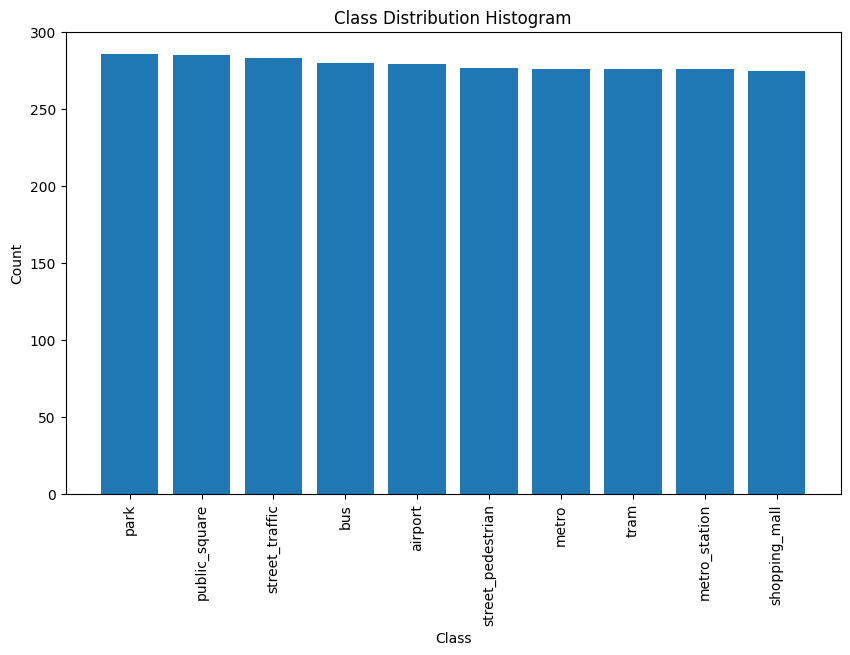

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [47]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [48]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [49]:
X_train_tensor.shape

torch.Size([11169, 768])

In [50]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 324.09batch/s, acc=0.25, loss=2.11] 


Epoch 0 validation: Cross-entropy=2.11, Accuracy=28.6%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 427.82batch/s, acc=0.375, loss=1.93]


Epoch 1 validation: Cross-entropy=1.94, Accuracy=35.3%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 427.02batch/s, acc=0.375, loss=1.78]


Epoch 2 validation: Cross-entropy=1.80, Accuracy=39.1%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 478.27batch/s, acc=0.391, loss=1.67]


Epoch 3 validation: Cross-entropy=1.69, Accuracy=42.1%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 431.59batch/s, acc=0.406, loss=1.6] 


Epoch 4 validation: Cross-entropy=1.61, Accuracy=44.0%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 380.68batch/s, acc=0.406, loss=1.55]


Epoch 5 validation: Cross-entropy=1.55, Accuracy=45.6%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 475.27batch/s, acc=0.422, loss=1.52]


Epoch 6 validation: Cross-entropy=1.51, Accuracy=47.0%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 432.47batch/s, acc=0.453, loss=1.49]


Epoch 7 validation: Cross-entropy=1.47, Accuracy=47.8%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 428.55batch/s, acc=0.5, loss=1.46]  


Epoch 8 validation: Cross-entropy=1.44, Accuracy=48.7%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 485.89batch/s, acc=0.484, loss=1.44]


Epoch 9 validation: Cross-entropy=1.41, Accuracy=49.1%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 430.35batch/s, acc=0.469, loss=1.43]


Epoch 10 validation: Cross-entropy=1.39, Accuracy=49.6%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 379.27batch/s, acc=0.453, loss=1.41]


Epoch 11 validation: Cross-entropy=1.37, Accuracy=50.2%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 429.25batch/s, acc=0.453, loss=1.4] 


Epoch 12 validation: Cross-entropy=1.35, Accuracy=50.7%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 485.56batch/s, acc=0.469, loss=1.39]


Epoch 13 validation: Cross-entropy=1.34, Accuracy=51.0%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 431.59batch/s, acc=0.469, loss=1.37]


Epoch 14 validation: Cross-entropy=1.32, Accuracy=51.5%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 416.91batch/s, acc=0.469, loss=1.36]


Epoch 15 validation: Cross-entropy=1.31, Accuracy=52.0%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 392.76batch/s, acc=0.469, loss=1.36]


Epoch 16 validation: Cross-entropy=1.30, Accuracy=52.1%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 473.43batch/s, acc=0.469, loss=1.35]


Epoch 17 validation: Cross-entropy=1.29, Accuracy=52.2%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 417.05batch/s, acc=0.469, loss=1.34]


Epoch 18 validation: Cross-entropy=1.28, Accuracy=52.6%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 425.61batch/s, acc=0.469, loss=1.33]


Epoch 19 validation: Cross-entropy=1.28, Accuracy=52.6%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 443.29batch/s, acc=0.484, loss=1.32]


Epoch 20 validation: Cross-entropy=1.27, Accuracy=53.1%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 466.58batch/s, acc=0.484, loss=1.32]


Epoch 21 validation: Cross-entropy=1.26, Accuracy=53.5%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 377.82batch/s, acc=0.484, loss=1.31]


Epoch 22 validation: Cross-entropy=1.26, Accuracy=53.8%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 426.24batch/s, acc=0.5, loss=1.3]   


Epoch 23 validation: Cross-entropy=1.25, Accuracy=54.0%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 490.58batch/s, acc=0.484, loss=1.3] 


Epoch 24 validation: Cross-entropy=1.24, Accuracy=54.1%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 432.76batch/s, acc=0.5, loss=1.29]  


Epoch 25 validation: Cross-entropy=1.24, Accuracy=54.3%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 433.43batch/s, acc=0.5, loss=1.29]   


Epoch 26 validation: Cross-entropy=1.23, Accuracy=54.6%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 425.81batch/s, acc=0.5, loss=1.28]   


Epoch 27 validation: Cross-entropy=1.23, Accuracy=54.6%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 429.01batch/s, acc=0.5, loss=1.28]   


Epoch 28 validation: Cross-entropy=1.23, Accuracy=54.6%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 427.82batch/s, acc=0.5, loss=1.27]   


Epoch 29 validation: Cross-entropy=1.22, Accuracy=54.8%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 434.56batch/s, acc=0.5, loss=1.27]   


Epoch 30 validation: Cross-entropy=1.22, Accuracy=55.0%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 486.67batch/s, acc=0.5, loss=1.26]   


Epoch 31 validation: Cross-entropy=1.21, Accuracy=55.2%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 384.74batch/s, acc=0.5, loss=1.26]   


Epoch 32 validation: Cross-entropy=1.21, Accuracy=55.2%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 437.16batch/s, acc=0.5, loss=1.26]   


Epoch 33 validation: Cross-entropy=1.21, Accuracy=55.3%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 461.13batch/s, acc=0.484, loss=1.25] 


Epoch 34 validation: Cross-entropy=1.20, Accuracy=55.4%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 475.26batch/s, acc=0.5, loss=1.25]   


Epoch 35 validation: Cross-entropy=1.20, Accuracy=55.6%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 433.21batch/s, acc=0.5, loss=1.24]   


Epoch 36 validation: Cross-entropy=1.20, Accuracy=55.8%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 384.95batch/s, acc=0.5, loss=1.24]   


Epoch 37 validation: Cross-entropy=1.19, Accuracy=55.8%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 487.63batch/s, acc=0.5, loss=1.23]   


Epoch 38 validation: Cross-entropy=1.19, Accuracy=55.8%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 433.04batch/s, acc=0.5, loss=1.23]   


Epoch 39 validation: Cross-entropy=1.19, Accuracy=55.9%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 430.13batch/s, acc=0.5, loss=1.23]   


Epoch 40 validation: Cross-entropy=1.19, Accuracy=55.9%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 491.44batch/s, acc=0.516, loss=1.22] 


Epoch 41 validation: Cross-entropy=1.18, Accuracy=56.1%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 392.72batch/s, acc=0.516, loss=1.22] 


Epoch 42 validation: Cross-entropy=1.18, Accuracy=56.2%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 416.80batch/s, acc=0.516, loss=1.21] 


Epoch 43 validation: Cross-entropy=1.18, Accuracy=56.3%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 436.40batch/s, acc=0.5, loss=1.21]   


Epoch 44 validation: Cross-entropy=1.18, Accuracy=56.6%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 490.11batch/s, acc=0.516, loss=1.21] 


Epoch 45 validation: Cross-entropy=1.17, Accuracy=56.6%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 429.91batch/s, acc=0.531, loss=1.2]  


Epoch 46 validation: Cross-entropy=1.17, Accuracy=56.6%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 393.10batch/s, acc=0.531, loss=1.2]  


Epoch 47 validation: Cross-entropy=1.17, Accuracy=56.6%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 475.45batch/s, acc=0.531, loss=1.2]  


Epoch 48 validation: Cross-entropy=1.17, Accuracy=56.6%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 433.00batch/s, acc=0.531, loss=1.19] 


Epoch 49 validation: Cross-entropy=1.16, Accuracy=56.7%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 435.18batch/s, acc=0.531, loss=1.19] 


Epoch 50 validation: Cross-entropy=1.16, Accuracy=56.9%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 454.31batch/s, acc=0.531, loss=1.19] 


Epoch 51 validation: Cross-entropy=1.16, Accuracy=57.0%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 480.95batch/s, acc=0.531, loss=1.18] 


Epoch 52 validation: Cross-entropy=1.16, Accuracy=57.0%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 384.22batch/s, acc=0.531, loss=1.18] 


Epoch 53 validation: Cross-entropy=1.16, Accuracy=57.0%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 421.08batch/s, acc=0.531, loss=1.18] 


Epoch 54 validation: Cross-entropy=1.15, Accuracy=57.1%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 493.74batch/s, acc=0.531, loss=1.17] 


Epoch 55 validation: Cross-entropy=1.15, Accuracy=57.1%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 439.16batch/s, acc=0.531, loss=1.17] 


Epoch 56 validation: Cross-entropy=1.15, Accuracy=57.1%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 436.25batch/s, acc=0.531, loss=1.17] 


Epoch 57 validation: Cross-entropy=1.15, Accuracy=57.4%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 380.79batch/s, acc=0.531, loss=1.17] 


Epoch 58 validation: Cross-entropy=1.15, Accuracy=57.4%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 488.40batch/s, acc=0.531, loss=1.16] 


Epoch 59 validation: Cross-entropy=1.14, Accuracy=57.4%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 433.69batch/s, acc=0.531, loss=1.16] 


Epoch 60 validation: Cross-entropy=1.14, Accuracy=57.5%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 435.45batch/s, acc=0.531, loss=1.16] 


Epoch 61 validation: Cross-entropy=1.14, Accuracy=57.7%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 487.08batch/s, acc=0.531, loss=1.15] 


Epoch 62 validation: Cross-entropy=1.14, Accuracy=57.8%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 372.39batch/s, acc=0.531, loss=1.15] 


Epoch 63 validation: Cross-entropy=1.14, Accuracy=57.7%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 427.69batch/s, acc=0.531, loss=1.15] 


Epoch 64 validation: Cross-entropy=1.14, Accuracy=57.8%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 438.23batch/s, acc=0.531, loss=1.14] 


Epoch 65 validation: Cross-entropy=1.13, Accuracy=57.9%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 491.15batch/s, acc=0.531, loss=1.14] 


Epoch 66 validation: Cross-entropy=1.13, Accuracy=58.0%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 436.75batch/s, acc=0.531, loss=1.14] 


Epoch 67 validation: Cross-entropy=1.13, Accuracy=58.0%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 384.21batch/s, acc=0.531, loss=1.14] 


Epoch 68 validation: Cross-entropy=1.13, Accuracy=58.0%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 484.57batch/s, acc=0.531, loss=1.13] 


Epoch 69 validation: Cross-entropy=1.13, Accuracy=58.1%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 435.19batch/s, acc=0.531, loss=1.13] 


Epoch 70 validation: Cross-entropy=1.13, Accuracy=58.2%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 437.83batch/s, acc=0.531, loss=1.13] 


Epoch 71 validation: Cross-entropy=1.12, Accuracy=58.3%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 492.94batch/s, acc=0.531, loss=1.13] 


Epoch 72 validation: Cross-entropy=1.12, Accuracy=58.3%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 382.02batch/s, acc=0.531, loss=1.12] 


Epoch 73 validation: Cross-entropy=1.12, Accuracy=58.3%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 423.36batch/s, acc=0.531, loss=1.12] 


Epoch 74 validation: Cross-entropy=1.12, Accuracy=58.4%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 439.24batch/s, acc=0.531, loss=1.12] 


Epoch 75 validation: Cross-entropy=1.12, Accuracy=58.3%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 486.10batch/s, acc=0.531, loss=1.12] 


Epoch 76 validation: Cross-entropy=1.12, Accuracy=58.4%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 435.79batch/s, acc=0.531, loss=1.11] 


Epoch 77 validation: Cross-entropy=1.11, Accuracy=58.4%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 383.98batch/s, acc=0.531, loss=1.11] 


Epoch 78 validation: Cross-entropy=1.11, Accuracy=58.4%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 481.31batch/s, acc=0.531, loss=1.11] 


Epoch 79 validation: Cross-entropy=1.11, Accuracy=58.6%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 438.76batch/s, acc=0.531, loss=1.1]  


Epoch 80 validation: Cross-entropy=1.11, Accuracy=58.7%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 429.49batch/s, acc=0.531, loss=1.1]  


Epoch 81 validation: Cross-entropy=1.11, Accuracy=58.8%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 427.37batch/s, acc=0.531, loss=1.1]  


Epoch 82 validation: Cross-entropy=1.11, Accuracy=58.8%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 472.37batch/s, acc=0.531, loss=1.1]  


Epoch 83 validation: Cross-entropy=1.11, Accuracy=58.8%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 338.80batch/s, acc=0.531, loss=1.09] 


Epoch 84 validation: Cross-entropy=1.10, Accuracy=58.8%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 388.90batch/s, acc=0.531, loss=1.09] 


Epoch 85 validation: Cross-entropy=1.10, Accuracy=58.8%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 405.36batch/s, acc=0.531, loss=1.09] 


Epoch 86 validation: Cross-entropy=1.10, Accuracy=58.8%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 353.39batch/s, acc=0.531, loss=1.09] 


Epoch 87 validation: Cross-entropy=1.10, Accuracy=59.0%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 290.07batch/s, acc=0.531, loss=1.08] 


Epoch 88 validation: Cross-entropy=1.10, Accuracy=59.0%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 300.77batch/s, acc=0.531, loss=1.08] 


Epoch 89 validation: Cross-entropy=1.10, Accuracy=59.0%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 273.38batch/s, acc=0.531, loss=1.08] 


Epoch 90 validation: Cross-entropy=1.10, Accuracy=59.2%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 392.97batch/s, acc=0.531, loss=1.08] 


Epoch 91 validation: Cross-entropy=1.10, Accuracy=59.2%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 349.17batch/s, acc=0.531, loss=1.08] 


Epoch 92 validation: Cross-entropy=1.09, Accuracy=59.3%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 310.78batch/s, acc=0.531, loss=1.07] 


Epoch 93 validation: Cross-entropy=1.09, Accuracy=59.3%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 407.78batch/s, acc=0.547, loss=1.07] 


Epoch 94 validation: Cross-entropy=1.09, Accuracy=59.4%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 367.36batch/s, acc=0.547, loss=1.07] 


Epoch 95 validation: Cross-entropy=1.09, Accuracy=59.6%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 359.26batch/s, acc=0.547, loss=1.07] 


Epoch 96 validation: Cross-entropy=1.09, Accuracy=59.5%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 322.82batch/s, acc=0.547, loss=1.06] 


Epoch 97 validation: Cross-entropy=1.09, Accuracy=59.7%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 420.77batch/s, acc=0.547, loss=1.06] 


Epoch 98 validation: Cross-entropy=1.09, Accuracy=59.7%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 381.88batch/s, acc=0.562, loss=1.06] 


Epoch 99 validation: Cross-entropy=1.09, Accuracy=59.8%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 368.23batch/s, acc=0.562, loss=1.06] 


Epoch 100 validation: Cross-entropy=1.08, Accuracy=60.0%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 425.89batch/s, acc=0.562, loss=1.06] 


Epoch 101 validation: Cross-entropy=1.08, Accuracy=60.1%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 323.54batch/s, acc=0.562, loss=1.05] 


Epoch 102 validation: Cross-entropy=1.08, Accuracy=60.1%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 369.78batch/s, acc=0.562, loss=1.05] 


Epoch 103 validation: Cross-entropy=1.08, Accuracy=60.1%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 418.71batch/s, acc=0.562, loss=1.05] 


Epoch 104 validation: Cross-entropy=1.08, Accuracy=60.0%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 357.33batch/s, acc=0.562, loss=1.05] 


Epoch 105 validation: Cross-entropy=1.08, Accuracy=60.0%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 332.75batch/s, acc=0.562, loss=1.04] 


Epoch 106 validation: Cross-entropy=1.08, Accuracy=60.0%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 369.78batch/s, acc=0.562, loss=1.04] 


Epoch 107 validation: Cross-entropy=1.08, Accuracy=60.1%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 422.34batch/s, acc=0.562, loss=1.04] 


Epoch 108 validation: Cross-entropy=1.07, Accuracy=60.1%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 374.27batch/s, acc=0.562, loss=1.04] 


Epoch 109 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 370.84batch/s, acc=0.562, loss=1.04] 


Epoch 110 validation: Cross-entropy=1.07, Accuracy=60.1%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 405.47batch/s, acc=0.562, loss=1.03] 


Epoch 111 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 375.25batch/s, acc=0.562, loss=1.03] 


Epoch 112 validation: Cross-entropy=1.07, Accuracy=60.2%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 377.43batch/s, acc=0.578, loss=1.03] 


Epoch 113 validation: Cross-entropy=1.07, Accuracy=60.3%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 418.96batch/s, acc=0.578, loss=1.03] 


Epoch 114 validation: Cross-entropy=1.07, Accuracy=60.4%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 327.40batch/s, acc=0.578, loss=1.02] 


Epoch 115 validation: Cross-entropy=1.07, Accuracy=60.4%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 373.10batch/s, acc=0.594, loss=1.02] 


Epoch 116 validation: Cross-entropy=1.07, Accuracy=60.4%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 398.56batch/s, acc=0.594, loss=1.02] 


Epoch 117 validation: Cross-entropy=1.06, Accuracy=60.4%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 413.83batch/s, acc=0.594, loss=1.02] 


Epoch 118 validation: Cross-entropy=1.06, Accuracy=60.4%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 323.14batch/s, acc=0.594, loss=1.02] 


Epoch 119 validation: Cross-entropy=1.06, Accuracy=60.4%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 372.20batch/s, acc=0.594, loss=1.01] 


Epoch 120 validation: Cross-entropy=1.06, Accuracy=60.6%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 433.16batch/s, acc=0.594, loss=1.01] 


Epoch 121 validation: Cross-entropy=1.06, Accuracy=60.6%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 375.58batch/s, acc=0.594, loss=1.01] 


Epoch 122 validation: Cross-entropy=1.06, Accuracy=60.7%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 344.13batch/s, acc=0.594, loss=1.01] 


Epoch 123 validation: Cross-entropy=1.06, Accuracy=60.8%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 434.44batch/s, acc=0.594, loss=1.01] 


Epoch 124 validation: Cross-entropy=1.06, Accuracy=60.8%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 381.68batch/s, acc=0.594, loss=1]    


Epoch 125 validation: Cross-entropy=1.06, Accuracy=61.0%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 375.85batch/s, acc=0.594, loss=1]    


Epoch 126 validation: Cross-entropy=1.06, Accuracy=61.0%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 380.94batch/s, acc=0.594, loss=1]    


Epoch 127 validation: Cross-entropy=1.05, Accuracy=61.3%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 366.07batch/s, acc=0.594, loss=0.999]


Epoch 128 validation: Cross-entropy=1.05, Accuracy=61.2%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 369.45batch/s, acc=0.594, loss=0.997]


Epoch 129 validation: Cross-entropy=1.05, Accuracy=61.2%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 385.28batch/s, acc=0.609, loss=0.995]


Epoch 130 validation: Cross-entropy=1.05, Accuracy=61.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 438.62batch/s, acc=0.609, loss=0.993]


Epoch 131 validation: Cross-entropy=1.05, Accuracy=61.3%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 331.43batch/s, acc=0.609, loss=0.991]


Epoch 132 validation: Cross-entropy=1.05, Accuracy=61.5%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 377.40batch/s, acc=0.609, loss=0.989]


Epoch 133 validation: Cross-entropy=1.05, Accuracy=61.6%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 401.91batch/s, acc=0.609, loss=0.987]


Epoch 134 validation: Cross-entropy=1.05, Accuracy=61.8%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 413.11batch/s, acc=0.609, loss=0.985]


Epoch 135 validation: Cross-entropy=1.05, Accuracy=61.8%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 315.82batch/s, acc=0.609, loss=0.984]


Epoch 136 validation: Cross-entropy=1.05, Accuracy=61.8%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 371.70batch/s, acc=0.609, loss=0.982]


Epoch 137 validation: Cross-entropy=1.05, Accuracy=61.8%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 428.57batch/s, acc=0.609, loss=0.981]


Epoch 138 validation: Cross-entropy=1.04, Accuracy=61.9%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 384.95batch/s, acc=0.609, loss=0.978]


Epoch 139 validation: Cross-entropy=1.04, Accuracy=61.9%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 340.07batch/s, acc=0.609, loss=0.977]


Epoch 140 validation: Cross-entropy=1.04, Accuracy=62.0%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 434.52batch/s, acc=0.609, loss=0.974]


Epoch 141 validation: Cross-entropy=1.04, Accuracy=62.1%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 374.83batch/s, acc=0.609, loss=0.973]


Epoch 142 validation: Cross-entropy=1.04, Accuracy=62.1%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 375.97batch/s, acc=0.609, loss=0.971]


Epoch 143 validation: Cross-entropy=1.04, Accuracy=62.2%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 393.29batch/s, acc=0.609, loss=0.969]


Epoch 144 validation: Cross-entropy=1.04, Accuracy=62.3%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 356.47batch/s, acc=0.609, loss=0.966]


Epoch 145 validation: Cross-entropy=1.04, Accuracy=62.4%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 378.06batch/s, acc=0.625, loss=0.965]


Epoch 146 validation: Cross-entropy=1.04, Accuracy=62.6%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 371.77batch/s, acc=0.625, loss=0.963]


Epoch 147 validation: Cross-entropy=1.04, Accuracy=62.5%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 435.18batch/s, acc=0.625, loss=0.961]


Epoch 148 validation: Cross-entropy=1.04, Accuracy=62.7%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 325.78batch/s, acc=0.625, loss=0.958]


Epoch 149 validation: Cross-entropy=1.03, Accuracy=62.7%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 354.71batch/s, acc=0.625, loss=0.958]


Epoch 150 validation: Cross-entropy=1.03, Accuracy=62.8%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 437.79batch/s, acc=0.625, loss=0.955]


Epoch 151 validation: Cross-entropy=1.03, Accuracy=62.8%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 382.27batch/s, acc=0.625, loss=0.953]


Epoch 152 validation: Cross-entropy=1.03, Accuracy=63.0%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 327.81batch/s, acc=0.625, loss=0.951]


Epoch 153 validation: Cross-entropy=1.03, Accuracy=63.1%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 379.66batch/s, acc=0.625, loss=0.95] 


Epoch 154 validation: Cross-entropy=1.03, Accuracy=63.0%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 429.85batch/s, acc=0.625, loss=0.948]


Epoch 155 validation: Cross-entropy=1.03, Accuracy=63.2%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 373.29batch/s, acc=0.625, loss=0.946]


Epoch 156 validation: Cross-entropy=1.03, Accuracy=63.1%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 352.45batch/s, acc=0.625, loss=0.944]


Epoch 157 validation: Cross-entropy=1.03, Accuracy=63.1%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 404.95batch/s, acc=0.625, loss=0.943]


Epoch 158 validation: Cross-entropy=1.03, Accuracy=63.1%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 375.23batch/s, acc=0.625, loss=0.941]


Epoch 159 validation: Cross-entropy=1.03, Accuracy=63.1%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 364.31batch/s, acc=0.625, loss=0.94] 


Epoch 160 validation: Cross-entropy=1.03, Accuracy=63.0%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 438.10batch/s, acc=0.641, loss=0.937]


Epoch 161 validation: Cross-entropy=1.03, Accuracy=62.9%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 322.23batch/s, acc=0.641, loss=0.936]


Epoch 162 validation: Cross-entropy=1.02, Accuracy=63.0%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 374.20batch/s, acc=0.641, loss=0.935]


Epoch 163 validation: Cross-entropy=1.02, Accuracy=63.0%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 399.63batch/s, acc=0.625, loss=0.933]


Epoch 164 validation: Cross-entropy=1.02, Accuracy=62.9%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 403.52batch/s, acc=0.641, loss=0.932]


Epoch 165 validation: Cross-entropy=1.02, Accuracy=63.0%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 331.10batch/s, acc=0.625, loss=0.93] 


Epoch 166 validation: Cross-entropy=1.02, Accuracy=63.0%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 366.36batch/s, acc=0.625, loss=0.928]


Epoch 167 validation: Cross-entropy=1.02, Accuracy=62.9%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 437.28batch/s, acc=0.625, loss=0.927]


Epoch 168 validation: Cross-entropy=1.02, Accuracy=63.1%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 351.72batch/s, acc=0.625, loss=0.925]


Epoch 169 validation: Cross-entropy=1.02, Accuracy=63.0%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 320.82batch/s, acc=0.625, loss=0.923]


Epoch 170 validation: Cross-entropy=1.02, Accuracy=63.1%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 426.17batch/s, acc=0.625, loss=0.921]


Epoch 171 validation: Cross-entropy=1.02, Accuracy=63.0%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 366.75batch/s, acc=0.625, loss=0.92] 


Epoch 172 validation: Cross-entropy=1.02, Accuracy=63.1%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 366.88batch/s, acc=0.625, loss=0.918]


Epoch 173 validation: Cross-entropy=1.02, Accuracy=63.2%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 323.60batch/s, acc=0.625, loss=0.916]


Epoch 174 validation: Cross-entropy=1.02, Accuracy=63.1%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 429.23batch/s, acc=0.625, loss=0.914]


Epoch 175 validation: Cross-entropy=1.02, Accuracy=63.3%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 382.62batch/s, acc=0.625, loss=0.911]


Epoch 176 validation: Cross-entropy=1.02, Accuracy=63.3%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 387.16batch/s, acc=0.625, loss=0.91] 


Epoch 177 validation: Cross-entropy=1.02, Accuracy=63.3%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 379.22batch/s, acc=0.625, loss=0.908]


Epoch 178 validation: Cross-entropy=1.01, Accuracy=63.3%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 362.77batch/s, acc=0.625, loss=0.906]


Epoch 179 validation: Cross-entropy=1.01, Accuracy=63.4%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 372.18batch/s, acc=0.641, loss=0.904]


Epoch 180 validation: Cross-entropy=1.01, Accuracy=63.4%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 431.98batch/s, acc=0.641, loss=0.902]


Epoch 181 validation: Cross-entropy=1.01, Accuracy=63.5%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 368.64batch/s, acc=0.641, loss=0.9]  


Epoch 182 validation: Cross-entropy=1.01, Accuracy=63.5%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 321.57batch/s, acc=0.641, loss=0.899]


Epoch 183 validation: Cross-entropy=1.01, Accuracy=63.6%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 431.24batch/s, acc=0.641, loss=0.897]


Epoch 184 validation: Cross-entropy=1.01, Accuracy=63.6%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 381.04batch/s, acc=0.641, loss=0.896]


Epoch 185 validation: Cross-entropy=1.01, Accuracy=63.7%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 372.08batch/s, acc=0.641, loss=0.895]


Epoch 186 validation: Cross-entropy=1.01, Accuracy=63.6%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 325.61batch/s, acc=0.625, loss=0.893]


Epoch 187 validation: Cross-entropy=1.01, Accuracy=63.6%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 418.10batch/s, acc=0.625, loss=0.891]


Epoch 188 validation: Cross-entropy=1.01, Accuracy=63.6%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 369.78batch/s, acc=0.625, loss=0.89] 


Epoch 189 validation: Cross-entropy=1.01, Accuracy=63.6%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 373.22batch/s, acc=0.625, loss=0.887]


Epoch 190 validation: Cross-entropy=1.01, Accuracy=63.6%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 366.52batch/s, acc=0.625, loss=0.886]


Epoch 191 validation: Cross-entropy=1.01, Accuracy=63.7%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 373.13batch/s, acc=0.625, loss=0.885]


Epoch 192 validation: Cross-entropy=1.01, Accuracy=63.8%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 375.65batch/s, acc=0.625, loss=0.884]


Epoch 193 validation: Cross-entropy=1.00, Accuracy=63.8%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 384.35batch/s, acc=0.625, loss=0.882]


Epoch 194 validation: Cross-entropy=1.00, Accuracy=63.7%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 376.81batch/s, acc=0.625, loss=0.88] 


Epoch 195 validation: Cross-entropy=1.00, Accuracy=63.9%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 361.32batch/s, acc=0.625, loss=0.88] 


Epoch 196 validation: Cross-entropy=1.00, Accuracy=63.9%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 369.09batch/s, acc=0.625, loss=0.878]


Epoch 197 validation: Cross-entropy=1.00, Accuracy=63.9%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 425.09batch/s, acc=0.625, loss=0.876]


Epoch 198 validation: Cross-entropy=1.00, Accuracy=63.8%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 321.16batch/s, acc=0.625, loss=0.874]


Epoch 199 validation: Cross-entropy=1.00, Accuracy=63.8%


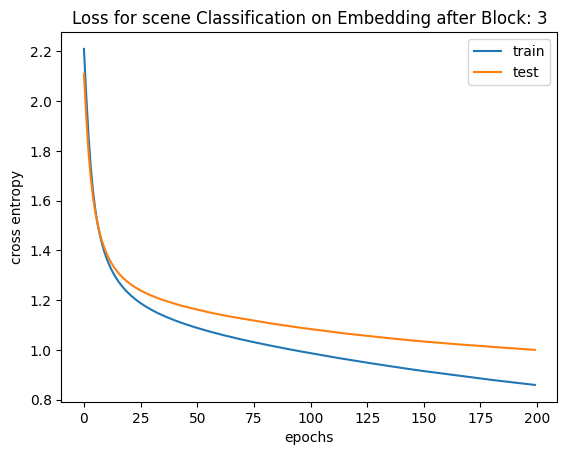

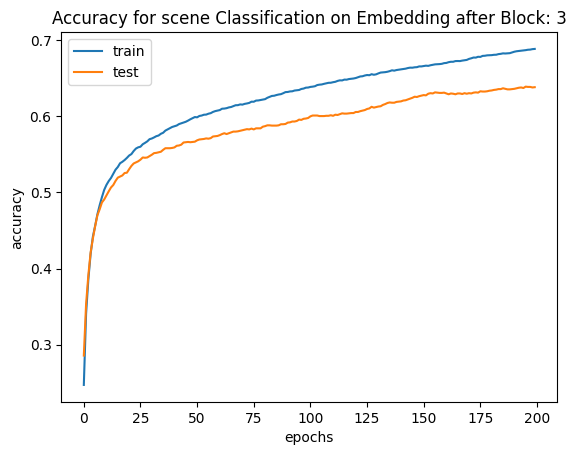

In [52]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [53]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [54]:
X_test=train_ready(test_data,col_name)

In [55]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

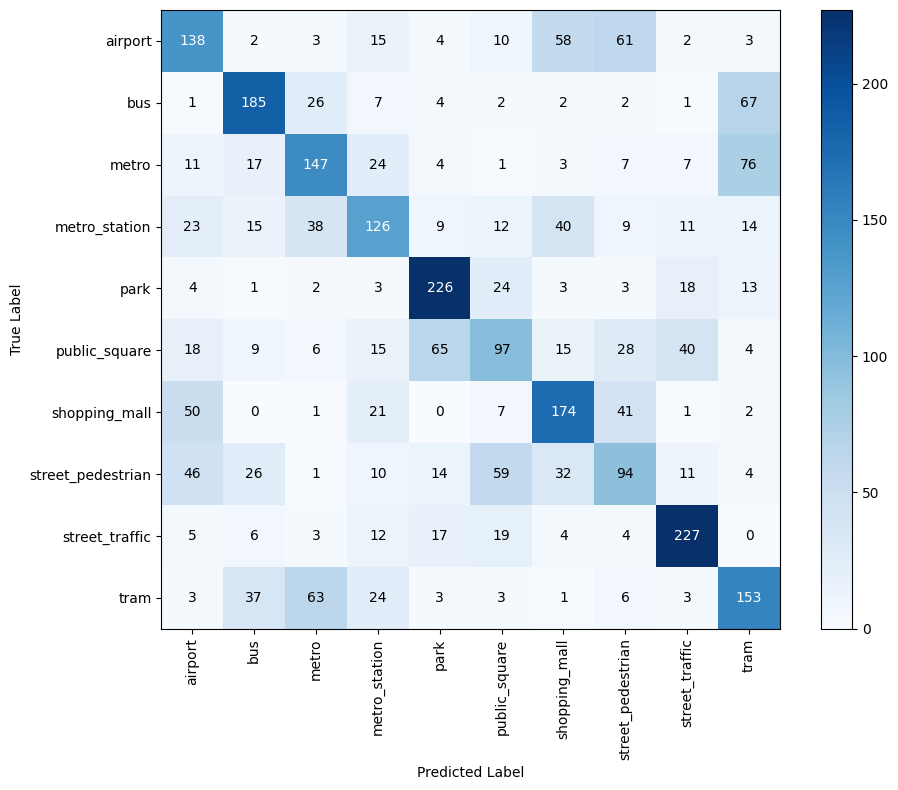

Accuracy: 0.5280


In [56]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)

# BLOCK-4

In [57]:
Block_number=4

In [58]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [59]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [60]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


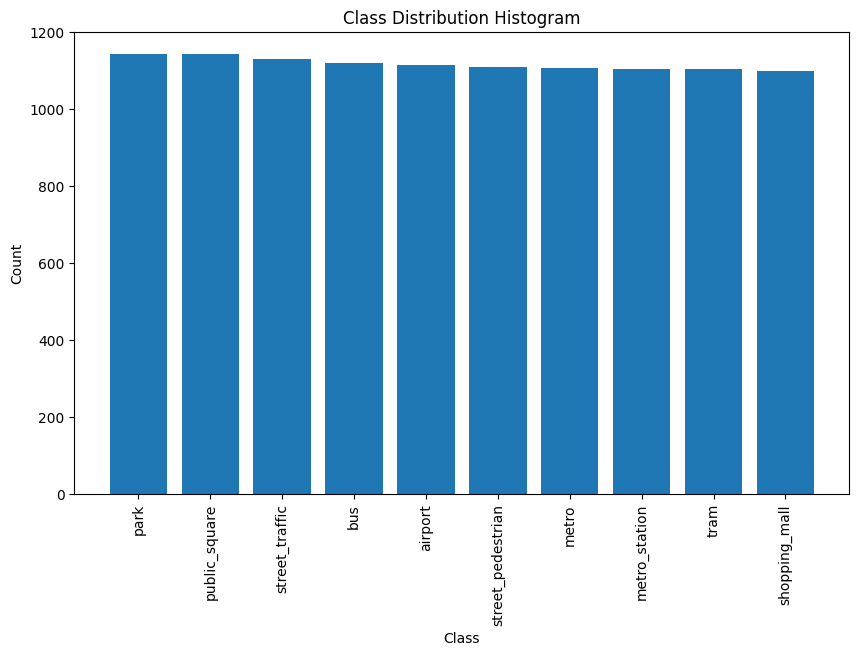

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [61]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


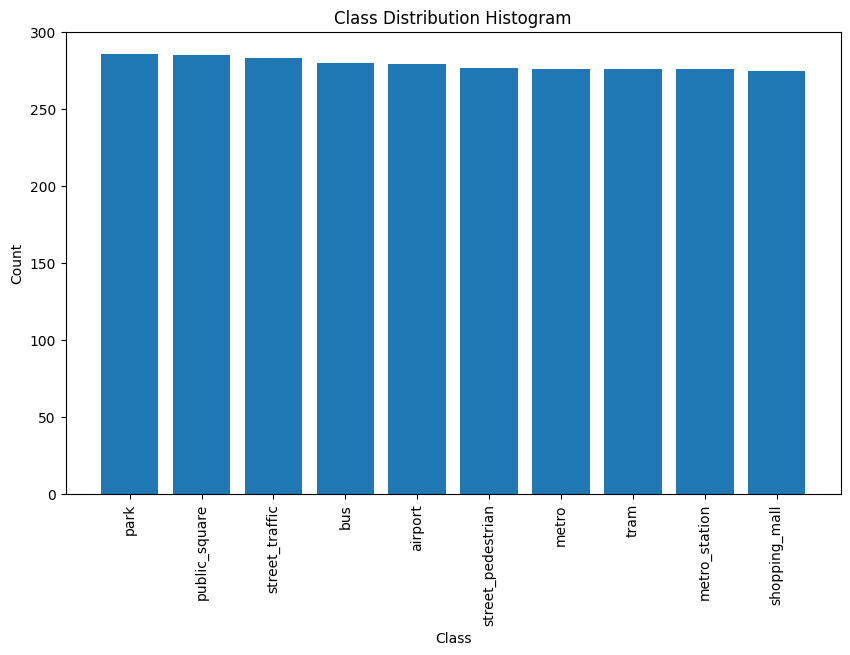

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [62]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [63]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [64]:
X_train_tensor.shape

torch.Size([11169, 768])

In [65]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 327.76batch/s, acc=0.406, loss=1.96]


Epoch 0 validation: Cross-entropy=1.97, Accuracy=38.5%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 428.25batch/s, acc=0.453, loss=1.66]


Epoch 1 validation: Cross-entropy=1.68, Accuracy=45.5%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 427.62batch/s, acc=0.5, loss=1.47]  


Epoch 2 validation: Cross-entropy=1.49, Accuracy=48.9%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 477.68batch/s, acc=0.5, loss=1.36]  


Epoch 3 validation: Cross-entropy=1.38, Accuracy=51.7%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 424.75batch/s, acc=0.516, loss=1.29]


Epoch 4 validation: Cross-entropy=1.30, Accuracy=54.0%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 369.07batch/s, acc=0.531, loss=1.25]


Epoch 5 validation: Cross-entropy=1.25, Accuracy=55.0%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 421.35batch/s, acc=0.516, loss=1.21]


Epoch 6 validation: Cross-entropy=1.21, Accuracy=56.1%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 480.13batch/s, acc=0.516, loss=1.19] 


Epoch 7 validation: Cross-entropy=1.18, Accuracy=57.4%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 422.40batch/s, acc=0.5, loss=1.17]   


Epoch 8 validation: Cross-entropy=1.15, Accuracy=58.1%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 418.98batch/s, acc=0.5, loss=1.15]   


Epoch 9 validation: Cross-entropy=1.13, Accuracy=58.4%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 400.49batch/s, acc=0.5, loss=1.14]   


Epoch 10 validation: Cross-entropy=1.12, Accuracy=58.9%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 416.92batch/s, acc=0.5, loss=1.13]   


Epoch 11 validation: Cross-entropy=1.10, Accuracy=59.2%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 431.03batch/s, acc=0.531, loss=1.12] 


Epoch 12 validation: Cross-entropy=1.09, Accuracy=59.5%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 419.23batch/s, acc=0.516, loss=1.11] 


Epoch 13 validation: Cross-entropy=1.08, Accuracy=59.8%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 386.66batch/s, acc=0.516, loss=1.1]  


Epoch 14 validation: Cross-entropy=1.07, Accuracy=60.1%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 423.28batch/s, acc=0.516, loss=1.09] 


Epoch 15 validation: Cross-entropy=1.06, Accuracy=60.4%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 311.84batch/s, acc=0.531, loss=1.08] 


Epoch 16 validation: Cross-entropy=1.05, Accuracy=60.7%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 330.47batch/s, acc=0.547, loss=1.08] 


Epoch 17 validation: Cross-entropy=1.05, Accuracy=60.9%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 398.04batch/s, acc=0.547, loss=1.07] 


Epoch 18 validation: Cross-entropy=1.04, Accuracy=61.0%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 328.15batch/s, acc=0.562, loss=1.06] 


Epoch 19 validation: Cross-entropy=1.03, Accuracy=61.2%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 325.26batch/s, acc=0.562, loss=1.06] 


Epoch 20 validation: Cross-entropy=1.03, Accuracy=61.6%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 342.83batch/s, acc=0.562, loss=1.05] 


Epoch 21 validation: Cross-entropy=1.02, Accuracy=61.8%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 398.65batch/s, acc=0.578, loss=1.04] 


Epoch 22 validation: Cross-entropy=1.02, Accuracy=61.9%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 303.78batch/s, acc=0.578, loss=1.04] 


Epoch 23 validation: Cross-entropy=1.01, Accuracy=62.3%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 348.11batch/s, acc=0.594, loss=1.03] 


Epoch 24 validation: Cross-entropy=1.01, Accuracy=62.7%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 412.50batch/s, acc=0.609, loss=1.03] 


Epoch 25 validation: Cross-entropy=1.00, Accuracy=62.7%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 365.16batch/s, acc=0.609, loss=1.02] 


Epoch 26 validation: Cross-entropy=1.00, Accuracy=62.8%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 350.95batch/s, acc=0.609, loss=1.02] 


Epoch 27 validation: Cross-entropy=1.00, Accuracy=62.8%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 381.67batch/s, acc=0.609, loss=1.02] 


Epoch 28 validation: Cross-entropy=0.99, Accuracy=62.8%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 355.25batch/s, acc=0.625, loss=1.01] 


Epoch 29 validation: Cross-entropy=0.99, Accuracy=62.9%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 368.78batch/s, acc=0.625, loss=1.01] 


Epoch 30 validation: Cross-entropy=0.98, Accuracy=63.1%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 367.79batch/s, acc=0.641, loss=1]    


Epoch 31 validation: Cross-entropy=0.98, Accuracy=63.1%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 425.85batch/s, acc=0.641, loss=0.998]


Epoch 32 validation: Cross-entropy=0.98, Accuracy=63.3%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 335.57batch/s, acc=0.641, loss=0.994]


Epoch 33 validation: Cross-entropy=0.97, Accuracy=63.4%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 355.59batch/s, acc=0.641, loss=0.99] 


Epoch 34 validation: Cross-entropy=0.97, Accuracy=63.7%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 411.84batch/s, acc=0.641, loss=0.985]


Epoch 35 validation: Cross-entropy=0.97, Accuracy=63.8%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 366.60batch/s, acc=0.641, loss=0.982]


Epoch 36 validation: Cross-entropy=0.97, Accuracy=63.9%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 377.03batch/s, acc=0.641, loss=0.978]


Epoch 37 validation: Cross-entropy=0.96, Accuracy=64.1%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 362.73batch/s, acc=0.641, loss=0.974]


Epoch 38 validation: Cross-entropy=0.96, Accuracy=64.2%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 367.50batch/s, acc=0.641, loss=0.97] 


Epoch 39 validation: Cross-entropy=0.96, Accuracy=64.3%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 367.00batch/s, acc=0.656, loss=0.966]


Epoch 40 validation: Cross-entropy=0.95, Accuracy=64.5%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 428.27batch/s, acc=0.656, loss=0.962]


Epoch 41 validation: Cross-entropy=0.95, Accuracy=64.5%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 324.76batch/s, acc=0.656, loss=0.959]


Epoch 42 validation: Cross-entropy=0.95, Accuracy=64.4%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 357.41batch/s, acc=0.656, loss=0.956]


Epoch 43 validation: Cross-entropy=0.95, Accuracy=64.5%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 369.51batch/s, acc=0.656, loss=0.952]


Epoch 44 validation: Cross-entropy=0.95, Accuracy=64.6%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 408.74batch/s, acc=0.656, loss=0.949]


Epoch 45 validation: Cross-entropy=0.94, Accuracy=64.6%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 370.85batch/s, acc=0.656, loss=0.945]


Epoch 46 validation: Cross-entropy=0.94, Accuracy=64.7%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 324.67batch/s, acc=0.656, loss=0.942]


Epoch 47 validation: Cross-entropy=0.94, Accuracy=64.7%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 437.11batch/s, acc=0.656, loss=0.939]


Epoch 48 validation: Cross-entropy=0.94, Accuracy=64.6%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 375.54batch/s, acc=0.656, loss=0.936]


Epoch 49 validation: Cross-entropy=0.93, Accuracy=64.7%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 366.22batch/s, acc=0.656, loss=0.933]


Epoch 50 validation: Cross-entropy=0.93, Accuracy=64.7%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 379.98batch/s, acc=0.656, loss=0.929]


Epoch 51 validation: Cross-entropy=0.93, Accuracy=64.7%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 377.16batch/s, acc=0.656, loss=0.927]


Epoch 52 validation: Cross-entropy=0.93, Accuracy=64.6%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 389.09batch/s, acc=0.656, loss=0.924]


Epoch 53 validation: Cross-entropy=0.93, Accuracy=64.6%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 446.85batch/s, acc=0.656, loss=0.921]


Epoch 54 validation: Cross-entropy=0.93, Accuracy=64.7%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 381.33batch/s, acc=0.672, loss=0.917]


Epoch 55 validation: Cross-entropy=0.92, Accuracy=64.7%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 329.21batch/s, acc=0.672, loss=0.914]


Epoch 56 validation: Cross-entropy=0.92, Accuracy=64.8%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 378.86batch/s, acc=0.672, loss=0.911]


Epoch 57 validation: Cross-entropy=0.92, Accuracy=65.0%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 435.90batch/s, acc=0.672, loss=0.908]


Epoch 58 validation: Cross-entropy=0.92, Accuracy=65.2%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 372.96batch/s, acc=0.688, loss=0.905]


Epoch 59 validation: Cross-entropy=0.92, Accuracy=65.2%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 332.61batch/s, acc=0.688, loss=0.902]


Epoch 60 validation: Cross-entropy=0.92, Accuracy=65.2%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 436.61batch/s, acc=0.703, loss=0.899]


Epoch 61 validation: Cross-entropy=0.91, Accuracy=65.2%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 365.76batch/s, acc=0.703, loss=0.896]


Epoch 62 validation: Cross-entropy=0.91, Accuracy=65.3%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 373.01batch/s, acc=0.719, loss=0.894]


Epoch 63 validation: Cross-entropy=0.91, Accuracy=65.2%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 432.86batch/s, acc=0.719, loss=0.891]


Epoch 64 validation: Cross-entropy=0.91, Accuracy=65.2%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 322.80batch/s, acc=0.719, loss=0.888]


Epoch 65 validation: Cross-entropy=0.91, Accuracy=65.2%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 369.48batch/s, acc=0.719, loss=0.886]


Epoch 66 validation: Cross-entropy=0.91, Accuracy=65.3%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 387.37batch/s, acc=0.719, loss=0.883]


Epoch 67 validation: Cross-entropy=0.91, Accuracy=65.3%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 435.78batch/s, acc=0.719, loss=0.879]


Epoch 68 validation: Cross-entropy=0.90, Accuracy=65.4%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 324.47batch/s, acc=0.734, loss=0.877]


Epoch 69 validation: Cross-entropy=0.90, Accuracy=65.6%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 370.95batch/s, acc=0.734, loss=0.874]


Epoch 70 validation: Cross-entropy=0.90, Accuracy=65.8%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 428.43batch/s, acc=0.734, loss=0.872]


Epoch 71 validation: Cross-entropy=0.90, Accuracy=65.9%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 379.72batch/s, acc=0.734, loss=0.869]


Epoch 72 validation: Cross-entropy=0.90, Accuracy=65.9%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 366.09batch/s, acc=0.734, loss=0.866]


Epoch 73 validation: Cross-entropy=0.90, Accuracy=66.0%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 393.22batch/s, acc=0.734, loss=0.864]


Epoch 74 validation: Cross-entropy=0.90, Accuracy=66.1%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 371.84batch/s, acc=0.734, loss=0.862]


Epoch 75 validation: Cross-entropy=0.89, Accuracy=66.2%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 368.73batch/s, acc=0.734, loss=0.859]


Epoch 76 validation: Cross-entropy=0.89, Accuracy=66.2%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 439.16batch/s, acc=0.734, loss=0.856]


Epoch 77 validation: Cross-entropy=0.89, Accuracy=66.1%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 329.84batch/s, acc=0.734, loss=0.853]


Epoch 78 validation: Cross-entropy=0.89, Accuracy=66.2%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 373.14batch/s, acc=0.734, loss=0.851]


Epoch 79 validation: Cross-entropy=0.89, Accuracy=66.3%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 441.36batch/s, acc=0.734, loss=0.848]


Epoch 80 validation: Cross-entropy=0.89, Accuracy=66.3%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 377.18batch/s, acc=0.734, loss=0.846]


Epoch 81 validation: Cross-entropy=0.89, Accuracy=66.3%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 327.18batch/s, acc=0.734, loss=0.844]


Epoch 82 validation: Cross-entropy=0.89, Accuracy=66.3%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 379.58batch/s, acc=0.734, loss=0.841]


Epoch 83 validation: Cross-entropy=0.88, Accuracy=66.3%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 431.81batch/s, acc=0.734, loss=0.839]


Epoch 84 validation: Cross-entropy=0.88, Accuracy=66.3%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 383.79batch/s, acc=0.734, loss=0.836]


Epoch 85 validation: Cross-entropy=0.88, Accuracy=66.4%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 375.97batch/s, acc=0.734, loss=0.834]


Epoch 86 validation: Cross-entropy=0.88, Accuracy=66.4%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 360.51batch/s, acc=0.734, loss=0.832]


Epoch 87 validation: Cross-entropy=0.88, Accuracy=66.4%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 368.95batch/s, acc=0.734, loss=0.829]


Epoch 88 validation: Cross-entropy=0.88, Accuracy=66.3%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 376.80batch/s, acc=0.75, loss=0.828] 


Epoch 89 validation: Cross-entropy=0.88, Accuracy=66.4%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 422.97batch/s, acc=0.75, loss=0.826] 


Epoch 90 validation: Cross-entropy=0.88, Accuracy=66.4%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 326.54batch/s, acc=0.75, loss=0.824] 


Epoch 91 validation: Cross-entropy=0.88, Accuracy=66.5%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 370.44batch/s, acc=0.75, loss=0.822] 


Epoch 92 validation: Cross-entropy=0.87, Accuracy=66.5%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 406.73batch/s, acc=0.75, loss=0.819] 


Epoch 93 validation: Cross-entropy=0.87, Accuracy=66.5%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 371.79batch/s, acc=0.75, loss=0.816] 


Epoch 94 validation: Cross-entropy=0.87, Accuracy=66.6%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 335.64batch/s, acc=0.75, loss=0.814] 


Epoch 95 validation: Cross-entropy=0.87, Accuracy=66.7%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 410.45batch/s, acc=0.75, loss=0.812] 


Epoch 96 validation: Cross-entropy=0.87, Accuracy=66.7%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 362.28batch/s, acc=0.75, loss=0.81]  


Epoch 97 validation: Cross-entropy=0.87, Accuracy=66.7%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 366.09batch/s, acc=0.75, loss=0.808] 


Epoch 98 validation: Cross-entropy=0.87, Accuracy=66.7%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 373.61batch/s, acc=0.734, loss=0.806]


Epoch 99 validation: Cross-entropy=0.87, Accuracy=66.7%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 367.50batch/s, acc=0.734, loss=0.804]


Epoch 100 validation: Cross-entropy=0.87, Accuracy=66.8%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 376.65batch/s, acc=0.75, loss=0.802] 


Epoch 101 validation: Cross-entropy=0.87, Accuracy=66.8%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 353.02batch/s, acc=0.75, loss=0.8]   


Epoch 102 validation: Cross-entropy=0.86, Accuracy=66.9%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 418.52batch/s, acc=0.75, loss=0.798] 


Epoch 103 validation: Cross-entropy=0.86, Accuracy=66.7%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 321.88batch/s, acc=0.75, loss=0.796] 


Epoch 104 validation: Cross-entropy=0.86, Accuracy=66.7%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 360.41batch/s, acc=0.75, loss=0.794] 


Epoch 105 validation: Cross-entropy=0.86, Accuracy=66.7%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 434.27batch/s, acc=0.75, loss=0.793] 


Epoch 106 validation: Cross-entropy=0.86, Accuracy=66.8%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 368.63batch/s, acc=0.75, loss=0.79]  


Epoch 107 validation: Cross-entropy=0.86, Accuracy=66.9%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 327.21batch/s, acc=0.75, loss=0.788] 


Epoch 108 validation: Cross-entropy=0.86, Accuracy=67.0%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 376.63batch/s, acc=0.75, loss=0.786] 


Epoch 109 validation: Cross-entropy=0.86, Accuracy=67.1%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 419.42batch/s, acc=0.75, loss=0.785] 


Epoch 110 validation: Cross-entropy=0.86, Accuracy=67.2%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 370.53batch/s, acc=0.75, loss=0.784] 


Epoch 111 validation: Cross-entropy=0.86, Accuracy=67.2%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 368.98batch/s, acc=0.75, loss=0.782] 


Epoch 112 validation: Cross-entropy=0.85, Accuracy=67.3%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 363.19batch/s, acc=0.75, loss=0.78]  


Epoch 113 validation: Cross-entropy=0.85, Accuracy=67.4%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 369.95batch/s, acc=0.75, loss=0.779] 


Epoch 114 validation: Cross-entropy=0.85, Accuracy=67.3%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 376.40batch/s, acc=0.75, loss=0.777] 


Epoch 115 validation: Cross-entropy=0.85, Accuracy=67.5%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 410.50batch/s, acc=0.75, loss=0.775] 


Epoch 116 validation: Cross-entropy=0.85, Accuracy=67.5%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 325.21batch/s, acc=0.75, loss=0.773] 


Epoch 117 validation: Cross-entropy=0.85, Accuracy=67.5%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 370.94batch/s, acc=0.75, loss=0.772] 


Epoch 118 validation: Cross-entropy=0.85, Accuracy=67.5%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 426.40batch/s, acc=0.75, loss=0.77]  


Epoch 119 validation: Cross-entropy=0.85, Accuracy=67.5%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 364.76batch/s, acc=0.75, loss=0.769] 


Epoch 120 validation: Cross-entropy=0.85, Accuracy=67.5%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 322.59batch/s, acc=0.75, loss=0.767] 


Epoch 121 validation: Cross-entropy=0.85, Accuracy=67.5%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 386.36batch/s, acc=0.75, loss=0.766] 


Epoch 122 validation: Cross-entropy=0.85, Accuracy=67.5%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 408.02batch/s, acc=0.75, loss=0.765] 


Epoch 123 validation: Cross-entropy=0.85, Accuracy=67.4%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 376.75batch/s, acc=0.75, loss=0.763] 


Epoch 124 validation: Cross-entropy=0.84, Accuracy=67.4%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 389.74batch/s, acc=0.75, loss=0.762] 


Epoch 125 validation: Cross-entropy=0.84, Accuracy=67.5%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 361.85batch/s, acc=0.75, loss=0.76]  


Epoch 126 validation: Cross-entropy=0.84, Accuracy=67.6%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 368.81batch/s, acc=0.75, loss=0.759] 


Epoch 127 validation: Cross-entropy=0.84, Accuracy=67.6%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 388.84batch/s, acc=0.75, loss=0.758] 


Epoch 128 validation: Cross-entropy=0.84, Accuracy=67.6%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 433.63batch/s, acc=0.75, loss=0.757] 


Epoch 129 validation: Cross-entropy=0.84, Accuracy=67.7%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 319.36batch/s, acc=0.75, loss=0.755] 


Epoch 130 validation: Cross-entropy=0.84, Accuracy=67.8%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 374.97batch/s, acc=0.75, loss=0.754] 


Epoch 131 validation: Cross-entropy=0.84, Accuracy=67.8%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 429.43batch/s, acc=0.766, loss=0.752]


Epoch 132 validation: Cross-entropy=0.84, Accuracy=68.0%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 373.80batch/s, acc=0.766, loss=0.751]


Epoch 133 validation: Cross-entropy=0.84, Accuracy=67.9%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 318.25batch/s, acc=0.766, loss=0.749]


Epoch 134 validation: Cross-entropy=0.84, Accuracy=68.0%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 359.19batch/s, acc=0.766, loss=0.748]


Epoch 135 validation: Cross-entropy=0.84, Accuracy=68.1%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 429.01batch/s, acc=0.766, loss=0.747]


Epoch 136 validation: Cross-entropy=0.84, Accuracy=68.1%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 355.09batch/s, acc=0.766, loss=0.746]


Epoch 137 validation: Cross-entropy=0.83, Accuracy=68.1%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 332.55batch/s, acc=0.766, loss=0.744]


Epoch 138 validation: Cross-entropy=0.83, Accuracy=68.2%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 429.13batch/s, acc=0.766, loss=0.743]


Epoch 139 validation: Cross-entropy=0.83, Accuracy=68.2%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 371.17batch/s, acc=0.766, loss=0.741]


Epoch 140 validation: Cross-entropy=0.83, Accuracy=68.2%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 369.80batch/s, acc=0.766, loss=0.74] 


Epoch 141 validation: Cross-entropy=0.83, Accuracy=68.3%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 425.35batch/s, acc=0.766, loss=0.739]


Epoch 142 validation: Cross-entropy=0.83, Accuracy=68.4%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 321.84batch/s, acc=0.766, loss=0.737]


Epoch 143 validation: Cross-entropy=0.83, Accuracy=68.4%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 363.77batch/s, acc=0.766, loss=0.735]


Epoch 144 validation: Cross-entropy=0.83, Accuracy=68.5%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 439.36batch/s, acc=0.766, loss=0.734]


Epoch 145 validation: Cross-entropy=0.83, Accuracy=68.5%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 362.97batch/s, acc=0.766, loss=0.734]


Epoch 146 validation: Cross-entropy=0.83, Accuracy=68.5%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 317.45batch/s, acc=0.766, loss=0.732]


Epoch 147 validation: Cross-entropy=0.83, Accuracy=68.6%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 422.95batch/s, acc=0.766, loss=0.731]


Epoch 148 validation: Cross-entropy=0.83, Accuracy=68.6%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 375.17batch/s, acc=0.766, loss=0.731]


Epoch 149 validation: Cross-entropy=0.83, Accuracy=68.6%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 388.55batch/s, acc=0.766, loss=0.73] 


Epoch 150 validation: Cross-entropy=0.82, Accuracy=68.7%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 321.98batch/s, acc=0.766, loss=0.729]


Epoch 151 validation: Cross-entropy=0.82, Accuracy=68.7%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 410.32batch/s, acc=0.766, loss=0.727]


Epoch 152 validation: Cross-entropy=0.82, Accuracy=68.7%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 359.26batch/s, acc=0.766, loss=0.726]


Epoch 153 validation: Cross-entropy=0.82, Accuracy=68.8%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 369.08batch/s, acc=0.766, loss=0.725]


Epoch 154 validation: Cross-entropy=0.82, Accuracy=69.0%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 365.16batch/s, acc=0.766, loss=0.724]


Epoch 155 validation: Cross-entropy=0.82, Accuracy=69.0%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 356.02batch/s, acc=0.766, loss=0.723]


Epoch 156 validation: Cross-entropy=0.82, Accuracy=69.2%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 370.07batch/s, acc=0.766, loss=0.722]


Epoch 157 validation: Cross-entropy=0.82, Accuracy=69.2%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 431.11batch/s, acc=0.766, loss=0.721]


Epoch 158 validation: Cross-entropy=0.82, Accuracy=69.1%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 320.92batch/s, acc=0.766, loss=0.719]


Epoch 159 validation: Cross-entropy=0.82, Accuracy=69.2%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 357.81batch/s, acc=0.766, loss=0.719]


Epoch 160 validation: Cross-entropy=0.82, Accuracy=69.2%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 366.81batch/s, acc=0.766, loss=0.718]


Epoch 161 validation: Cross-entropy=0.82, Accuracy=69.2%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 428.94batch/s, acc=0.766, loss=0.717]


Epoch 162 validation: Cross-entropy=0.82, Accuracy=69.2%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 369.19batch/s, acc=0.766, loss=0.716]


Epoch 163 validation: Cross-entropy=0.82, Accuracy=69.2%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 323.37batch/s, acc=0.766, loss=0.716]


Epoch 164 validation: Cross-entropy=0.82, Accuracy=69.2%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 427.89batch/s, acc=0.766, loss=0.715]


Epoch 165 validation: Cross-entropy=0.81, Accuracy=69.3%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 353.93batch/s, acc=0.781, loss=0.713]


Epoch 166 validation: Cross-entropy=0.81, Accuracy=69.4%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 360.97batch/s, acc=0.781, loss=0.713]


Epoch 167 validation: Cross-entropy=0.81, Accuracy=69.4%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 361.61batch/s, acc=0.781, loss=0.712]


Epoch 168 validation: Cross-entropy=0.81, Accuracy=69.5%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 362.07batch/s, acc=0.781, loss=0.711]


Epoch 169 validation: Cross-entropy=0.81, Accuracy=69.5%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 366.72batch/s, acc=0.781, loss=0.71] 


Epoch 170 validation: Cross-entropy=0.81, Accuracy=69.5%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 374.46batch/s, acc=0.781, loss=0.708]


Epoch 171 validation: Cross-entropy=0.81, Accuracy=69.6%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 366.18batch/s, acc=0.781, loss=0.707]


Epoch 172 validation: Cross-entropy=0.81, Accuracy=69.6%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 371.12batch/s, acc=0.781, loss=0.707]


Epoch 173 validation: Cross-entropy=0.81, Accuracy=69.5%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 362.42batch/s, acc=0.781, loss=0.705]


Epoch 174 validation: Cross-entropy=0.81, Accuracy=69.6%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 406.48batch/s, acc=0.781, loss=0.704]


Epoch 175 validation: Cross-entropy=0.81, Accuracy=69.6%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 318.82batch/s, acc=0.781, loss=0.703]


Epoch 176 validation: Cross-entropy=0.81, Accuracy=69.7%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 360.60batch/s, acc=0.781, loss=0.702]


Epoch 177 validation: Cross-entropy=0.81, Accuracy=69.7%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 415.70batch/s, acc=0.781, loss=0.701]


Epoch 178 validation: Cross-entropy=0.81, Accuracy=69.6%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 357.88batch/s, acc=0.781, loss=0.699]


Epoch 179 validation: Cross-entropy=0.81, Accuracy=69.7%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 320.18batch/s, acc=0.781, loss=0.698]


Epoch 180 validation: Cross-entropy=0.81, Accuracy=69.7%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 369.42batch/s, acc=0.781, loss=0.697]


Epoch 181 validation: Cross-entropy=0.81, Accuracy=69.7%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 411.10batch/s, acc=0.781, loss=0.695]


Epoch 182 validation: Cross-entropy=0.80, Accuracy=69.6%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 363.56batch/s, acc=0.781, loss=0.694]


Epoch 183 validation: Cross-entropy=0.80, Accuracy=69.8%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 358.28batch/s, acc=0.781, loss=0.694]


Epoch 184 validation: Cross-entropy=0.80, Accuracy=69.8%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 379.58batch/s, acc=0.781, loss=0.693]


Epoch 185 validation: Cross-entropy=0.80, Accuracy=69.7%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 359.74batch/s, acc=0.781, loss=0.692]


Epoch 186 validation: Cross-entropy=0.80, Accuracy=69.7%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 366.28batch/s, acc=0.781, loss=0.691]


Epoch 187 validation: Cross-entropy=0.80, Accuracy=69.8%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 422.05batch/s, acc=0.797, loss=0.69] 


Epoch 188 validation: Cross-entropy=0.80, Accuracy=69.9%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 322.03batch/s, acc=0.797, loss=0.689]


Epoch 189 validation: Cross-entropy=0.80, Accuracy=69.9%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 363.40batch/s, acc=0.797, loss=0.688]


Epoch 190 validation: Cross-entropy=0.80, Accuracy=69.9%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 421.31batch/s, acc=0.797, loss=0.687]


Epoch 191 validation: Cross-entropy=0.80, Accuracy=69.8%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 365.67batch/s, acc=0.797, loss=0.686]


Epoch 192 validation: Cross-entropy=0.80, Accuracy=69.8%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 327.62batch/s, acc=0.797, loss=0.685]


Epoch 193 validation: Cross-entropy=0.80, Accuracy=69.8%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 349.19batch/s, acc=0.781, loss=0.684]


Epoch 194 validation: Cross-entropy=0.80, Accuracy=69.9%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 419.92batch/s, acc=0.797, loss=0.683]


Epoch 195 validation: Cross-entropy=0.80, Accuracy=69.9%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 364.45batch/s, acc=0.797, loss=0.681]


Epoch 196 validation: Cross-entropy=0.80, Accuracy=69.9%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 322.55batch/s, acc=0.797, loss=0.68] 


Epoch 197 validation: Cross-entropy=0.80, Accuracy=70.0%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 407.55batch/s, acc=0.797, loss=0.679]


Epoch 198 validation: Cross-entropy=0.80, Accuracy=70.1%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 354.99batch/s, acc=0.797, loss=0.678]


Epoch 199 validation: Cross-entropy=0.80, Accuracy=70.2%


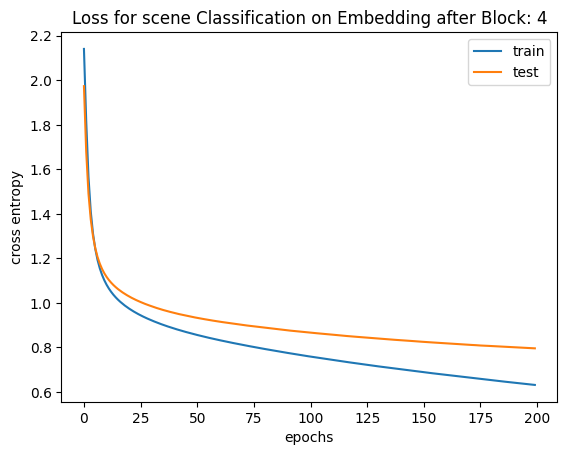

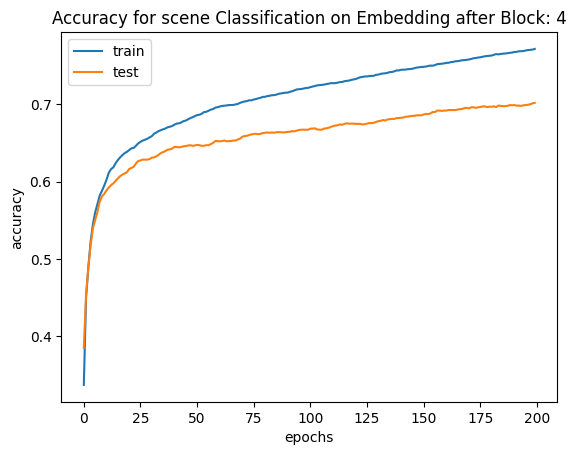

In [67]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [68]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [69]:
X_test=train_ready(test_data,col_name)

In [70]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

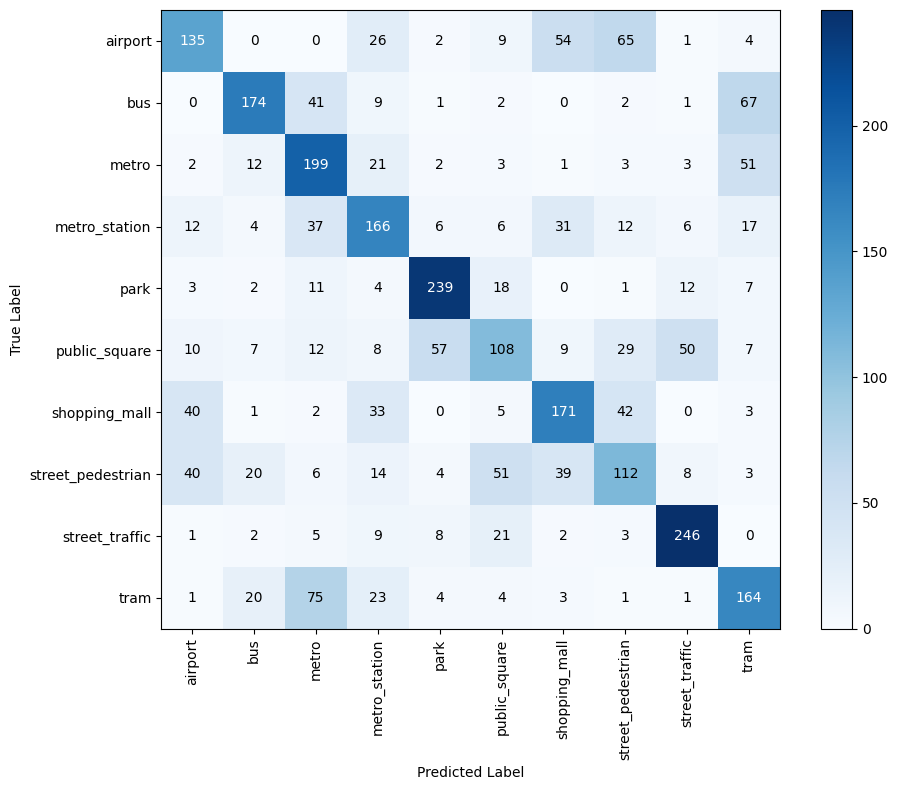

Accuracy: 0.5775


In [71]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)

# BLOCK-5

In [72]:
Block_number=5

In [73]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [74]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [75]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


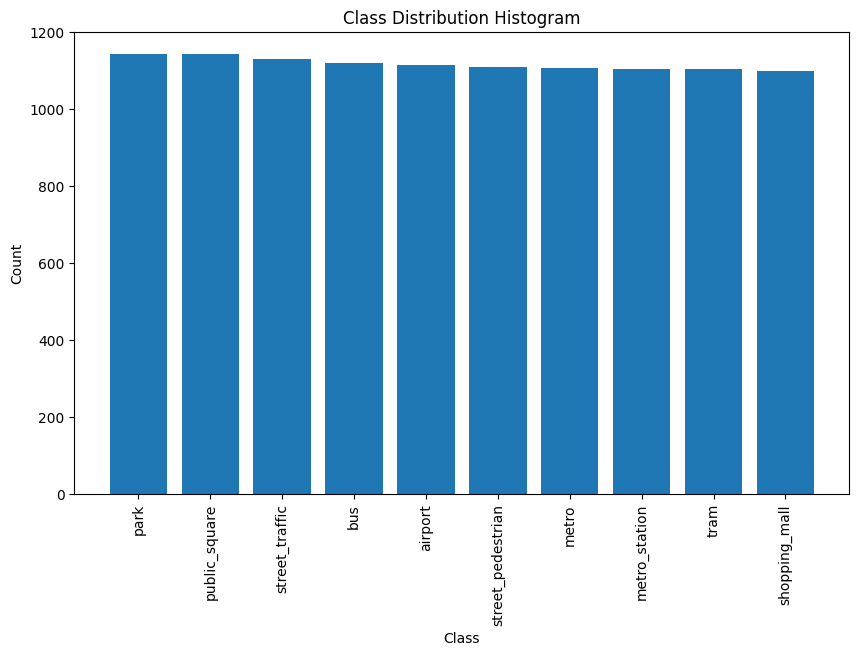

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [76]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


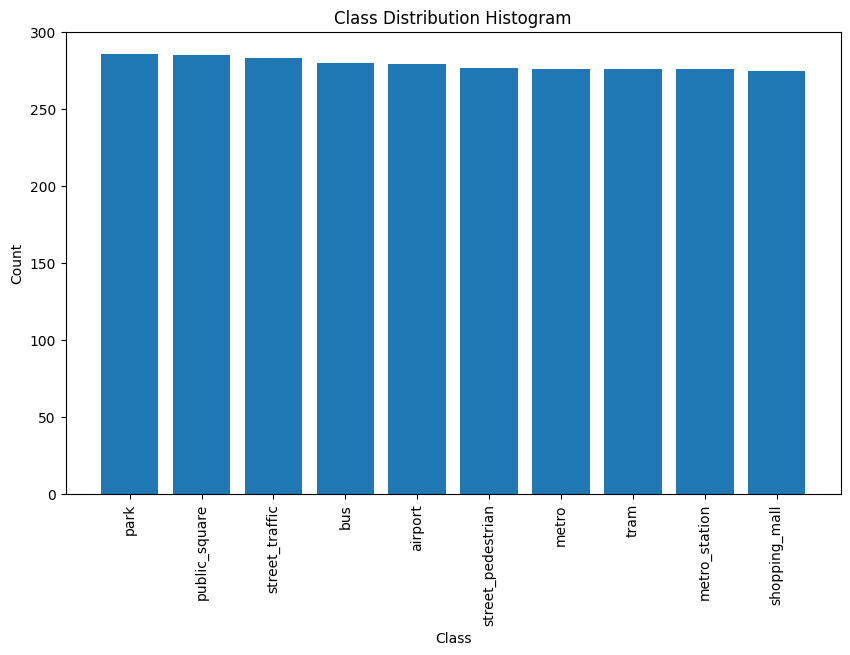

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [77]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [78]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [79]:
X_train_tensor.shape

torch.Size([11169, 768])

In [80]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 314.82batch/s, acc=0.5, loss=1.79]  


Epoch 0 validation: Cross-entropy=1.80, Accuracy=46.4%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 422.40batch/s, acc=0.625, loss=1.39]


Epoch 1 validation: Cross-entropy=1.44, Accuracy=52.6%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 475.92batch/s, acc=0.641, loss=1.2] 


Epoch 2 validation: Cross-entropy=1.26, Accuracy=56.2%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 359.83batch/s, acc=0.641, loss=1.09] 


Epoch 3 validation: Cross-entropy=1.16, Accuracy=58.6%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 477.00batch/s, acc=0.641, loss=1.03] 


Epoch 4 validation: Cross-entropy=1.10, Accuracy=60.4%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 419.42batch/s, acc=0.641, loss=0.989]


Epoch 5 validation: Cross-entropy=1.06, Accuracy=61.0%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 477.92batch/s, acc=0.656, loss=0.956]


Epoch 6 validation: Cross-entropy=1.03, Accuracy=61.5%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 428.21batch/s, acc=0.656, loss=0.931]


Epoch 7 validation: Cross-entropy=1.00, Accuracy=62.4%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 473.30batch/s, acc=0.656, loss=0.91] 


Epoch 8 validation: Cross-entropy=0.98, Accuracy=62.9%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 421.87batch/s, acc=0.656, loss=0.893]


Epoch 9 validation: Cross-entropy=0.97, Accuracy=63.5%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 369.30batch/s, acc=0.688, loss=0.876]


Epoch 10 validation: Cross-entropy=0.95, Accuracy=64.1%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 442.43batch/s, acc=0.688, loss=0.861]


Epoch 11 validation: Cross-entropy=0.94, Accuracy=64.5%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 456.10batch/s, acc=0.688, loss=0.848]


Epoch 12 validation: Cross-entropy=0.93, Accuracy=65.1%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 428.37batch/s, acc=0.719, loss=0.835]


Epoch 13 validation: Cross-entropy=0.92, Accuracy=65.3%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 425.50batch/s, acc=0.719, loss=0.824]


Epoch 14 validation: Cross-entropy=0.91, Accuracy=65.6%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 415.10batch/s, acc=0.719, loss=0.813]


Epoch 15 validation: Cross-entropy=0.90, Accuracy=65.6%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 421.68batch/s, acc=0.719, loss=0.803]


Epoch 16 validation: Cross-entropy=0.90, Accuracy=65.7%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 419.31batch/s, acc=0.703, loss=0.794]


Epoch 17 validation: Cross-entropy=0.89, Accuracy=65.8%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 421.84batch/s, acc=0.703, loss=0.785]


Epoch 18 validation: Cross-entropy=0.88, Accuracy=66.1%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 484.74batch/s, acc=0.703, loss=0.777]


Epoch 19 validation: Cross-entropy=0.88, Accuracy=66.3%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 360.02batch/s, acc=0.703, loss=0.769]


Epoch 20 validation: Cross-entropy=0.87, Accuracy=66.3%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 415.34batch/s, acc=0.719, loss=0.762]


Epoch 21 validation: Cross-entropy=0.86, Accuracy=66.6%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 415.28batch/s, acc=0.734, loss=0.756]


Epoch 22 validation: Cross-entropy=0.86, Accuracy=66.7%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 423.46batch/s, acc=0.75, loss=0.749] 


Epoch 23 validation: Cross-entropy=0.85, Accuracy=67.0%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 485.63batch/s, acc=0.75, loss=0.744] 


Epoch 24 validation: Cross-entropy=0.85, Accuracy=67.1%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 378.88batch/s, acc=0.766, loss=0.738]


Epoch 25 validation: Cross-entropy=0.85, Accuracy=67.2%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 423.16batch/s, acc=0.766, loss=0.733]


Epoch 26 validation: Cross-entropy=0.84, Accuracy=67.3%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 491.31batch/s, acc=0.766, loss=0.728]


Epoch 27 validation: Cross-entropy=0.84, Accuracy=67.7%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 429.40batch/s, acc=0.766, loss=0.723]


Epoch 28 validation: Cross-entropy=0.83, Accuracy=67.8%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 429.51batch/s, acc=0.766, loss=0.719]


Epoch 29 validation: Cross-entropy=0.83, Accuracy=68.1%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 389.15batch/s, acc=0.766, loss=0.715]


Epoch 30 validation: Cross-entropy=0.83, Accuracy=68.3%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 465.60batch/s, acc=0.766, loss=0.711]


Epoch 31 validation: Cross-entropy=0.82, Accuracy=68.5%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 429.07batch/s, acc=0.766, loss=0.706]


Epoch 32 validation: Cross-entropy=0.82, Accuracy=68.5%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 426.22batch/s, acc=0.75, loss=0.702] 


Epoch 33 validation: Cross-entropy=0.82, Accuracy=68.8%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 480.61batch/s, acc=0.766, loss=0.699]


Epoch 34 validation: Cross-entropy=0.81, Accuracy=69.0%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 428.15batch/s, acc=0.766, loss=0.695]


Epoch 35 validation: Cross-entropy=0.81, Accuracy=69.1%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 371.40batch/s, acc=0.766, loss=0.691]


Epoch 36 validation: Cross-entropy=0.81, Accuracy=69.1%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 420.76batch/s, acc=0.766, loss=0.688]


Epoch 37 validation: Cross-entropy=0.80, Accuracy=69.1%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 481.87batch/s, acc=0.766, loss=0.685]


Epoch 38 validation: Cross-entropy=0.80, Accuracy=69.2%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 430.60batch/s, acc=0.766, loss=0.682]


Epoch 39 validation: Cross-entropy=0.80, Accuracy=69.6%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 429.74batch/s, acc=0.766, loss=0.679]


Epoch 40 validation: Cross-entropy=0.80, Accuracy=69.9%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 392.55batch/s, acc=0.766, loss=0.677]


Epoch 41 validation: Cross-entropy=0.79, Accuracy=70.0%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 458.43batch/s, acc=0.766, loss=0.674]


Epoch 42 validation: Cross-entropy=0.79, Accuracy=70.0%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 422.88batch/s, acc=0.766, loss=0.671]


Epoch 43 validation: Cross-entropy=0.79, Accuracy=70.1%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 481.57batch/s, acc=0.766, loss=0.669]


Epoch 44 validation: Cross-entropy=0.79, Accuracy=70.4%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 433.14batch/s, acc=0.766, loss=0.667]


Epoch 45 validation: Cross-entropy=0.78, Accuracy=70.4%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 369.20batch/s, acc=0.766, loss=0.665]


Epoch 46 validation: Cross-entropy=0.78, Accuracy=70.5%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 456.05batch/s, acc=0.766, loss=0.662]


Epoch 47 validation: Cross-entropy=0.78, Accuracy=70.6%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 449.68batch/s, acc=0.766, loss=0.66] 


Epoch 48 validation: Cross-entropy=0.78, Accuracy=70.7%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 426.04batch/s, acc=0.766, loss=0.658]


Epoch 49 validation: Cross-entropy=0.78, Accuracy=70.8%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 429.42batch/s, acc=0.766, loss=0.656]


Epoch 50 validation: Cross-entropy=0.77, Accuracy=70.9%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 482.13batch/s, acc=0.766, loss=0.654]


Epoch 51 validation: Cross-entropy=0.77, Accuracy=71.1%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 368.91batch/s, acc=0.766, loss=0.652]


Epoch 52 validation: Cross-entropy=0.77, Accuracy=71.3%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 426.01batch/s, acc=0.75, loss=0.65]  


Epoch 53 validation: Cross-entropy=0.77, Accuracy=71.3%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 472.45batch/s, acc=0.75, loss=0.648] 


Epoch 54 validation: Cross-entropy=0.77, Accuracy=71.4%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 430.31batch/s, acc=0.75, loss=0.646] 


Epoch 55 validation: Cross-entropy=0.76, Accuracy=71.4%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 425.51batch/s, acc=0.75, loss=0.644] 


Epoch 56 validation: Cross-entropy=0.76, Accuracy=71.5%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 377.11batch/s, acc=0.75, loss=0.643] 


Epoch 57 validation: Cross-entropy=0.76, Accuracy=71.6%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 475.63batch/s, acc=0.75, loss=0.642] 


Epoch 58 validation: Cross-entropy=0.76, Accuracy=71.7%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 419.57batch/s, acc=0.75, loss=0.641] 


Epoch 59 validation: Cross-entropy=0.76, Accuracy=71.7%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 425.02batch/s, acc=0.75, loss=0.639] 


Epoch 60 validation: Cross-entropy=0.76, Accuracy=71.8%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 434.05batch/s, acc=0.75, loss=0.638] 


Epoch 61 validation: Cross-entropy=0.75, Accuracy=71.9%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 414.61batch/s, acc=0.75, loss=0.636] 


Epoch 62 validation: Cross-entropy=0.75, Accuracy=71.8%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 424.81batch/s, acc=0.75, loss=0.635] 


Epoch 63 validation: Cross-entropy=0.75, Accuracy=71.7%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 423.27batch/s, acc=0.75, loss=0.633] 


Epoch 64 validation: Cross-entropy=0.75, Accuracy=71.8%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 433.07batch/s, acc=0.75, loss=0.632] 


Epoch 65 validation: Cross-entropy=0.75, Accuracy=71.9%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 476.66batch/s, acc=0.75, loss=0.63]  


Epoch 66 validation: Cross-entropy=0.75, Accuracy=71.9%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 380.03batch/s, acc=0.75, loss=0.629] 


Epoch 67 validation: Cross-entropy=0.74, Accuracy=72.1%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 423.79batch/s, acc=0.75, loss=0.627] 


Epoch 68 validation: Cross-entropy=0.74, Accuracy=72.2%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 486.12batch/s, acc=0.766, loss=0.626]


Epoch 69 validation: Cross-entropy=0.74, Accuracy=72.2%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 423.35batch/s, acc=0.766, loss=0.625]


Epoch 70 validation: Cross-entropy=0.74, Accuracy=72.2%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 423.33batch/s, acc=0.766, loss=0.624]


Epoch 71 validation: Cross-entropy=0.74, Accuracy=72.2%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 359.39batch/s, acc=0.766, loss=0.622]


Epoch 72 validation: Cross-entropy=0.74, Accuracy=72.3%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 477.69batch/s, acc=0.766, loss=0.621]


Epoch 73 validation: Cross-entropy=0.74, Accuracy=72.4%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 425.48batch/s, acc=0.766, loss=0.619]


Epoch 74 validation: Cross-entropy=0.74, Accuracy=72.4%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 409.93batch/s, acc=0.766, loss=0.618]


Epoch 75 validation: Cross-entropy=0.73, Accuracy=72.5%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 482.84batch/s, acc=0.766, loss=0.617]


Epoch 76 validation: Cross-entropy=0.73, Accuracy=72.6%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 386.18batch/s, acc=0.766, loss=0.616]


Epoch 77 validation: Cross-entropy=0.73, Accuracy=72.7%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 421.60batch/s, acc=0.766, loss=0.615]


Epoch 78 validation: Cross-entropy=0.73, Accuracy=72.8%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 464.53batch/s, acc=0.766, loss=0.613]


Epoch 79 validation: Cross-entropy=0.73, Accuracy=72.9%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 427.40batch/s, acc=0.766, loss=0.612]


Epoch 80 validation: Cross-entropy=0.73, Accuracy=72.8%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 427.73batch/s, acc=0.766, loss=0.611]


Epoch 81 validation: Cross-entropy=0.73, Accuracy=72.9%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 426.12batch/s, acc=0.766, loss=0.609]


Epoch 82 validation: Cross-entropy=0.72, Accuracy=73.0%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 365.46batch/s, acc=0.766, loss=0.608]


Epoch 83 validation: Cross-entropy=0.72, Accuracy=73.1%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 478.32batch/s, acc=0.766, loss=0.607]


Epoch 84 validation: Cross-entropy=0.72, Accuracy=73.1%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 425.56batch/s, acc=0.766, loss=0.606]


Epoch 85 validation: Cross-entropy=0.72, Accuracy=73.2%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 488.40batch/s, acc=0.766, loss=0.605]


Epoch 86 validation: Cross-entropy=0.72, Accuracy=73.3%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 426.74batch/s, acc=0.766, loss=0.604]


Epoch 87 validation: Cross-entropy=0.72, Accuracy=73.3%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 364.96batch/s, acc=0.766, loss=0.603]


Epoch 88 validation: Cross-entropy=0.72, Accuracy=73.4%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 429.12batch/s, acc=0.766, loss=0.601]


Epoch 89 validation: Cross-entropy=0.72, Accuracy=73.4%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 480.51batch/s, acc=0.766, loss=0.6]  


Epoch 90 validation: Cross-entropy=0.72, Accuracy=73.5%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 427.33batch/s, acc=0.766, loss=0.599]


Epoch 91 validation: Cross-entropy=0.71, Accuracy=73.5%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 427.87batch/s, acc=0.781, loss=0.598]


Epoch 92 validation: Cross-entropy=0.71, Accuracy=73.6%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 417.94batch/s, acc=0.781, loss=0.597]


Epoch 93 validation: Cross-entropy=0.71, Accuracy=73.7%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 431.95batch/s, acc=0.766, loss=0.596]


Epoch 94 validation: Cross-entropy=0.71, Accuracy=73.7%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 429.61batch/s, acc=0.781, loss=0.595]


Epoch 95 validation: Cross-entropy=0.71, Accuracy=73.8%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 431.41batch/s, acc=0.781, loss=0.594]


Epoch 96 validation: Cross-entropy=0.71, Accuracy=73.8%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 477.34batch/s, acc=0.781, loss=0.594]


Epoch 97 validation: Cross-entropy=0.71, Accuracy=73.8%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 427.72batch/s, acc=0.781, loss=0.593]


Epoch 98 validation: Cross-entropy=0.71, Accuracy=74.0%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 379.16batch/s, acc=0.766, loss=0.592]


Epoch 99 validation: Cross-entropy=0.71, Accuracy=73.9%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 426.32batch/s, acc=0.75, loss=0.591] 


Epoch 100 validation: Cross-entropy=0.70, Accuracy=74.0%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 488.01batch/s, acc=0.75, loss=0.59]  


Epoch 101 validation: Cross-entropy=0.70, Accuracy=74.1%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 427.76batch/s, acc=0.75, loss=0.589] 


Epoch 102 validation: Cross-entropy=0.70, Accuracy=74.1%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 430.47batch/s, acc=0.75, loss=0.588] 


Epoch 103 validation: Cross-entropy=0.70, Accuracy=74.0%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 369.70batch/s, acc=0.75, loss=0.588] 


Epoch 104 validation: Cross-entropy=0.70, Accuracy=74.1%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 482.54batch/s, acc=0.75, loss=0.587] 


Epoch 105 validation: Cross-entropy=0.70, Accuracy=74.2%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 428.95batch/s, acc=0.75, loss=0.586] 


Epoch 106 validation: Cross-entropy=0.70, Accuracy=74.3%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 425.18batch/s, acc=0.75, loss=0.585] 


Epoch 107 validation: Cross-entropy=0.70, Accuracy=74.1%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 481.60batch/s, acc=0.75, loss=0.584] 


Epoch 108 validation: Cross-entropy=0.70, Accuracy=74.2%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 362.07batch/s, acc=0.75, loss=0.583] 


Epoch 109 validation: Cross-entropy=0.69, Accuracy=74.2%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 417.07batch/s, acc=0.75, loss=0.583] 


Epoch 110 validation: Cross-entropy=0.69, Accuracy=74.2%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 426.47batch/s, acc=0.75, loss=0.582] 


Epoch 111 validation: Cross-entropy=0.69, Accuracy=74.3%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 480.47batch/s, acc=0.75, loss=0.581] 


Epoch 112 validation: Cross-entropy=0.69, Accuracy=74.3%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 432.93batch/s, acc=0.75, loss=0.58]  


Epoch 113 validation: Cross-entropy=0.69, Accuracy=74.4%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 376.17batch/s, acc=0.75, loss=0.579] 


Epoch 114 validation: Cross-entropy=0.69, Accuracy=74.4%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 450.30batch/s, acc=0.75, loss=0.578] 


Epoch 115 validation: Cross-entropy=0.69, Accuracy=74.4%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 465.69batch/s, acc=0.75, loss=0.578] 


Epoch 116 validation: Cross-entropy=0.69, Accuracy=74.3%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 427.77batch/s, acc=0.75, loss=0.576] 


Epoch 117 validation: Cross-entropy=0.69, Accuracy=74.4%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 462.29batch/s, acc=0.75, loss=0.576] 


Epoch 118 validation: Cross-entropy=0.69, Accuracy=74.4%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 405.91batch/s, acc=0.75, loss=0.575] 


Epoch 119 validation: Cross-entropy=0.69, Accuracy=74.4%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 414.39batch/s, acc=0.75, loss=0.574] 


Epoch 120 validation: Cross-entropy=0.68, Accuracy=74.4%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 425.15batch/s, acc=0.75, loss=0.573] 


Epoch 121 validation: Cross-entropy=0.68, Accuracy=74.4%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 476.53batch/s, acc=0.75, loss=0.572] 


Epoch 122 validation: Cross-entropy=0.68, Accuracy=74.5%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 436.72batch/s, acc=0.75, loss=0.571] 


Epoch 123 validation: Cross-entropy=0.68, Accuracy=74.7%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 424.64batch/s, acc=0.75, loss=0.571] 


Epoch 124 validation: Cross-entropy=0.68, Accuracy=74.7%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 423.33batch/s, acc=0.75, loss=0.57]  


Epoch 125 validation: Cross-entropy=0.68, Accuracy=74.7%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 424.77batch/s, acc=0.75, loss=0.568] 


Epoch 126 validation: Cross-entropy=0.68, Accuracy=74.8%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 425.75batch/s, acc=0.75, loss=0.568] 


Epoch 127 validation: Cross-entropy=0.68, Accuracy=74.8%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 441.13batch/s, acc=0.75, loss=0.567] 


Epoch 128 validation: Cross-entropy=0.68, Accuracy=74.8%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 457.26batch/s, acc=0.75, loss=0.566] 


Epoch 129 validation: Cross-entropy=0.68, Accuracy=74.9%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 362.64batch/s, acc=0.75, loss=0.565] 


Epoch 130 validation: Cross-entropy=0.68, Accuracy=74.9%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 426.66batch/s, acc=0.75, loss=0.564] 


Epoch 131 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 484.72batch/s, acc=0.75, loss=0.563] 


Epoch 132 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 431.06batch/s, acc=0.75, loss=0.562] 


Epoch 133 validation: Cross-entropy=0.67, Accuracy=74.9%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 479.92batch/s, acc=0.75, loss=0.562] 


Epoch 134 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 361.79batch/s, acc=0.766, loss=0.561]


Epoch 135 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 478.38batch/s, acc=0.75, loss=0.56]  


Epoch 136 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 425.59batch/s, acc=0.766, loss=0.559]


Epoch 137 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 478.76batch/s, acc=0.766, loss=0.558]


Epoch 138 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 425.18batch/s, acc=0.766, loss=0.557]


Epoch 139 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 377.52batch/s, acc=0.766, loss=0.557]


Epoch 140 validation: Cross-entropy=0.67, Accuracy=74.9%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 427.22batch/s, acc=0.766, loss=0.556]


Epoch 141 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 483.04batch/s, acc=0.766, loss=0.555]


Epoch 142 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 422.84batch/s, acc=0.766, loss=0.554]


Epoch 143 validation: Cross-entropy=0.67, Accuracy=74.8%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 428.57batch/s, acc=0.766, loss=0.554]


Epoch 144 validation: Cross-entropy=0.66, Accuracy=74.8%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 420.04batch/s, acc=0.766, loss=0.553]


Epoch 145 validation: Cross-entropy=0.66, Accuracy=74.9%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 412.56batch/s, acc=0.766, loss=0.552]


Epoch 146 validation: Cross-entropy=0.66, Accuracy=74.9%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 427.41batch/s, acc=0.766, loss=0.551]


Epoch 147 validation: Cross-entropy=0.66, Accuracy=74.9%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 477.12batch/s, acc=0.766, loss=0.551]


Epoch 148 validation: Cross-entropy=0.66, Accuracy=75.0%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 413.94batch/s, acc=0.766, loss=0.55] 


Epoch 149 validation: Cross-entropy=0.66, Accuracy=75.1%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 376.31batch/s, acc=0.766, loss=0.548]


Epoch 150 validation: Cross-entropy=0.66, Accuracy=75.1%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 432.88batch/s, acc=0.766, loss=0.547]


Epoch 151 validation: Cross-entropy=0.66, Accuracy=75.1%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 482.92batch/s, acc=0.766, loss=0.547]


Epoch 152 validation: Cross-entropy=0.66, Accuracy=75.1%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 424.28batch/s, acc=0.766, loss=0.546]


Epoch 153 validation: Cross-entropy=0.66, Accuracy=75.1%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 426.54batch/s, acc=0.766, loss=0.545]


Epoch 154 validation: Cross-entropy=0.66, Accuracy=75.2%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 421.53batch/s, acc=0.766, loss=0.544]


Epoch 155 validation: Cross-entropy=0.66, Accuracy=75.2%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 416.81batch/s, acc=0.766, loss=0.543]


Epoch 156 validation: Cross-entropy=0.66, Accuracy=75.2%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 428.66batch/s, acc=0.781, loss=0.543]


Epoch 157 validation: Cross-entropy=0.66, Accuracy=75.2%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 414.95batch/s, acc=0.766, loss=0.542]


Epoch 158 validation: Cross-entropy=0.65, Accuracy=75.2%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 486.83batch/s, acc=0.766, loss=0.541]


Epoch 159 validation: Cross-entropy=0.65, Accuracy=75.3%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 383.17batch/s, acc=0.781, loss=0.541]


Epoch 160 validation: Cross-entropy=0.65, Accuracy=75.4%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 422.30batch/s, acc=0.781, loss=0.54] 


Epoch 161 validation: Cross-entropy=0.65, Accuracy=75.3%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 423.27batch/s, acc=0.781, loss=0.539]


Epoch 162 validation: Cross-entropy=0.65, Accuracy=75.3%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 485.36batch/s, acc=0.781, loss=0.539]


Epoch 163 validation: Cross-entropy=0.65, Accuracy=75.4%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 428.00batch/s, acc=0.781, loss=0.538]


Epoch 164 validation: Cross-entropy=0.65, Accuracy=75.5%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 426.13batch/s, acc=0.781, loss=0.537]


Epoch 165 validation: Cross-entropy=0.65, Accuracy=75.5%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 419.54batch/s, acc=0.781, loss=0.536]


Epoch 166 validation: Cross-entropy=0.65, Accuracy=75.7%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 432.36batch/s, acc=0.781, loss=0.536]


Epoch 167 validation: Cross-entropy=0.65, Accuracy=75.7%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 423.10batch/s, acc=0.781, loss=0.535]


Epoch 168 validation: Cross-entropy=0.65, Accuracy=75.8%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 425.92batch/s, acc=0.781, loss=0.534]


Epoch 169 validation: Cross-entropy=0.65, Accuracy=75.8%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 478.41batch/s, acc=0.781, loss=0.533]


Epoch 170 validation: Cross-entropy=0.65, Accuracy=75.9%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 382.30batch/s, acc=0.781, loss=0.533]


Epoch 171 validation: Cross-entropy=0.65, Accuracy=75.9%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 428.62batch/s, acc=0.781, loss=0.532]


Epoch 172 validation: Cross-entropy=0.65, Accuracy=75.9%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 449.58batch/s, acc=0.781, loss=0.531]


Epoch 173 validation: Cross-entropy=0.65, Accuracy=75.9%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 471.98batch/s, acc=0.781, loss=0.531]


Epoch 174 validation: Cross-entropy=0.64, Accuracy=75.9%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 426.78batch/s, acc=0.781, loss=0.529]


Epoch 175 validation: Cross-entropy=0.64, Accuracy=75.9%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 390.50batch/s, acc=0.781, loss=0.529]


Epoch 176 validation: Cross-entropy=0.64, Accuracy=76.0%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 456.54batch/s, acc=0.797, loss=0.528]


Epoch 177 validation: Cross-entropy=0.64, Accuracy=76.0%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 430.62batch/s, acc=0.797, loss=0.527]


Epoch 178 validation: Cross-entropy=0.64, Accuracy=76.0%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 426.95batch/s, acc=0.797, loss=0.527]


Epoch 179 validation: Cross-entropy=0.64, Accuracy=76.2%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 456.59batch/s, acc=0.797, loss=0.526]


Epoch 180 validation: Cross-entropy=0.64, Accuracy=76.2%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 388.98batch/s, acc=0.797, loss=0.525]


Epoch 181 validation: Cross-entropy=0.64, Accuracy=76.2%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 421.37batch/s, acc=0.797, loss=0.524]


Epoch 182 validation: Cross-entropy=0.64, Accuracy=76.2%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 433.86batch/s, acc=0.797, loss=0.523]


Epoch 183 validation: Cross-entropy=0.64, Accuracy=76.1%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 473.35batch/s, acc=0.812, loss=0.523]


Epoch 184 validation: Cross-entropy=0.64, Accuracy=76.1%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 424.06batch/s, acc=0.812, loss=0.522]


Epoch 185 validation: Cross-entropy=0.64, Accuracy=76.1%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 412.31batch/s, acc=0.812, loss=0.521]


Epoch 186 validation: Cross-entropy=0.64, Accuracy=76.1%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 413.70batch/s, acc=0.812, loss=0.52] 


Epoch 187 validation: Cross-entropy=0.64, Accuracy=76.2%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 430.63batch/s, acc=0.812, loss=0.52] 


Epoch 188 validation: Cross-entropy=0.64, Accuracy=76.1%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 429.29batch/s, acc=0.812, loss=0.519]


Epoch 189 validation: Cross-entropy=0.64, Accuracy=76.3%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 426.59batch/s, acc=0.812, loss=0.518]


Epoch 190 validation: Cross-entropy=0.64, Accuracy=76.4%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 481.13batch/s, acc=0.812, loss=0.517]


Epoch 191 validation: Cross-entropy=0.64, Accuracy=76.4%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 377.57batch/s, acc=0.812, loss=0.517]


Epoch 192 validation: Cross-entropy=0.63, Accuracy=76.5%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 431.79batch/s, acc=0.812, loss=0.516]


Epoch 193 validation: Cross-entropy=0.63, Accuracy=76.6%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 488.29batch/s, acc=0.812, loss=0.515]


Epoch 194 validation: Cross-entropy=0.63, Accuracy=76.8%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 420.10batch/s, acc=0.812, loss=0.514]


Epoch 195 validation: Cross-entropy=0.63, Accuracy=76.9%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 419.68batch/s, acc=0.812, loss=0.513]


Epoch 196 validation: Cross-entropy=0.63, Accuracy=76.9%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 378.20batch/s, acc=0.828, loss=0.512]


Epoch 197 validation: Cross-entropy=0.63, Accuracy=76.8%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 428.91batch/s, acc=0.828, loss=0.511]


Epoch 198 validation: Cross-entropy=0.63, Accuracy=76.8%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 487.84batch/s, acc=0.828, loss=0.51] 


Epoch 199 validation: Cross-entropy=0.63, Accuracy=76.7%


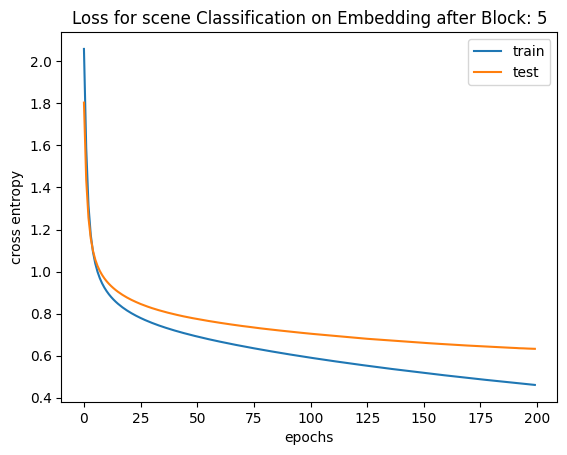

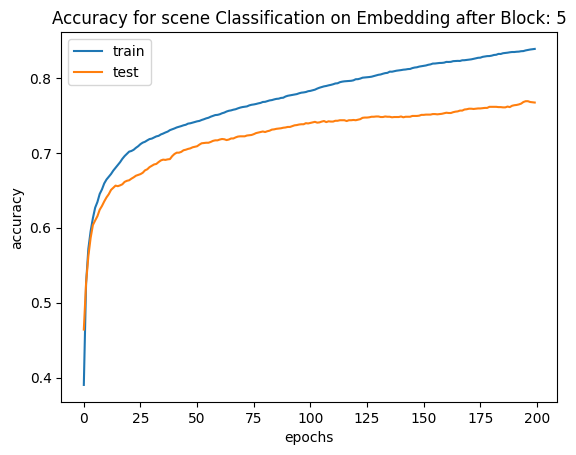

In [82]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [83]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [84]:
X_test=train_ready(test_data,col_name)

In [85]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

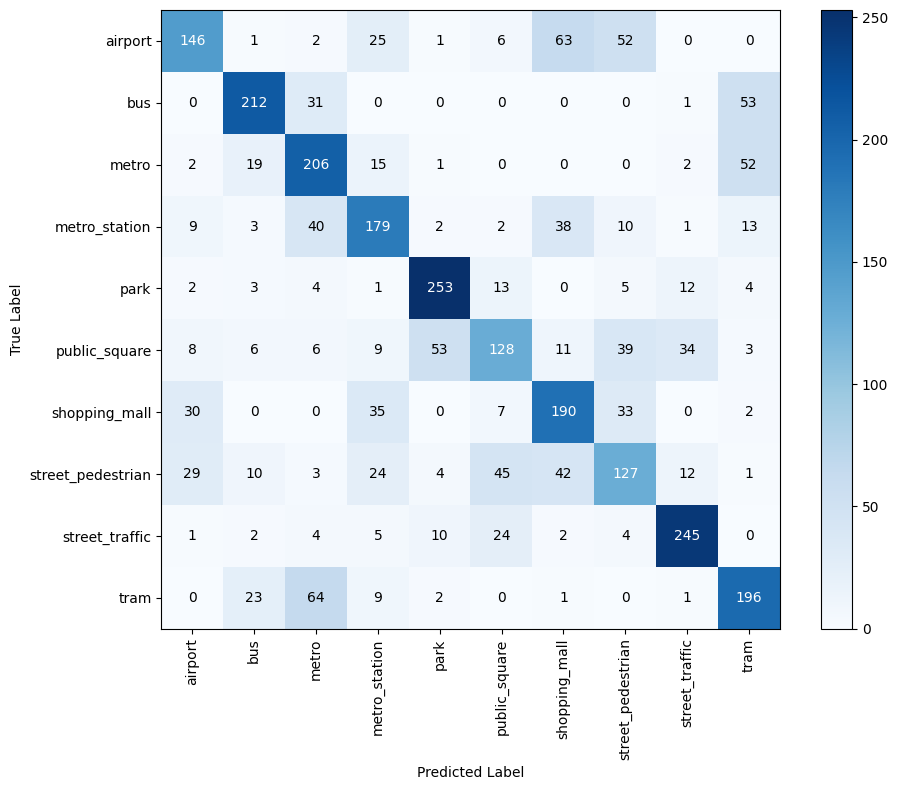

Accuracy: 0.6341


In [86]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)

# BLOCK-6

In [87]:
Block_number=6

In [88]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [89]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [90]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


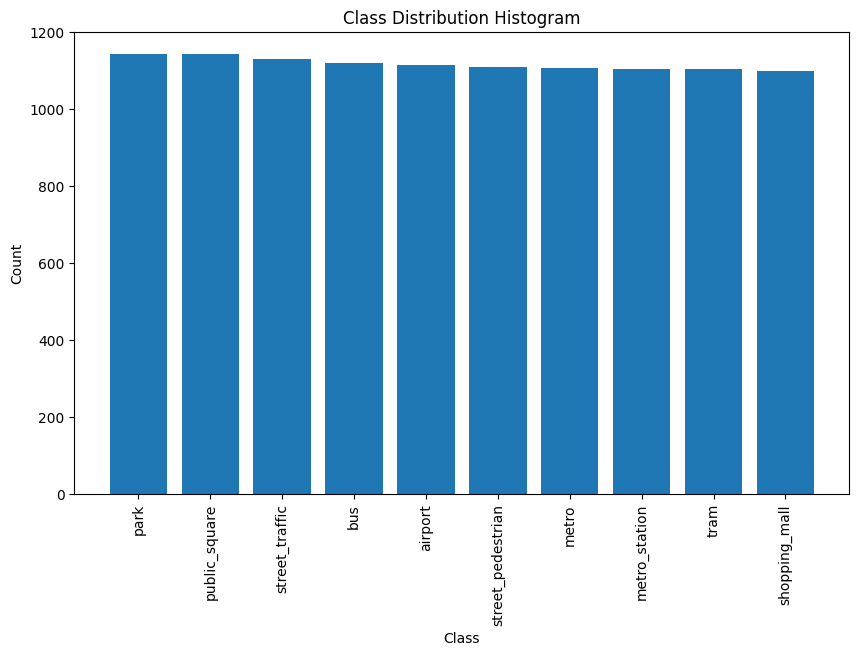

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [91]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


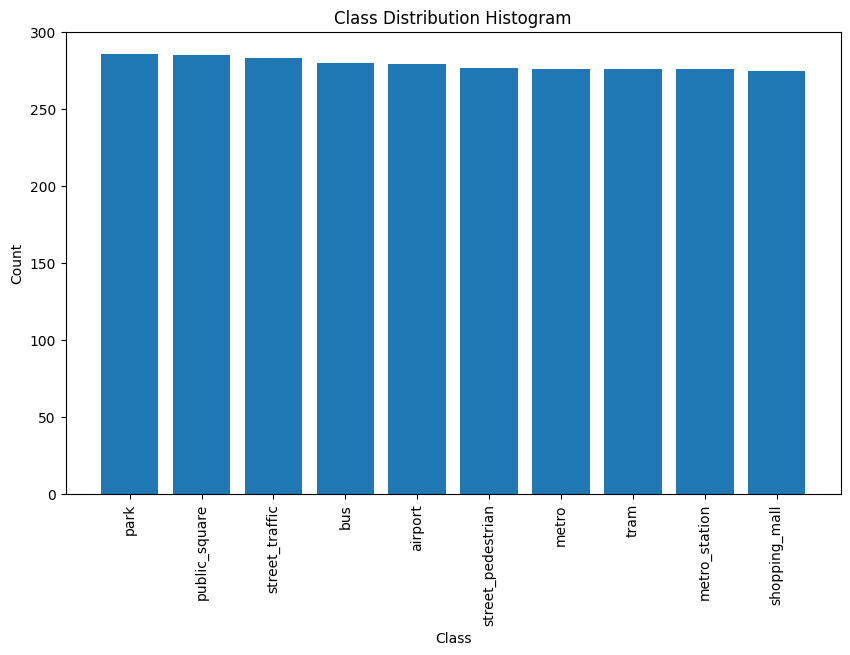

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [92]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [93]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [94]:
X_train_tensor.shape

torch.Size([11169, 768])

In [95]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 313.47batch/s, acc=0.609, loss=1.43]


Epoch 0 validation: Cross-entropy=1.43, Accuracy=58.3%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 423.09batch/s, acc=0.734, loss=1.06] 


Epoch 1 validation: Cross-entropy=1.10, Accuracy=62.2%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 414.77batch/s, acc=0.734, loss=0.909]


Epoch 2 validation: Cross-entropy=0.99, Accuracy=64.3%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 474.14batch/s, acc=0.75, loss=0.831] 


Epoch 3 validation: Cross-entropy=0.92, Accuracy=66.2%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 424.08batch/s, acc=0.766, loss=0.782]


Epoch 4 validation: Cross-entropy=0.88, Accuracy=67.1%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 358.15batch/s, acc=0.734, loss=0.747]


Epoch 5 validation: Cross-entropy=0.85, Accuracy=67.8%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 451.55batch/s, acc=0.734, loss=0.722]


Epoch 6 validation: Cross-entropy=0.83, Accuracy=68.4%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 442.43batch/s, acc=0.75, loss=0.703] 


Epoch 7 validation: Cross-entropy=0.81, Accuracy=69.1%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 418.03batch/s, acc=0.75, loss=0.688] 


Epoch 8 validation: Cross-entropy=0.80, Accuracy=69.5%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 417.82batch/s, acc=0.734, loss=0.676]


Epoch 9 validation: Cross-entropy=0.79, Accuracy=70.2%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 414.79batch/s, acc=0.734, loss=0.666]


Epoch 10 validation: Cross-entropy=0.77, Accuracy=70.8%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 417.06batch/s, acc=0.75, loss=0.658] 


Epoch 11 validation: Cross-entropy=0.76, Accuracy=71.1%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 420.28batch/s, acc=0.75, loss=0.651] 


Epoch 12 validation: Cross-entropy=0.75, Accuracy=71.3%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 469.82batch/s, acc=0.75, loss=0.646] 


Epoch 13 validation: Cross-entropy=0.75, Accuracy=71.7%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 437.55batch/s, acc=0.75, loss=0.641] 


Epoch 14 validation: Cross-entropy=0.74, Accuracy=71.9%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 417.49batch/s, acc=0.75, loss=0.638] 


Epoch 15 validation: Cross-entropy=0.73, Accuracy=72.0%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 363.59batch/s, acc=0.75, loss=0.634] 


Epoch 16 validation: Cross-entropy=0.73, Accuracy=72.4%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 468.13batch/s, acc=0.75, loss=0.632] 


Epoch 17 validation: Cross-entropy=0.72, Accuracy=72.5%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 422.58batch/s, acc=0.75, loss=0.629] 


Epoch 18 validation: Cross-entropy=0.71, Accuracy=72.6%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 420.99batch/s, acc=0.734, loss=0.627]


Epoch 19 validation: Cross-entropy=0.71, Accuracy=72.7%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 467.55batch/s, acc=0.734, loss=0.625]


Epoch 20 validation: Cross-entropy=0.71, Accuracy=73.0%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 376.35batch/s, acc=0.734, loss=0.624]


Epoch 21 validation: Cross-entropy=0.70, Accuracy=73.3%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 427.27batch/s, acc=0.734, loss=0.623]


Epoch 22 validation: Cross-entropy=0.70, Accuracy=73.2%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 426.25batch/s, acc=0.734, loss=0.621]


Epoch 23 validation: Cross-entropy=0.69, Accuracy=73.3%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 477.89batch/s, acc=0.719, loss=0.62] 


Epoch 24 validation: Cross-entropy=0.69, Accuracy=73.6%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 429.18batch/s, acc=0.719, loss=0.619]


Epoch 25 validation: Cross-entropy=0.68, Accuracy=73.6%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 376.30batch/s, acc=0.719, loss=0.618]


Epoch 26 validation: Cross-entropy=0.68, Accuracy=73.8%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 484.37batch/s, acc=0.719, loss=0.617]


Epoch 27 validation: Cross-entropy=0.68, Accuracy=73.9%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 426.17batch/s, acc=0.734, loss=0.616]


Epoch 28 validation: Cross-entropy=0.68, Accuracy=73.8%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 417.70batch/s, acc=0.734, loss=0.615]


Epoch 29 validation: Cross-entropy=0.67, Accuracy=74.0%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 462.96batch/s, acc=0.734, loss=0.614]


Epoch 30 validation: Cross-entropy=0.67, Accuracy=74.0%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 392.50batch/s, acc=0.734, loss=0.612]


Epoch 31 validation: Cross-entropy=0.67, Accuracy=74.2%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 420.82batch/s, acc=0.75, loss=0.611] 


Epoch 32 validation: Cross-entropy=0.66, Accuracy=74.4%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 433.55batch/s, acc=0.75, loss=0.611] 


Epoch 33 validation: Cross-entropy=0.66, Accuracy=74.7%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 476.24batch/s, acc=0.75, loss=0.61]  


Epoch 34 validation: Cross-entropy=0.66, Accuracy=74.8%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 428.90batch/s, acc=0.75, loss=0.609] 


Epoch 35 validation: Cross-entropy=0.66, Accuracy=74.9%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 409.93batch/s, acc=0.75, loss=0.608] 


Epoch 36 validation: Cross-entropy=0.65, Accuracy=75.2%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 422.30batch/s, acc=0.75, loss=0.607] 


Epoch 37 validation: Cross-entropy=0.65, Accuracy=75.3%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 421.75batch/s, acc=0.734, loss=0.606]


Epoch 38 validation: Cross-entropy=0.65, Accuracy=75.3%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 398.22batch/s, acc=0.719, loss=0.606]


Epoch 39 validation: Cross-entropy=0.65, Accuracy=75.3%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 475.72batch/s, acc=0.719, loss=0.605]


Epoch 40 validation: Cross-entropy=0.64, Accuracy=75.3%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 427.70batch/s, acc=0.719, loss=0.604]


Epoch 41 validation: Cross-entropy=0.64, Accuracy=75.4%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 374.62batch/s, acc=0.719, loss=0.604]


Epoch 42 validation: Cross-entropy=0.64, Accuracy=75.4%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 426.05batch/s, acc=0.719, loss=0.603]


Epoch 43 validation: Cross-entropy=0.64, Accuracy=75.5%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 478.46batch/s, acc=0.719, loss=0.602]


Epoch 44 validation: Cross-entropy=0.64, Accuracy=75.7%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 432.20batch/s, acc=0.719, loss=0.602]


Epoch 45 validation: Cross-entropy=0.63, Accuracy=75.7%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 422.51batch/s, acc=0.719, loss=0.6]  


Epoch 46 validation: Cross-entropy=0.63, Accuracy=75.7%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 368.16batch/s, acc=0.719, loss=0.6]  


Epoch 47 validation: Cross-entropy=0.63, Accuracy=75.8%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 478.79batch/s, acc=0.719, loss=0.598]


Epoch 48 validation: Cross-entropy=0.63, Accuracy=75.8%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 431.39batch/s, acc=0.719, loss=0.598]


Epoch 49 validation: Cross-entropy=0.63, Accuracy=75.9%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 425.01batch/s, acc=0.719, loss=0.597]


Epoch 50 validation: Cross-entropy=0.63, Accuracy=75.9%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 458.02batch/s, acc=0.719, loss=0.596]


Epoch 51 validation: Cross-entropy=0.62, Accuracy=76.0%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 449.21batch/s, acc=0.719, loss=0.595]


Epoch 52 validation: Cross-entropy=0.62, Accuracy=76.2%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 366.40batch/s, acc=0.719, loss=0.594]


Epoch 53 validation: Cross-entropy=0.62, Accuracy=76.5%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 428.12batch/s, acc=0.719, loss=0.593]


Epoch 54 validation: Cross-entropy=0.62, Accuracy=76.6%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 477.28batch/s, acc=0.719, loss=0.592]


Epoch 55 validation: Cross-entropy=0.62, Accuracy=76.6%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 426.90batch/s, acc=0.719, loss=0.591]


Epoch 56 validation: Cross-entropy=0.62, Accuracy=76.8%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 424.30batch/s, acc=0.719, loss=0.59] 


Epoch 57 validation: Cross-entropy=0.61, Accuracy=76.7%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 388.65batch/s, acc=0.719, loss=0.588]


Epoch 58 validation: Cross-entropy=0.61, Accuracy=76.8%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 460.87batch/s, acc=0.719, loss=0.587]


Epoch 59 validation: Cross-entropy=0.61, Accuracy=76.9%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 426.28batch/s, acc=0.719, loss=0.586]


Epoch 60 validation: Cross-entropy=0.61, Accuracy=77.0%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 432.71batch/s, acc=0.734, loss=0.585]


Epoch 61 validation: Cross-entropy=0.61, Accuracy=77.0%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 463.01batch/s, acc=0.734, loss=0.584]


Epoch 62 validation: Cross-entropy=0.61, Accuracy=77.0%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 380.27batch/s, acc=0.734, loss=0.582]


Epoch 63 validation: Cross-entropy=0.61, Accuracy=77.0%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 431.82batch/s, acc=0.734, loss=0.581]


Epoch 64 validation: Cross-entropy=0.61, Accuracy=77.0%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 482.56batch/s, acc=0.734, loss=0.58] 


Epoch 65 validation: Cross-entropy=0.60, Accuracy=77.1%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 432.25batch/s, acc=0.734, loss=0.579]


Epoch 66 validation: Cross-entropy=0.60, Accuracy=77.2%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 423.40batch/s, acc=0.734, loss=0.578]


Epoch 67 validation: Cross-entropy=0.60, Accuracy=77.3%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 424.91batch/s, acc=0.734, loss=0.577]


Epoch 68 validation: Cross-entropy=0.60, Accuracy=77.2%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 414.63batch/s, acc=0.734, loss=0.576]


Epoch 69 validation: Cross-entropy=0.60, Accuracy=77.2%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 420.86batch/s, acc=0.734, loss=0.574]


Epoch 70 validation: Cross-entropy=0.60, Accuracy=77.3%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 425.92batch/s, acc=0.734, loss=0.573]


Epoch 71 validation: Cross-entropy=0.60, Accuracy=77.3%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 426.30batch/s, acc=0.734, loss=0.571]


Epoch 72 validation: Cross-entropy=0.60, Accuracy=77.3%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 479.04batch/s, acc=0.75, loss=0.569] 


Epoch 73 validation: Cross-entropy=0.59, Accuracy=77.4%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 374.73batch/s, acc=0.75, loss=0.568] 


Epoch 74 validation: Cross-entropy=0.59, Accuracy=77.4%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 435.03batch/s, acc=0.75, loss=0.566] 


Epoch 75 validation: Cross-entropy=0.59, Accuracy=77.3%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 481.82batch/s, acc=0.75, loss=0.565] 


Epoch 76 validation: Cross-entropy=0.59, Accuracy=77.6%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 445.18batch/s, acc=0.75, loss=0.563] 


Epoch 77 validation: Cross-entropy=0.59, Accuracy=77.6%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 428.91batch/s, acc=0.75, loss=0.562] 


Epoch 78 validation: Cross-entropy=0.59, Accuracy=77.6%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 376.64batch/s, acc=0.75, loss=0.561] 


Epoch 79 validation: Cross-entropy=0.59, Accuracy=77.7%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 485.28batch/s, acc=0.75, loss=0.559] 


Epoch 80 validation: Cross-entropy=0.59, Accuracy=77.7%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 433.02batch/s, acc=0.75, loss=0.557] 


Epoch 81 validation: Cross-entropy=0.59, Accuracy=77.8%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 408.88batch/s, acc=0.75, loss=0.556] 


Epoch 82 validation: Cross-entropy=0.59, Accuracy=77.8%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 479.97batch/s, acc=0.75, loss=0.554] 


Epoch 83 validation: Cross-entropy=0.58, Accuracy=77.7%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 426.39batch/s, acc=0.75, loss=0.552] 


Epoch 84 validation: Cross-entropy=0.58, Accuracy=77.8%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 373.39batch/s, acc=0.75, loss=0.55]  


Epoch 85 validation: Cross-entropy=0.58, Accuracy=77.8%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 455.47batch/s, acc=0.75, loss=0.549] 


Epoch 86 validation: Cross-entropy=0.58, Accuracy=77.8%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 446.63batch/s, acc=0.75, loss=0.547] 


Epoch 87 validation: Cross-entropy=0.58, Accuracy=77.8%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 424.74batch/s, acc=0.75, loss=0.545] 


Epoch 88 validation: Cross-entropy=0.58, Accuracy=77.9%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 428.85batch/s, acc=0.75, loss=0.544] 


Epoch 89 validation: Cross-entropy=0.58, Accuracy=77.9%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 421.06batch/s, acc=0.75, loss=0.542] 


Epoch 90 validation: Cross-entropy=0.58, Accuracy=78.0%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 424.38batch/s, acc=0.75, loss=0.541] 


Epoch 91 validation: Cross-entropy=0.58, Accuracy=78.0%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 415.47batch/s, acc=0.75, loss=0.539] 


Epoch 92 validation: Cross-entropy=0.58, Accuracy=78.1%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 420.04batch/s, acc=0.75, loss=0.538] 


Epoch 93 validation: Cross-entropy=0.58, Accuracy=78.2%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 480.82batch/s, acc=0.75, loss=0.536] 


Epoch 94 validation: Cross-entropy=0.58, Accuracy=78.2%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 378.45batch/s, acc=0.75, loss=0.534] 


Epoch 95 validation: Cross-entropy=0.57, Accuracy=78.2%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 429.75batch/s, acc=0.75, loss=0.533] 


Epoch 96 validation: Cross-entropy=0.57, Accuracy=78.3%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 480.19batch/s, acc=0.75, loss=0.532] 


Epoch 97 validation: Cross-entropy=0.57, Accuracy=78.3%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 428.86batch/s, acc=0.75, loss=0.531] 


Epoch 98 validation: Cross-entropy=0.57, Accuracy=78.4%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 427.37batch/s, acc=0.75, loss=0.529] 


Epoch 99 validation: Cross-entropy=0.57, Accuracy=78.3%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 428.40batch/s, acc=0.75, loss=0.527] 


Epoch 100 validation: Cross-entropy=0.57, Accuracy=78.4%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 419.45batch/s, acc=0.75, loss=0.525] 


Epoch 101 validation: Cross-entropy=0.57, Accuracy=78.4%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 430.62batch/s, acc=0.75, loss=0.523] 


Epoch 102 validation: Cross-entropy=0.57, Accuracy=78.4%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 430.14batch/s, acc=0.75, loss=0.521] 


Epoch 103 validation: Cross-entropy=0.57, Accuracy=78.4%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 483.98batch/s, acc=0.75, loss=0.52]  


Epoch 104 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 414.83batch/s, acc=0.75, loss=0.517] 


Epoch 105 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 373.29batch/s, acc=0.75, loss=0.516] 


Epoch 106 validation: Cross-entropy=0.57, Accuracy=78.5%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 422.67batch/s, acc=0.75, loss=0.514] 


Epoch 107 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 485.96batch/s, acc=0.75, loss=0.513] 


Epoch 108 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 409.01batch/s, acc=0.75, loss=0.511] 


Epoch 109 validation: Cross-entropy=0.57, Accuracy=78.7%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 422.48batch/s, acc=0.75, loss=0.51]  


Epoch 110 validation: Cross-entropy=0.56, Accuracy=78.7%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 419.63batch/s, acc=0.766, loss=0.508]


Epoch 111 validation: Cross-entropy=0.56, Accuracy=78.7%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 416.54batch/s, acc=0.766, loss=0.506]


Epoch 112 validation: Cross-entropy=0.56, Accuracy=78.7%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 428.14batch/s, acc=0.766, loss=0.504]


Epoch 113 validation: Cross-entropy=0.56, Accuracy=78.7%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 423.42batch/s, acc=0.766, loss=0.503]


Epoch 114 validation: Cross-entropy=0.56, Accuracy=78.8%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 481.22batch/s, acc=0.766, loss=0.501]


Epoch 115 validation: Cross-entropy=0.56, Accuracy=78.8%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 431.22batch/s, acc=0.766, loss=0.499]


Epoch 116 validation: Cross-entropy=0.56, Accuracy=78.8%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 383.09batch/s, acc=0.766, loss=0.498]


Epoch 117 validation: Cross-entropy=0.56, Accuracy=78.8%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 442.26batch/s, acc=0.781, loss=0.496]


Epoch 118 validation: Cross-entropy=0.56, Accuracy=78.8%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 465.79batch/s, acc=0.781, loss=0.495]


Epoch 119 validation: Cross-entropy=0.56, Accuracy=78.8%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 420.47batch/s, acc=0.781, loss=0.493]


Epoch 120 validation: Cross-entropy=0.56, Accuracy=78.9%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 425.72batch/s, acc=0.781, loss=0.491]


Epoch 121 validation: Cross-entropy=0.56, Accuracy=78.9%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 411.25batch/s, acc=0.781, loss=0.489]


Epoch 122 validation: Cross-entropy=0.56, Accuracy=78.9%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 422.45batch/s, acc=0.781, loss=0.488]


Epoch 123 validation: Cross-entropy=0.56, Accuracy=78.9%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 427.41batch/s, acc=0.781, loss=0.487]


Epoch 124 validation: Cross-entropy=0.56, Accuracy=78.9%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 423.23batch/s, acc=0.781, loss=0.485]


Epoch 125 validation: Cross-entropy=0.56, Accuracy=78.9%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 480.84batch/s, acc=0.781, loss=0.484]


Epoch 126 validation: Cross-entropy=0.56, Accuracy=78.9%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 368.59batch/s, acc=0.781, loss=0.482]


Epoch 127 validation: Cross-entropy=0.56, Accuracy=79.1%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 358.24batch/s, acc=0.797, loss=0.48] 


Epoch 128 validation: Cross-entropy=0.55, Accuracy=79.1%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 386.43batch/s, acc=0.797, loss=0.479]


Epoch 129 validation: Cross-entropy=0.55, Accuracy=79.1%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 323.98batch/s, acc=0.797, loss=0.478]


Epoch 130 validation: Cross-entropy=0.55, Accuracy=79.1%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 269.49batch/s, acc=0.797, loss=0.476]


Epoch 131 validation: Cross-entropy=0.55, Accuracy=78.9%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 256.03batch/s, acc=0.797, loss=0.474]


Epoch 132 validation: Cross-entropy=0.55, Accuracy=79.0%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 402.50batch/s, acc=0.797, loss=0.473]


Epoch 133 validation: Cross-entropy=0.55, Accuracy=78.9%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 364.29batch/s, acc=0.797, loss=0.472]


Epoch 134 validation: Cross-entropy=0.55, Accuracy=78.9%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 366.29batch/s, acc=0.797, loss=0.47] 


Epoch 135 validation: Cross-entropy=0.55, Accuracy=78.9%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 294.21batch/s, acc=0.797, loss=0.468]


Epoch 136 validation: Cross-entropy=0.55, Accuracy=79.0%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 391.02batch/s, acc=0.797, loss=0.467]


Epoch 137 validation: Cross-entropy=0.55, Accuracy=79.1%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 292.05batch/s, acc=0.797, loss=0.465]


Epoch 138 validation: Cross-entropy=0.55, Accuracy=79.0%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 337.13batch/s, acc=0.797, loss=0.464]


Epoch 139 validation: Cross-entropy=0.55, Accuracy=79.1%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 295.45batch/s, acc=0.797, loss=0.462]


Epoch 140 validation: Cross-entropy=0.55, Accuracy=79.1%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 394.39batch/s, acc=0.797, loss=0.46] 


Epoch 141 validation: Cross-entropy=0.55, Accuracy=79.1%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 344.17batch/s, acc=0.797, loss=0.459]


Epoch 142 validation: Cross-entropy=0.55, Accuracy=79.1%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 341.25batch/s, acc=0.812, loss=0.457]


Epoch 143 validation: Cross-entropy=0.55, Accuracy=79.1%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 390.68batch/s, acc=0.812, loss=0.456]


Epoch 144 validation: Cross-entropy=0.55, Accuracy=79.3%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 345.46batch/s, acc=0.812, loss=0.455]


Epoch 145 validation: Cross-entropy=0.55, Accuracy=79.2%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 317.16batch/s, acc=0.812, loss=0.453]


Epoch 146 validation: Cross-entropy=0.55, Accuracy=79.4%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 406.92batch/s, acc=0.812, loss=0.452]


Epoch 147 validation: Cross-entropy=0.55, Accuracy=79.4%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 356.30batch/s, acc=0.812, loss=0.451]


Epoch 148 validation: Cross-entropy=0.55, Accuracy=79.5%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 355.85batch/s, acc=0.812, loss=0.449]


Epoch 149 validation: Cross-entropy=0.55, Accuracy=79.4%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 397.93batch/s, acc=0.812, loss=0.449]


Epoch 150 validation: Cross-entropy=0.55, Accuracy=79.5%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 306.87batch/s, acc=0.812, loss=0.447]


Epoch 151 validation: Cross-entropy=0.54, Accuracy=79.5%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 352.76batch/s, acc=0.812, loss=0.446]


Epoch 152 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 371.84batch/s, acc=0.812, loss=0.445]


Epoch 153 validation: Cross-entropy=0.54, Accuracy=79.5%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 400.84batch/s, acc=0.812, loss=0.443]


Epoch 154 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 317.86batch/s, acc=0.812, loss=0.442]


Epoch 155 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 356.57batch/s, acc=0.812, loss=0.44] 


Epoch 156 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 406.05batch/s, acc=0.812, loss=0.439]


Epoch 157 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 359.48batch/s, acc=0.812, loss=0.437]


Epoch 158 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 302.42batch/s, acc=0.812, loss=0.436]


Epoch 159 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 396.64batch/s, acc=0.812, loss=0.434]


Epoch 160 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 357.76batch/s, acc=0.812, loss=0.432]


Epoch 161 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 347.82batch/s, acc=0.812, loss=0.431]


Epoch 162 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 352.49batch/s, acc=0.812, loss=0.43] 


Epoch 163 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 352.53batch/s, acc=0.812, loss=0.428]


Epoch 164 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 365.09batch/s, acc=0.812, loss=0.427]


Epoch 165 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 352.07batch/s, acc=0.812, loss=0.425]


Epoch 166 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 365.60batch/s, acc=0.812, loss=0.424]


Epoch 167 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 366.10batch/s, acc=0.812, loss=0.422]


Epoch 168 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 357.68batch/s, acc=0.828, loss=0.421]


Epoch 169 validation: Cross-entropy=0.54, Accuracy=79.8%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 424.61batch/s, acc=0.828, loss=0.419]


Epoch 170 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 350.22batch/s, acc=0.828, loss=0.417]


Epoch 171 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 312.15batch/s, acc=0.828, loss=0.416]


Epoch 172 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 415.77batch/s, acc=0.828, loss=0.414]


Epoch 173 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 368.79batch/s, acc=0.828, loss=0.413]


Epoch 174 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 382.60batch/s, acc=0.828, loss=0.412]


Epoch 175 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 351.55batch/s, acc=0.828, loss=0.411]


Epoch 176 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 380.23batch/s, acc=0.828, loss=0.411]


Epoch 177 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 365.23batch/s, acc=0.828, loss=0.41] 


Epoch 178 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 416.24batch/s, acc=0.828, loss=0.408]


Epoch 179 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 319.06batch/s, acc=0.812, loss=0.406]


Epoch 180 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 361.19batch/s, acc=0.812, loss=0.405]


Epoch 181 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 394.47batch/s, acc=0.812, loss=0.403]


Epoch 182 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 385.61batch/s, acc=0.812, loss=0.403]


Epoch 183 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 310.79batch/s, acc=0.812, loss=0.401]


Epoch 184 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 365.60batch/s, acc=0.812, loss=0.4]  


Epoch 185 validation: Cross-entropy=0.53, Accuracy=79.8%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 421.26batch/s, acc=0.812, loss=0.398]


Epoch 186 validation: Cross-entropy=0.53, Accuracy=79.8%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 361.25batch/s, acc=0.812, loss=0.397]


Epoch 187 validation: Cross-entropy=0.53, Accuracy=79.8%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 315.05batch/s, acc=0.812, loss=0.396]


Epoch 188 validation: Cross-entropy=0.53, Accuracy=79.8%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 417.82batch/s, acc=0.812, loss=0.394]


Epoch 189 validation: Cross-entropy=0.53, Accuracy=79.8%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 342.79batch/s, acc=0.812, loss=0.393]


Epoch 190 validation: Cross-entropy=0.53, Accuracy=79.9%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 379.31batch/s, acc=0.812, loss=0.391]


Epoch 191 validation: Cross-entropy=0.53, Accuracy=79.9%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 388.18batch/s, acc=0.812, loss=0.39] 


Epoch 192 validation: Cross-entropy=0.53, Accuracy=79.9%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 386.85batch/s, acc=0.812, loss=0.388]


Epoch 193 validation: Cross-entropy=0.53, Accuracy=80.0%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 399.30batch/s, acc=0.812, loss=0.386]


Epoch 194 validation: Cross-entropy=0.53, Accuracy=79.9%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 464.21batch/s, acc=0.812, loss=0.385]


Epoch 195 validation: Cross-entropy=0.53, Accuracy=80.0%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 394.48batch/s, acc=0.812, loss=0.384]


Epoch 196 validation: Cross-entropy=0.53, Accuracy=79.9%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 436.45batch/s, acc=0.812, loss=0.383]


Epoch 197 validation: Cross-entropy=0.53, Accuracy=80.0%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 416.29batch/s, acc=0.812, loss=0.382]


Epoch 198 validation: Cross-entropy=0.53, Accuracy=80.0%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 347.92batch/s, acc=0.812, loss=0.381]


Epoch 199 validation: Cross-entropy=0.53, Accuracy=80.0%


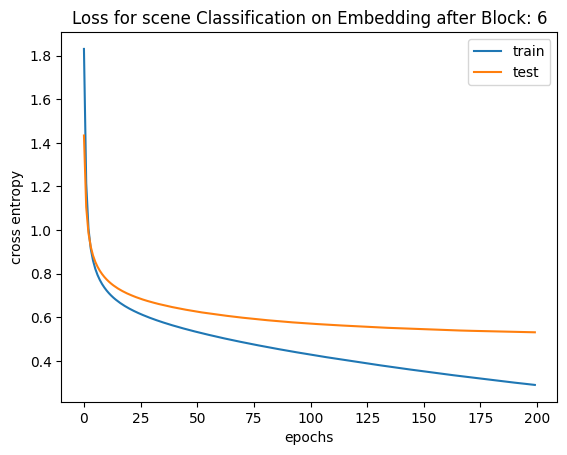

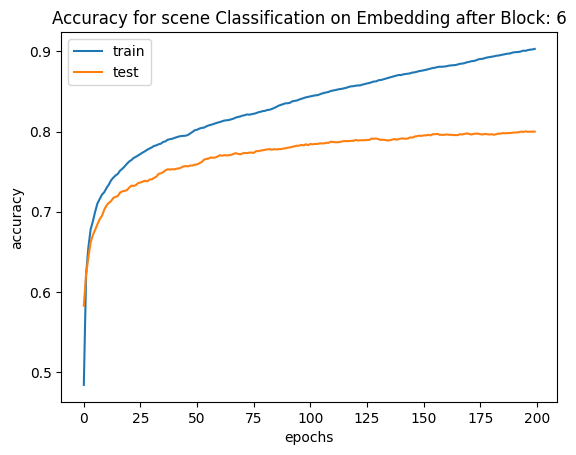

In [97]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [98]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [99]:
X_test=train_ready(test_data,col_name)

In [100]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

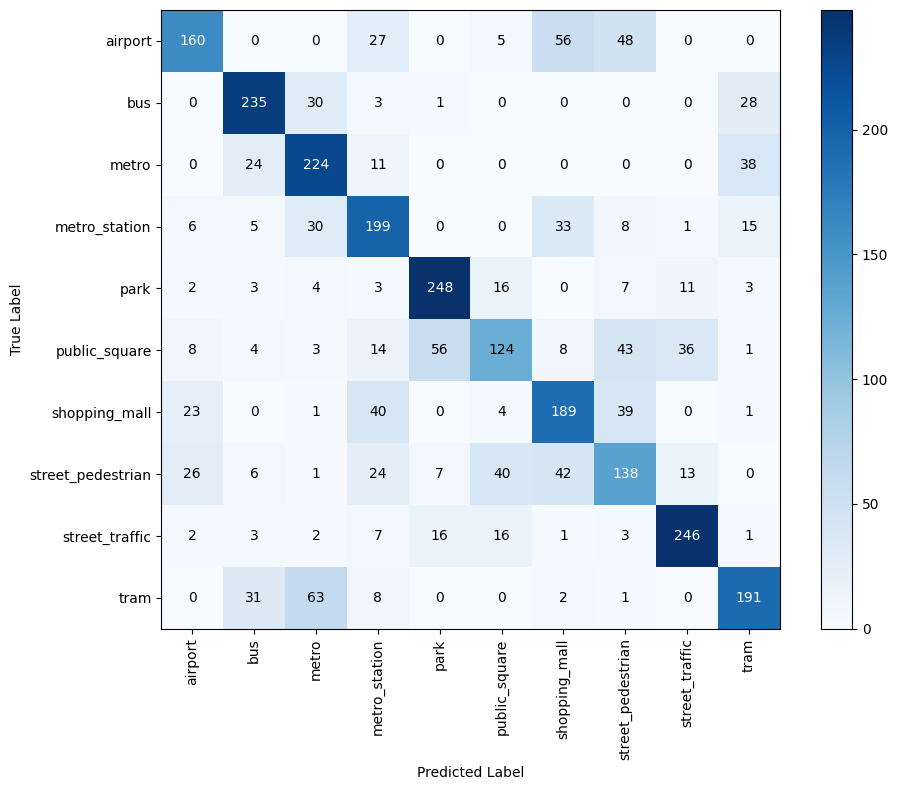

Accuracy: 0.6584


In [101]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)

# BLOCK-7

In [102]:
Block_number=7

In [103]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [104]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [105]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


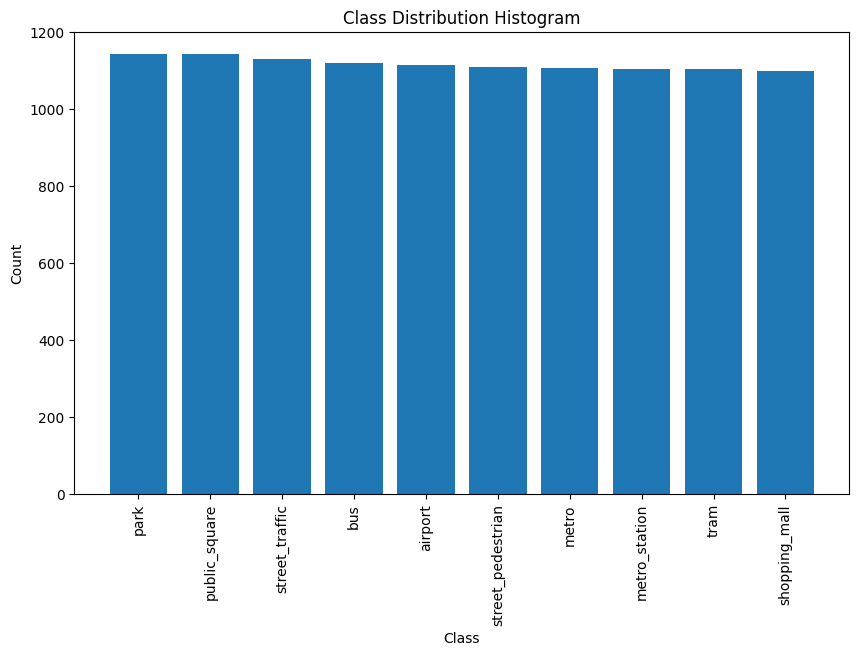

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [106]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


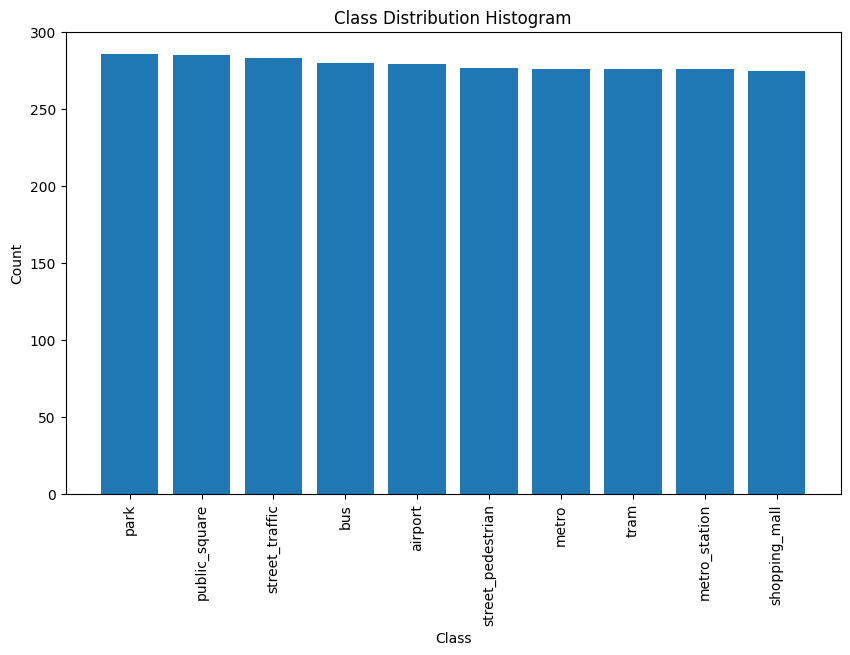

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [107]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [108]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [109]:
X_train_tensor.shape

torch.Size([11169, 768])

In [110]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0:  17%|█▋        | 29/174 [00:00<00:00, 390.28batch/s, acc=0.469, loss=2.07]

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 305.06batch/s, acc=0.656, loss=1.18]


Epoch 0 validation: Cross-entropy=1.19, Accuracy=64.5%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 345.04batch/s, acc=0.719, loss=0.881]


Epoch 1 validation: Cross-entropy=0.93, Accuracy=67.9%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 388.35batch/s, acc=0.75, loss=0.765] 


Epoch 2 validation: Cross-entropy=0.84, Accuracy=69.6%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 374.90batch/s, acc=0.766, loss=0.705]


Epoch 3 validation: Cross-entropy=0.78, Accuracy=71.3%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 403.73batch/s, acc=0.766, loss=0.67] 


Epoch 4 validation: Cross-entropy=0.75, Accuracy=72.2%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 380.60batch/s, acc=0.781, loss=0.646]


Epoch 5 validation: Cross-entropy=0.72, Accuracy=72.8%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 383.28batch/s, acc=0.781, loss=0.63] 


Epoch 6 validation: Cross-entropy=0.70, Accuracy=73.5%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 391.22batch/s, acc=0.797, loss=0.618]


Epoch 7 validation: Cross-entropy=0.69, Accuracy=74.2%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 353.20batch/s, acc=0.797, loss=0.61] 


Epoch 8 validation: Cross-entropy=0.67, Accuracy=75.1%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 430.95batch/s, acc=0.797, loss=0.602]


Epoch 9 validation: Cross-entropy=0.66, Accuracy=75.5%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 396.94batch/s, acc=0.797, loss=0.596]


Epoch 10 validation: Cross-entropy=0.65, Accuracy=75.7%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 347.54batch/s, acc=0.797, loss=0.591]


Epoch 11 validation: Cross-entropy=0.65, Accuracy=75.8%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 438.01batch/s, acc=0.797, loss=0.587]


Epoch 12 validation: Cross-entropy=0.64, Accuracy=76.0%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 385.38batch/s, acc=0.812, loss=0.582]


Epoch 13 validation: Cross-entropy=0.63, Accuracy=76.2%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 383.09batch/s, acc=0.797, loss=0.579]


Epoch 14 validation: Cross-entropy=0.63, Accuracy=76.2%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 343.87batch/s, acc=0.797, loss=0.576]


Epoch 15 validation: Cross-entropy=0.62, Accuracy=76.5%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 419.54batch/s, acc=0.781, loss=0.573]


Epoch 16 validation: Cross-entropy=0.62, Accuracy=76.6%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 368.48batch/s, acc=0.781, loss=0.57] 


Epoch 17 validation: Cross-entropy=0.61, Accuracy=76.8%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 334.50batch/s, acc=0.781, loss=0.567]


Epoch 18 validation: Cross-entropy=0.61, Accuracy=76.9%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 392.41batch/s, acc=0.781, loss=0.565]


Epoch 19 validation: Cross-entropy=0.60, Accuracy=77.0%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 436.25batch/s, acc=0.797, loss=0.563]


Epoch 20 validation: Cross-entropy=0.60, Accuracy=77.3%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 342.29batch/s, acc=0.797, loss=0.561]


Epoch 21 validation: Cross-entropy=0.59, Accuracy=77.5%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 387.55batch/s, acc=0.766, loss=0.559]


Epoch 22 validation: Cross-entropy=0.59, Accuracy=77.5%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 415.25batch/s, acc=0.766, loss=0.556]


Epoch 23 validation: Cross-entropy=0.59, Accuracy=77.7%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 362.01batch/s, acc=0.766, loss=0.554]


Epoch 24 validation: Cross-entropy=0.58, Accuracy=77.9%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 389.82batch/s, acc=0.766, loss=0.552]


Epoch 25 validation: Cross-entropy=0.58, Accuracy=78.0%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 392.39batch/s, acc=0.766, loss=0.55] 


Epoch 26 validation: Cross-entropy=0.58, Accuracy=78.3%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 330.43batch/s, acc=0.766, loss=0.548]


Epoch 27 validation: Cross-entropy=0.58, Accuracy=78.5%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 438.62batch/s, acc=0.766, loss=0.546]


Epoch 28 validation: Cross-entropy=0.57, Accuracy=78.6%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 391.62batch/s, acc=0.766, loss=0.545]


Epoch 29 validation: Cross-entropy=0.57, Accuracy=78.8%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 368.00batch/s, acc=0.766, loss=0.543]


Epoch 30 validation: Cross-entropy=0.57, Accuracy=78.7%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 400.26batch/s, acc=0.766, loss=0.541]


Epoch 31 validation: Cross-entropy=0.57, Accuracy=79.0%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 416.52batch/s, acc=0.766, loss=0.539]


Epoch 32 validation: Cross-entropy=0.56, Accuracy=79.1%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 391.62batch/s, acc=0.781, loss=0.538]


Epoch 33 validation: Cross-entropy=0.56, Accuracy=79.2%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 334.92batch/s, acc=0.781, loss=0.536]


Epoch 34 validation: Cross-entropy=0.56, Accuracy=79.3%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 416.12batch/s, acc=0.797, loss=0.534]


Epoch 35 validation: Cross-entropy=0.56, Accuracy=79.3%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 422.46batch/s, acc=0.797, loss=0.532]


Epoch 36 validation: Cross-entropy=0.55, Accuracy=79.3%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 351.46batch/s, acc=0.797, loss=0.53] 


Epoch 37 validation: Cross-entropy=0.55, Accuracy=79.3%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 385.43batch/s, acc=0.797, loss=0.528]


Epoch 38 validation: Cross-entropy=0.55, Accuracy=79.4%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 446.95batch/s, acc=0.797, loss=0.527]


Epoch 39 validation: Cross-entropy=0.55, Accuracy=79.3%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 344.07batch/s, acc=0.797, loss=0.525]


Epoch 40 validation: Cross-entropy=0.55, Accuracy=79.5%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 383.98batch/s, acc=0.781, loss=0.523]


Epoch 41 validation: Cross-entropy=0.54, Accuracy=79.5%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 409.70batch/s, acc=0.781, loss=0.522]


Epoch 42 validation: Cross-entropy=0.54, Accuracy=79.5%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 414.48batch/s, acc=0.781, loss=0.52] 


Epoch 43 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 327.72batch/s, acc=0.781, loss=0.518]


Epoch 44 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 385.21batch/s, acc=0.781, loss=0.516]


Epoch 45 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 385.58batch/s, acc=0.781, loss=0.514]


Epoch 46 validation: Cross-entropy=0.54, Accuracy=79.7%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 371.34batch/s, acc=0.781, loss=0.512]


Epoch 47 validation: Cross-entropy=0.53, Accuracy=79.9%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 406.41batch/s, acc=0.781, loss=0.51] 


Epoch 48 validation: Cross-entropy=0.53, Accuracy=79.8%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 388.98batch/s, acc=0.781, loss=0.508]


Epoch 49 validation: Cross-entropy=0.53, Accuracy=79.9%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 351.40batch/s, acc=0.781, loss=0.506]


Epoch 50 validation: Cross-entropy=0.53, Accuracy=80.0%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 426.84batch/s, acc=0.781, loss=0.504]


Epoch 51 validation: Cross-entropy=0.53, Accuracy=80.1%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 393.97batch/s, acc=0.781, loss=0.503]


Epoch 52 validation: Cross-entropy=0.53, Accuracy=80.2%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 349.50batch/s, acc=0.781, loss=0.5]  


Epoch 53 validation: Cross-entropy=0.53, Accuracy=80.2%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 425.76batch/s, acc=0.781, loss=0.498]


Epoch 54 validation: Cross-entropy=0.52, Accuracy=80.2%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 389.21batch/s, acc=0.781, loss=0.496]


Epoch 55 validation: Cross-entropy=0.52, Accuracy=80.2%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 395.40batch/s, acc=0.797, loss=0.494]


Epoch 56 validation: Cross-entropy=0.52, Accuracy=80.3%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 368.53batch/s, acc=0.797, loss=0.492]


Epoch 57 validation: Cross-entropy=0.52, Accuracy=80.3%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 401.86batch/s, acc=0.797, loss=0.49] 


Epoch 58 validation: Cross-entropy=0.52, Accuracy=80.4%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 387.19batch/s, acc=0.797, loss=0.488]


Epoch 59 validation: Cross-entropy=0.52, Accuracy=80.4%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 348.37batch/s, acc=0.797, loss=0.486]


Epoch 60 validation: Cross-entropy=0.52, Accuracy=80.5%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 439.18batch/s, acc=0.797, loss=0.484]


Epoch 61 validation: Cross-entropy=0.52, Accuracy=80.6%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 388.89batch/s, acc=0.797, loss=0.482]


Epoch 62 validation: Cross-entropy=0.51, Accuracy=80.6%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 350.52batch/s, acc=0.797, loss=0.48] 


Epoch 63 validation: Cross-entropy=0.51, Accuracy=80.8%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 433.12batch/s, acc=0.812, loss=0.478]


Epoch 64 validation: Cross-entropy=0.51, Accuracy=80.9%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 396.26batch/s, acc=0.812, loss=0.475]


Epoch 65 validation: Cross-entropy=0.51, Accuracy=81.0%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 385.90batch/s, acc=0.812, loss=0.473]


Epoch 66 validation: Cross-entropy=0.51, Accuracy=81.0%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 385.57batch/s, acc=0.812, loss=0.471]


Epoch 67 validation: Cross-entropy=0.51, Accuracy=81.3%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 414.39batch/s, acc=0.812, loss=0.469]


Epoch 68 validation: Cross-entropy=0.51, Accuracy=81.3%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 386.30batch/s, acc=0.812, loss=0.467]


Epoch 69 validation: Cross-entropy=0.51, Accuracy=81.3%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 334.91batch/s, acc=0.812, loss=0.465]


Epoch 70 validation: Cross-entropy=0.51, Accuracy=81.3%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 398.44batch/s, acc=0.812, loss=0.463]


Epoch 71 validation: Cross-entropy=0.51, Accuracy=81.4%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 435.76batch/s, acc=0.812, loss=0.461]


Epoch 72 validation: Cross-entropy=0.50, Accuracy=81.5%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 352.52batch/s, acc=0.812, loss=0.458]


Epoch 73 validation: Cross-entropy=0.50, Accuracy=81.5%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 382.66batch/s, acc=0.812, loss=0.456]


Epoch 74 validation: Cross-entropy=0.50, Accuracy=81.5%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 391.98batch/s, acc=0.812, loss=0.454]


Epoch 75 validation: Cross-entropy=0.50, Accuracy=81.6%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 373.54batch/s, acc=0.812, loss=0.452]


Epoch 76 validation: Cross-entropy=0.50, Accuracy=81.6%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 366.15batch/s, acc=0.812, loss=0.45] 


Epoch 77 validation: Cross-entropy=0.50, Accuracy=81.6%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 390.38batch/s, acc=0.812, loss=0.448]


Epoch 78 validation: Cross-entropy=0.50, Accuracy=81.7%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 388.59batch/s, acc=0.812, loss=0.446]


Epoch 79 validation: Cross-entropy=0.50, Accuracy=81.7%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 386.02batch/s, acc=0.812, loss=0.444]


Epoch 80 validation: Cross-entropy=0.50, Accuracy=81.7%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 380.77batch/s, acc=0.812, loss=0.442]


Epoch 81 validation: Cross-entropy=0.50, Accuracy=81.7%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 384.86batch/s, acc=0.812, loss=0.439]


Epoch 82 validation: Cross-entropy=0.50, Accuracy=81.8%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 350.12batch/s, acc=0.812, loss=0.437]


Epoch 83 validation: Cross-entropy=0.49, Accuracy=81.8%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 430.82batch/s, acc=0.812, loss=0.435]


Epoch 84 validation: Cross-entropy=0.49, Accuracy=81.9%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 395.46batch/s, acc=0.812, loss=0.433]


Epoch 85 validation: Cross-entropy=0.49, Accuracy=81.9%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 379.32batch/s, acc=0.812, loss=0.431]


Epoch 86 validation: Cross-entropy=0.49, Accuracy=81.9%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 403.50batch/s, acc=0.812, loss=0.429]


Epoch 87 validation: Cross-entropy=0.49, Accuracy=81.9%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 396.33batch/s, acc=0.812, loss=0.426]


Epoch 88 validation: Cross-entropy=0.49, Accuracy=82.0%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 389.50batch/s, acc=0.812, loss=0.425]


Epoch 89 validation: Cross-entropy=0.49, Accuracy=82.0%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 346.32batch/s, acc=0.812, loss=0.422]


Epoch 90 validation: Cross-entropy=0.49, Accuracy=82.1%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 432.93batch/s, acc=0.812, loss=0.42] 


Epoch 91 validation: Cross-entropy=0.49, Accuracy=82.2%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 391.53batch/s, acc=0.812, loss=0.419]


Epoch 92 validation: Cross-entropy=0.49, Accuracy=82.2%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 338.84batch/s, acc=0.797, loss=0.417]


Epoch 93 validation: Cross-entropy=0.49, Accuracy=82.2%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 430.66batch/s, acc=0.797, loss=0.414]


Epoch 94 validation: Cross-entropy=0.49, Accuracy=82.2%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 400.05batch/s, acc=0.797, loss=0.412]


Epoch 95 validation: Cross-entropy=0.49, Accuracy=82.2%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 357.20batch/s, acc=0.797, loss=0.41] 


Epoch 96 validation: Cross-entropy=0.49, Accuracy=82.2%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 379.50batch/s, acc=0.797, loss=0.408]


Epoch 97 validation: Cross-entropy=0.48, Accuracy=82.2%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 432.41batch/s, acc=0.797, loss=0.405]


Epoch 98 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 394.41batch/s, acc=0.812, loss=0.404]


Epoch 99 validation: Cross-entropy=0.48, Accuracy=82.4%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 354.40batch/s, acc=0.812, loss=0.401]


Epoch 100 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 430.60batch/s, acc=0.812, loss=0.399]


Epoch 101 validation: Cross-entropy=0.48, Accuracy=82.4%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 388.73batch/s, acc=0.812, loss=0.397]


Epoch 102 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 352.43batch/s, acc=0.812, loss=0.395]


Epoch 103 validation: Cross-entropy=0.48, Accuracy=82.2%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 438.57batch/s, acc=0.812, loss=0.392]


Epoch 104 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 395.91batch/s, acc=0.812, loss=0.39] 


Epoch 105 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 336.90batch/s, acc=0.812, loss=0.388]


Epoch 106 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 375.66batch/s, acc=0.812, loss=0.386]


Epoch 107 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 429.62batch/s, acc=0.812, loss=0.383]


Epoch 108 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 333.39batch/s, acc=0.812, loss=0.381]


Epoch 109 validation: Cross-entropy=0.48, Accuracy=82.4%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 393.89batch/s, acc=0.812, loss=0.378]


Epoch 110 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 438.95batch/s, acc=0.812, loss=0.376]


Epoch 111 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 347.77batch/s, acc=0.828, loss=0.374]


Epoch 112 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 389.27batch/s, acc=0.812, loss=0.373]


Epoch 113 validation: Cross-entropy=0.48, Accuracy=82.3%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 402.12batch/s, acc=0.828, loss=0.369]


Epoch 114 validation: Cross-entropy=0.48, Accuracy=82.5%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 370.25batch/s, acc=0.828, loss=0.368]


Epoch 115 validation: Cross-entropy=0.48, Accuracy=82.6%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 388.85batch/s, acc=0.828, loss=0.366]


Epoch 116 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 395.13batch/s, acc=0.844, loss=0.364]


Epoch 117 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 434.30batch/s, acc=0.844, loss=0.363]


Epoch 118 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 360.75batch/s, acc=0.859, loss=0.36] 


Epoch 119 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 393.88batch/s, acc=0.875, loss=0.359]


Epoch 120 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 424.77batch/s, acc=0.875, loss=0.357]


Epoch 121 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 351.99batch/s, acc=0.875, loss=0.356]


Epoch 122 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 387.46batch/s, acc=0.875, loss=0.353]


Epoch 123 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 386.41batch/s, acc=0.875, loss=0.352]


Epoch 124 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 407.23batch/s, acc=0.875, loss=0.351]


Epoch 125 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 403.08batch/s, acc=0.875, loss=0.349]


Epoch 126 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 392.78batch/s, acc=0.875, loss=0.347]


Epoch 127 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 401.65batch/s, acc=0.875, loss=0.345]


Epoch 128 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 373.52batch/s, acc=0.875, loss=0.344]


Epoch 129 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 392.08batch/s, acc=0.875, loss=0.342]


Epoch 130 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 391.04batch/s, acc=0.875, loss=0.34] 


Epoch 131 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 345.53batch/s, acc=0.875, loss=0.338]


Epoch 132 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 433.10batch/s, acc=0.875, loss=0.337]


Epoch 133 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 394.07batch/s, acc=0.875, loss=0.335]


Epoch 134 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 340.56batch/s, acc=0.875, loss=0.334]


Epoch 135 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 396.85batch/s, acc=0.875, loss=0.332]


Epoch 136 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 424.57batch/s, acc=0.875, loss=0.33] 


Epoch 137 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 393.02batch/s, acc=0.875, loss=0.328]


Epoch 138 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 356.78batch/s, acc=0.875, loss=0.327]


Epoch 139 validation: Cross-entropy=0.47, Accuracy=82.4%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 427.24batch/s, acc=0.875, loss=0.325]


Epoch 140 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 387.70batch/s, acc=0.875, loss=0.324]


Epoch 141 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 347.23batch/s, acc=0.875, loss=0.322]


Epoch 142 validation: Cross-entropy=0.47, Accuracy=82.4%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 441.67batch/s, acc=0.875, loss=0.32] 


Epoch 143 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 390.01batch/s, acc=0.875, loss=0.319]


Epoch 144 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 337.31batch/s, acc=0.875, loss=0.317]


Epoch 145 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 325.18batch/s, acc=0.891, loss=0.316]


Epoch 146 validation: Cross-entropy=0.47, Accuracy=82.4%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 299.47batch/s, acc=0.891, loss=0.314]


Epoch 147 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 414.97batch/s, acc=0.891, loss=0.312]


Epoch 148 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 483.22batch/s, acc=0.891, loss=0.31] 


Epoch 149 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 374.13batch/s, acc=0.891, loss=0.309]


Epoch 150 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 329.62batch/s, acc=0.891, loss=0.307]


Epoch 151 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 333.15batch/s, acc=0.891, loss=0.306]


Epoch 152 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 326.57batch/s, acc=0.891, loss=0.304]


Epoch 153 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 237.96batch/s, acc=0.906, loss=0.303]


Epoch 154 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 299.65batch/s, acc=0.891, loss=0.301]


Epoch 155 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 385.25batch/s, acc=0.906, loss=0.3]  


Epoch 156 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 301.11batch/s, acc=0.906, loss=0.298]


Epoch 157 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 346.66batch/s, acc=0.906, loss=0.297]


Epoch 158 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 405.04batch/s, acc=0.906, loss=0.295]


Epoch 159 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 349.80batch/s, acc=0.906, loss=0.294]


Epoch 160 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 308.24batch/s, acc=0.906, loss=0.293]


Epoch 161 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 345.21batch/s, acc=0.906, loss=0.291]


Epoch 162 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 322.54batch/s, acc=0.906, loss=0.29] 


Epoch 163 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 398.48batch/s, acc=0.906, loss=0.288]


Epoch 164 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 321.70batch/s, acc=0.906, loss=0.287]


Epoch 165 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 332.52batch/s, acc=0.906, loss=0.285]


Epoch 166 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 355.43batch/s, acc=0.906, loss=0.284]


Epoch 167 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 356.67batch/s, acc=0.906, loss=0.283]


Epoch 168 validation: Cross-entropy=0.47, Accuracy=82.8%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 351.92batch/s, acc=0.906, loss=0.281]


Epoch 169 validation: Cross-entropy=0.47, Accuracy=82.9%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 289.70batch/s, acc=0.906, loss=0.28] 


Epoch 170 validation: Cross-entropy=0.47, Accuracy=82.9%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 349.24batch/s, acc=0.906, loss=0.279]


Epoch 171 validation: Cross-entropy=0.47, Accuracy=82.9%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 397.39batch/s, acc=0.906, loss=0.277]


Epoch 172 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 357.64batch/s, acc=0.906, loss=0.275]


Epoch 173 validation: Cross-entropy=0.47, Accuracy=82.9%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 355.56batch/s, acc=0.906, loss=0.274]


Epoch 174 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 370.64batch/s, acc=0.906, loss=0.274]


Epoch 175 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 367.31batch/s, acc=0.906, loss=0.272]


Epoch 176 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 369.22batch/s, acc=0.906, loss=0.27] 


Epoch 177 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 353.76batch/s, acc=0.906, loss=0.269]


Epoch 178 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 364.67batch/s, acc=0.906, loss=0.267]


Epoch 179 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 364.74batch/s, acc=0.906, loss=0.266]


Epoch 180 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 346.70batch/s, acc=0.906, loss=0.265]


Epoch 181 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 373.03batch/s, acc=0.906, loss=0.264]


Epoch 182 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 319.34batch/s, acc=0.906, loss=0.263]


Epoch 183 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 379.01batch/s, acc=0.906, loss=0.262]


Epoch 184 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 336.24batch/s, acc=0.906, loss=0.261]


Epoch 185 validation: Cross-entropy=0.47, Accuracy=83.2%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 396.89batch/s, acc=0.906, loss=0.259]


Epoch 186 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 381.22batch/s, acc=0.906, loss=0.258]


Epoch 187 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 366.16batch/s, acc=0.906, loss=0.257]


Epoch 188 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 349.04batch/s, acc=0.906, loss=0.255]


Epoch 189 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 384.91batch/s, acc=0.906, loss=0.255] 


Epoch 190 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 340.00batch/s, acc=0.906, loss=0.253] 


Epoch 191 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 362.08batch/s, acc=0.906, loss=0.251]


Epoch 192 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 375.90batch/s, acc=0.906, loss=0.25]  


Epoch 193 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 323.58batch/s, acc=0.906, loss=0.249] 


Epoch 194 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 396.10batch/s, acc=0.906, loss=0.248]


Epoch 195 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 377.75batch/s, acc=0.906, loss=0.246] 


Epoch 196 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 325.39batch/s, acc=0.906, loss=0.245] 


Epoch 197 validation: Cross-entropy=0.47, Accuracy=83.1%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 380.41batch/s, acc=0.906, loss=0.244] 


Epoch 198 validation: Cross-entropy=0.47, Accuracy=83.0%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 384.19batch/s, acc=0.906, loss=0.243] 


Epoch 199 validation: Cross-entropy=0.47, Accuracy=83.1%


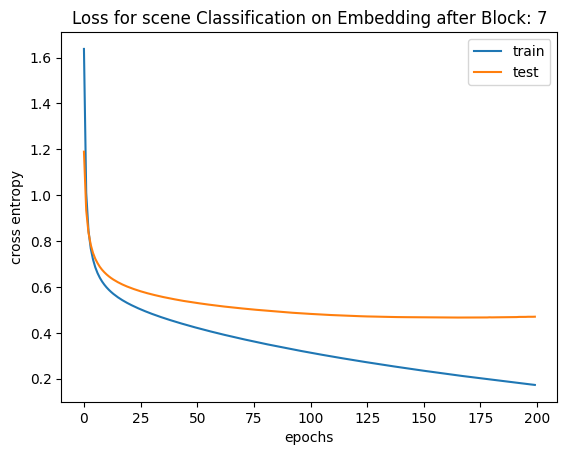

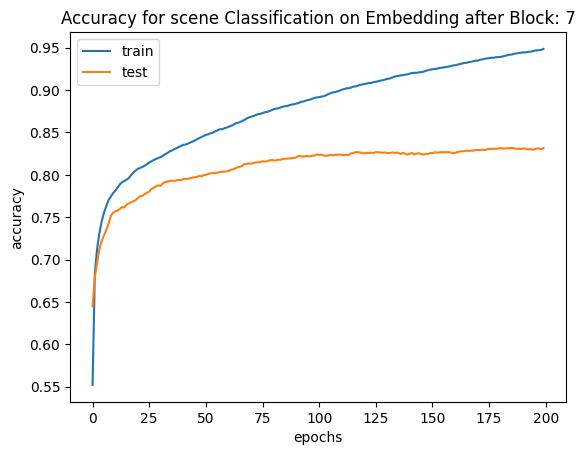

In [112]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [113]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [114]:
X_test=train_ready(test_data,col_name)

In [115]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

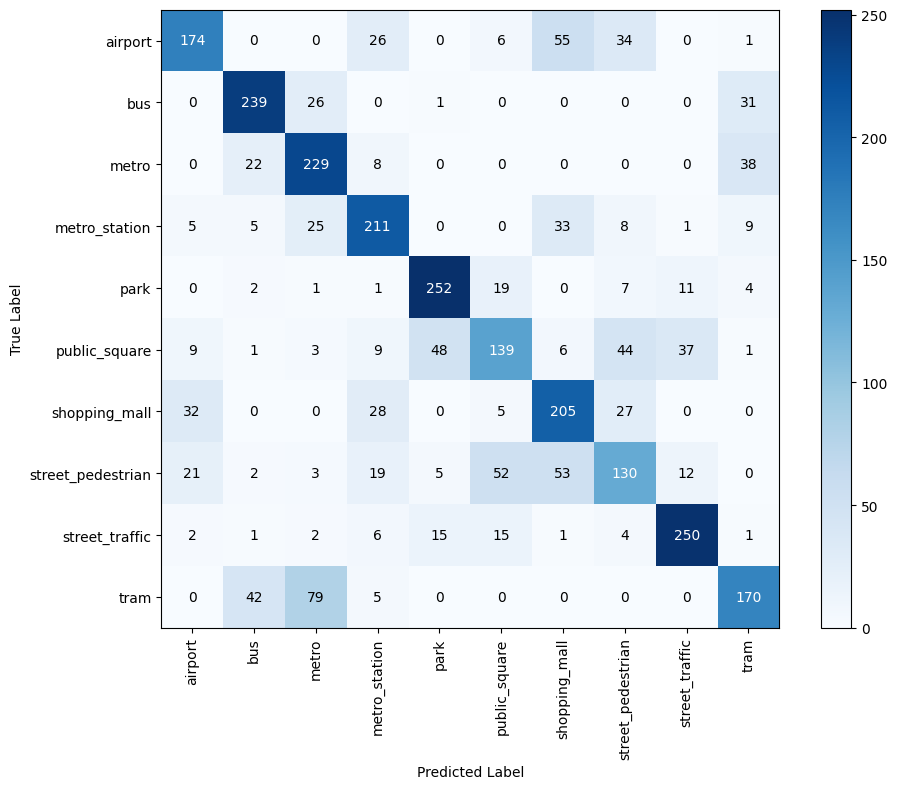

Accuracy: 0.6735


In [116]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-8

In [117]:
Block_number=8

In [118]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [119]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [120]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


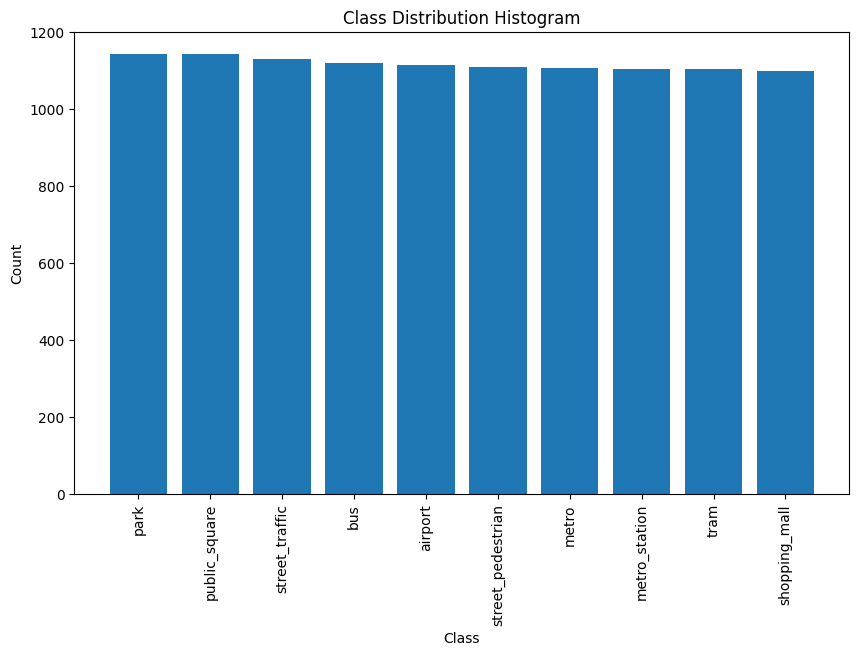

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [121]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


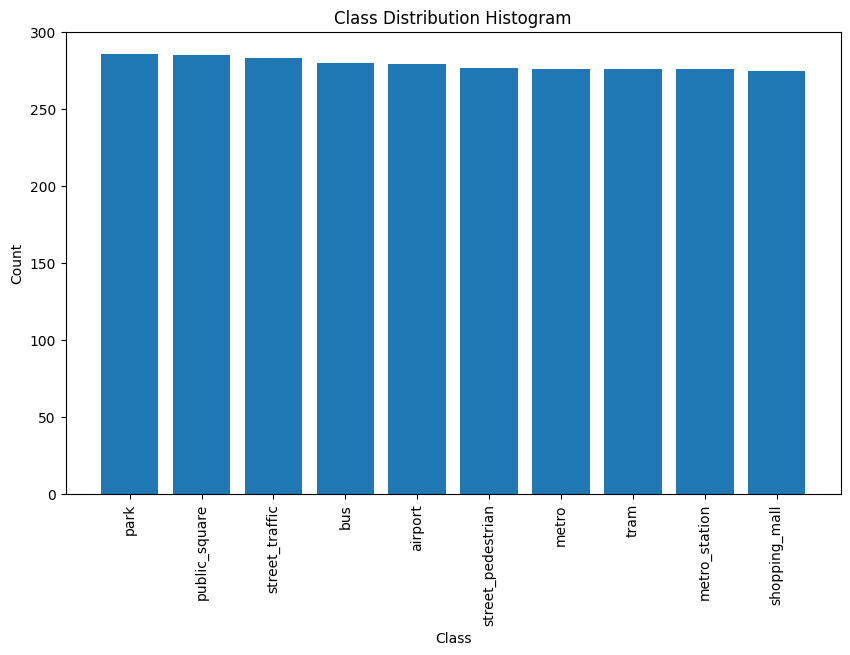

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [122]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [123]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [124]:
X_train_tensor.shape

torch.Size([11169, 768])

In [125]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [126]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 322.84batch/s, acc=0.75, loss=1.01]  


Epoch 0 validation: Cross-entropy=1.03, Accuracy=67.6%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 400.10batch/s, acc=0.797, loss=0.755]


Epoch 1 validation: Cross-entropy=0.81, Accuracy=71.5%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 351.54batch/s, acc=0.781, loss=0.673]


Epoch 2 validation: Cross-entropy=0.73, Accuracy=73.7%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 386.58batch/s, acc=0.781, loss=0.635]


Epoch 3 validation: Cross-entropy=0.68, Accuracy=75.5%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 392.11batch/s, acc=0.797, loss=0.613]


Epoch 4 validation: Cross-entropy=0.65, Accuracy=76.5%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 333.11batch/s, acc=0.797, loss=0.6]  


Epoch 5 validation: Cross-entropy=0.63, Accuracy=77.0%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 388.25batch/s, acc=0.797, loss=0.59] 


Epoch 6 validation: Cross-entropy=0.61, Accuracy=77.5%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 419.93batch/s, acc=0.812, loss=0.582]


Epoch 7 validation: Cross-entropy=0.60, Accuracy=77.9%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 393.18batch/s, acc=0.797, loss=0.576]


Epoch 8 validation: Cross-entropy=0.59, Accuracy=78.2%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 343.85batch/s, acc=0.797, loss=0.571]


Epoch 9 validation: Cross-entropy=0.58, Accuracy=78.5%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 363.49batch/s, acc=0.797, loss=0.566]


Epoch 10 validation: Cross-entropy=0.57, Accuracy=78.7%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 379.22batch/s, acc=0.797, loss=0.561]


Epoch 11 validation: Cross-entropy=0.56, Accuracy=78.8%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 267.56batch/s, acc=0.797, loss=0.557]


Epoch 12 validation: Cross-entropy=0.55, Accuracy=79.1%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 452.32batch/s, acc=0.812, loss=0.552]


Epoch 13 validation: Cross-entropy=0.55, Accuracy=79.3%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 344.01batch/s, acc=0.812, loss=0.548]


Epoch 14 validation: Cross-entropy=0.54, Accuracy=79.6%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 362.22batch/s, acc=0.812, loss=0.544]


Epoch 15 validation: Cross-entropy=0.54, Accuracy=79.8%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 357.67batch/s, acc=0.812, loss=0.541]


Epoch 16 validation: Cross-entropy=0.53, Accuracy=80.0%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 314.70batch/s, acc=0.812, loss=0.537]


Epoch 17 validation: Cross-entropy=0.53, Accuracy=80.0%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 367.59batch/s, acc=0.812, loss=0.533]


Epoch 18 validation: Cross-entropy=0.53, Accuracy=80.0%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 365.97batch/s, acc=0.812, loss=0.53] 


Epoch 19 validation: Cross-entropy=0.52, Accuracy=80.3%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 326.57batch/s, acc=0.812, loss=0.526]


Epoch 20 validation: Cross-entropy=0.52, Accuracy=80.2%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 279.64batch/s, acc=0.828, loss=0.523]


Epoch 21 validation: Cross-entropy=0.52, Accuracy=80.4%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 321.61batch/s, acc=0.828, loss=0.519]


Epoch 22 validation: Cross-entropy=0.51, Accuracy=80.6%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 381.58batch/s, acc=0.828, loss=0.516]


Epoch 23 validation: Cross-entropy=0.51, Accuracy=80.7%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 360.57batch/s, acc=0.828, loss=0.513]


Epoch 24 validation: Cross-entropy=0.51, Accuracy=80.7%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 372.21batch/s, acc=0.828, loss=0.509]


Epoch 25 validation: Cross-entropy=0.51, Accuracy=80.6%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 316.12batch/s, acc=0.828, loss=0.506]


Epoch 26 validation: Cross-entropy=0.50, Accuracy=80.7%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 394.23batch/s, acc=0.828, loss=0.503]


Epoch 27 validation: Cross-entropy=0.50, Accuracy=81.0%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 339.06batch/s, acc=0.828, loss=0.499]


Epoch 28 validation: Cross-entropy=0.50, Accuracy=81.1%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 298.26batch/s, acc=0.828, loss=0.496]


Epoch 29 validation: Cross-entropy=0.50, Accuracy=81.2%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 337.82batch/s, acc=0.828, loss=0.493]


Epoch 30 validation: Cross-entropy=0.50, Accuracy=81.3%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 348.96batch/s, acc=0.828, loss=0.49] 


Epoch 31 validation: Cross-entropy=0.49, Accuracy=81.4%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 350.36batch/s, acc=0.828, loss=0.487]


Epoch 32 validation: Cross-entropy=0.49, Accuracy=81.4%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 303.66batch/s, acc=0.828, loss=0.484]


Epoch 33 validation: Cross-entropy=0.49, Accuracy=81.4%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 382.15batch/s, acc=0.828, loss=0.481]


Epoch 34 validation: Cross-entropy=0.49, Accuracy=81.5%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 341.64batch/s, acc=0.828, loss=0.479]


Epoch 35 validation: Cross-entropy=0.49, Accuracy=81.4%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 329.08batch/s, acc=0.828, loss=0.476]


Epoch 36 validation: Cross-entropy=0.49, Accuracy=81.5%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 384.87batch/s, acc=0.828, loss=0.473]


Epoch 37 validation: Cross-entropy=0.48, Accuracy=81.6%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 306.86batch/s, acc=0.828, loss=0.47] 


Epoch 38 validation: Cross-entropy=0.48, Accuracy=81.7%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 337.10batch/s, acc=0.828, loss=0.468]


Epoch 39 validation: Cross-entropy=0.48, Accuracy=81.8%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 413.33batch/s, acc=0.828, loss=0.465]


Epoch 40 validation: Cross-entropy=0.48, Accuracy=81.8%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 301.52batch/s, acc=0.828, loss=0.463]


Epoch 41 validation: Cross-entropy=0.48, Accuracy=81.9%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 349.48batch/s, acc=0.828, loss=0.46] 


Epoch 42 validation: Cross-entropy=0.48, Accuracy=81.9%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 345.49batch/s, acc=0.828, loss=0.458]


Epoch 43 validation: Cross-entropy=0.48, Accuracy=81.9%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 365.83batch/s, acc=0.828, loss=0.455]


Epoch 44 validation: Cross-entropy=0.47, Accuracy=81.8%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 310.22batch/s, acc=0.828, loss=0.453]


Epoch 45 validation: Cross-entropy=0.47, Accuracy=81.8%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 364.55batch/s, acc=0.828, loss=0.45] 


Epoch 46 validation: Cross-entropy=0.47, Accuracy=81.9%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 350.36batch/s, acc=0.828, loss=0.448]


Epoch 47 validation: Cross-entropy=0.47, Accuracy=82.0%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 357.16batch/s, acc=0.828, loss=0.446]


Epoch 48 validation: Cross-entropy=0.47, Accuracy=82.2%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 371.59batch/s, acc=0.828, loss=0.444]


Epoch 49 validation: Cross-entropy=0.47, Accuracy=82.3%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 316.01batch/s, acc=0.844, loss=0.441]


Epoch 50 validation: Cross-entropy=0.47, Accuracy=82.4%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 365.88batch/s, acc=0.844, loss=0.439]


Epoch 51 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 384.39batch/s, acc=0.844, loss=0.437]


Epoch 52 validation: Cross-entropy=0.47, Accuracy=82.5%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 356.53batch/s, acc=0.844, loss=0.434]


Epoch 53 validation: Cross-entropy=0.47, Accuracy=82.6%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 381.90batch/s, acc=0.844, loss=0.432]


Epoch 54 validation: Cross-entropy=0.46, Accuracy=82.6%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 374.33batch/s, acc=0.844, loss=0.429]


Epoch 55 validation: Cross-entropy=0.46, Accuracy=82.6%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 379.28batch/s, acc=0.844, loss=0.427]


Epoch 56 validation: Cross-entropy=0.46, Accuracy=82.6%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 355.50batch/s, acc=0.844, loss=0.425]


Epoch 57 validation: Cross-entropy=0.46, Accuracy=82.7%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 377.02batch/s, acc=0.844, loss=0.422]


Epoch 58 validation: Cross-entropy=0.46, Accuracy=82.8%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 339.37batch/s, acc=0.844, loss=0.42] 


Epoch 59 validation: Cross-entropy=0.46, Accuracy=83.0%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 408.56batch/s, acc=0.844, loss=0.417]


Epoch 60 validation: Cross-entropy=0.46, Accuracy=83.1%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 373.70batch/s, acc=0.844, loss=0.415]


Epoch 61 validation: Cross-entropy=0.46, Accuracy=83.1%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 334.73batch/s, acc=0.844, loss=0.413]


Epoch 62 validation: Cross-entropy=0.46, Accuracy=83.1%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 378.90batch/s, acc=0.844, loss=0.41] 


Epoch 63 validation: Cross-entropy=0.46, Accuracy=83.2%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 383.59batch/s, acc=0.859, loss=0.408]


Epoch 64 validation: Cross-entropy=0.46, Accuracy=83.4%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 350.31batch/s, acc=0.859, loss=0.406]


Epoch 65 validation: Cross-entropy=0.46, Accuracy=83.5%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 392.94batch/s, acc=0.859, loss=0.403]


Epoch 66 validation: Cross-entropy=0.45, Accuracy=83.5%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 380.06batch/s, acc=0.859, loss=0.402]


Epoch 67 validation: Cross-entropy=0.45, Accuracy=83.6%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 330.19batch/s, acc=0.859, loss=0.399]


Epoch 68 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 393.38batch/s, acc=0.859, loss=0.397]


Epoch 69 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 406.20batch/s, acc=0.859, loss=0.394]


Epoch 70 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 314.81batch/s, acc=0.859, loss=0.392]


Epoch 71 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 363.92batch/s, acc=0.859, loss=0.39] 


Epoch 72 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 417.03batch/s, acc=0.859, loss=0.388]


Epoch 73 validation: Cross-entropy=0.45, Accuracy=83.8%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 327.22batch/s, acc=0.859, loss=0.386]


Epoch 74 validation: Cross-entropy=0.45, Accuracy=83.8%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 377.38batch/s, acc=0.859, loss=0.384]


Epoch 75 validation: Cross-entropy=0.45, Accuracy=83.8%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 340.32batch/s, acc=0.859, loss=0.381]


Epoch 76 validation: Cross-entropy=0.45, Accuracy=83.8%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 393.01batch/s, acc=0.859, loss=0.379]


Epoch 77 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 379.10batch/s, acc=0.859, loss=0.377]


Epoch 78 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 343.81batch/s, acc=0.859, loss=0.375]


Epoch 79 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 373.59batch/s, acc=0.859, loss=0.373]


Epoch 80 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 377.71batch/s, acc=0.859, loss=0.371]


Epoch 81 validation: Cross-entropy=0.45, Accuracy=83.9%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 341.40batch/s, acc=0.859, loss=0.369]


Epoch 82 validation: Cross-entropy=0.45, Accuracy=83.9%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 351.32batch/s, acc=0.859, loss=0.367]


Epoch 83 validation: Cross-entropy=0.45, Accuracy=83.8%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 414.96batch/s, acc=0.859, loss=0.365]


Epoch 84 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 335.40batch/s, acc=0.859, loss=0.364]


Epoch 85 validation: Cross-entropy=0.45, Accuracy=83.7%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 374.56batch/s, acc=0.859, loss=0.361]


Epoch 86 validation: Cross-entropy=0.44, Accuracy=83.7%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 380.84batch/s, acc=0.859, loss=0.36] 


Epoch 87 validation: Cross-entropy=0.44, Accuracy=83.8%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 369.33batch/s, acc=0.859, loss=0.358]


Epoch 88 validation: Cross-entropy=0.44, Accuracy=83.7%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 350.51batch/s, acc=0.859, loss=0.355]


Epoch 89 validation: Cross-entropy=0.44, Accuracy=83.7%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 370.67batch/s, acc=0.859, loss=0.354]


Epoch 90 validation: Cross-entropy=0.44, Accuracy=83.8%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 335.53batch/s, acc=0.859, loss=0.352]


Epoch 91 validation: Cross-entropy=0.44, Accuracy=83.8%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 410.53batch/s, acc=0.859, loss=0.351]


Epoch 92 validation: Cross-entropy=0.44, Accuracy=83.9%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 370.47batch/s, acc=0.859, loss=0.349]


Epoch 93 validation: Cross-entropy=0.44, Accuracy=83.8%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 328.77batch/s, acc=0.859, loss=0.347]


Epoch 94 validation: Cross-entropy=0.44, Accuracy=83.8%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 383.39batch/s, acc=0.859, loss=0.345]


Epoch 95 validation: Cross-entropy=0.44, Accuracy=83.8%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 407.61batch/s, acc=0.859, loss=0.343]


Epoch 96 validation: Cross-entropy=0.44, Accuracy=83.8%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 329.06batch/s, acc=0.875, loss=0.342]


Epoch 97 validation: Cross-entropy=0.44, Accuracy=83.9%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 360.74batch/s, acc=0.875, loss=0.34] 


Epoch 98 validation: Cross-entropy=0.44, Accuracy=83.8%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 378.74batch/s, acc=0.875, loss=0.338]


Epoch 99 validation: Cross-entropy=0.44, Accuracy=83.8%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 355.46batch/s, acc=0.875, loss=0.336]


Epoch 100 validation: Cross-entropy=0.44, Accuracy=83.9%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 404.93batch/s, acc=0.875, loss=0.334]


Epoch 101 validation: Cross-entropy=0.44, Accuracy=84.0%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 372.30batch/s, acc=0.875, loss=0.332]


Epoch 102 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 323.42batch/s, acc=0.875, loss=0.33] 


Epoch 103 validation: Cross-entropy=0.44, Accuracy=84.0%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 378.47batch/s, acc=0.875, loss=0.328]


Epoch 104 validation: Cross-entropy=0.44, Accuracy=84.0%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 414.47batch/s, acc=0.875, loss=0.327]


Epoch 105 validation: Cross-entropy=0.44, Accuracy=84.0%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 343.18batch/s, acc=0.875, loss=0.325]


Epoch 106 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 354.39batch/s, acc=0.875, loss=0.323]


Epoch 107 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 404.30batch/s, acc=0.875, loss=0.321]


Epoch 108 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 345.41batch/s, acc=0.891, loss=0.32] 


Epoch 109 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 380.49batch/s, acc=0.891, loss=0.317]


Epoch 110 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 345.31batch/s, acc=0.891, loss=0.315]


Epoch 111 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 360.64batch/s, acc=0.891, loss=0.313]


Epoch 112 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 402.06batch/s, acc=0.891, loss=0.311] 


Epoch 113 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 361.87batch/s, acc=0.891, loss=0.31]  


Epoch 114 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 384.68batch/s, acc=0.891, loss=0.308] 


Epoch 115 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 384.32batch/s, acc=0.891, loss=0.306] 


Epoch 116 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 345.55batch/s, acc=0.891, loss=0.305] 


Epoch 117 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 378.60batch/s, acc=0.891, loss=0.302] 


Epoch 118 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 421.29batch/s, acc=0.891, loss=0.301] 


Epoch 119 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 327.40batch/s, acc=0.891, loss=0.3]   


Epoch 120 validation: Cross-entropy=0.44, Accuracy=84.0%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 393.86batch/s, acc=0.891, loss=0.297] 


Epoch 121 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 394.36batch/s, acc=0.891, loss=0.296] 


Epoch 122 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 332.87batch/s, acc=0.891, loss=0.294] 


Epoch 123 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 382.44batch/s, acc=0.906, loss=0.292] 


Epoch 124 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 401.26batch/s, acc=0.906, loss=0.292] 


Epoch 125 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 364.72batch/s, acc=0.906, loss=0.289] 


Epoch 126 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 362.77batch/s, acc=0.906, loss=0.288] 


Epoch 127 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 423.15batch/s, acc=0.906, loss=0.286] 


Epoch 128 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 352.25batch/s, acc=0.906, loss=0.284] 


Epoch 129 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 363.24batch/s, acc=0.906, loss=0.282] 


Epoch 130 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 389.62batch/s, acc=0.906, loss=0.281] 


Epoch 131 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 381.26batch/s, acc=0.906, loss=0.279] 


Epoch 132 validation: Cross-entropy=0.44, Accuracy=84.3%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 359.13batch/s, acc=0.906, loss=0.277] 


Epoch 133 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 396.67batch/s, acc=0.906, loss=0.275] 


Epoch 134 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 373.58batch/s, acc=0.906, loss=0.274] 


Epoch 135 validation: Cross-entropy=0.44, Accuracy=84.3%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 362.52batch/s, acc=0.906, loss=0.273] 


Epoch 136 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 379.87batch/s, acc=0.906, loss=0.27]  


Epoch 137 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 383.36batch/s, acc=0.906, loss=0.269] 


Epoch 138 validation: Cross-entropy=0.44, Accuracy=84.3%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 365.61batch/s, acc=0.906, loss=0.267] 


Epoch 139 validation: Cross-entropy=0.44, Accuracy=84.4%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 382.65batch/s, acc=0.906, loss=0.265] 


Epoch 140 validation: Cross-entropy=0.44, Accuracy=84.3%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 383.60batch/s, acc=0.906, loss=0.264] 


Epoch 141 validation: Cross-entropy=0.44, Accuracy=84.2%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 354.11batch/s, acc=0.906, loss=0.262] 


Epoch 142 validation: Cross-entropy=0.44, Accuracy=84.3%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 377.54batch/s, acc=0.906, loss=0.26]  


Epoch 143 validation: Cross-entropy=0.44, Accuracy=84.3%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 369.13batch/s, acc=0.906, loss=0.259] 


Epoch 144 validation: Cross-entropy=0.44, Accuracy=84.3%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 360.25batch/s, acc=0.906, loss=0.257] 


Epoch 145 validation: Cross-entropy=0.44, Accuracy=84.4%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 375.16batch/s, acc=0.906, loss=0.255] 


Epoch 146 validation: Cross-entropy=0.44, Accuracy=84.4%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 368.68batch/s, acc=0.906, loss=0.253]


Epoch 147 validation: Cross-entropy=0.44, Accuracy=84.4%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 370.07batch/s, acc=0.906, loss=0.252] 


Epoch 148 validation: Cross-entropy=0.44, Accuracy=84.4%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 382.92batch/s, acc=0.906, loss=0.251] 


Epoch 149 validation: Cross-entropy=0.44, Accuracy=84.4%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 330.13batch/s, acc=0.906, loss=0.249] 


Epoch 150 validation: Cross-entropy=0.44, Accuracy=84.4%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 425.96batch/s, acc=0.906, loss=0.247] 


Epoch 151 validation: Cross-entropy=0.44, Accuracy=84.4%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 380.33batch/s, acc=0.906, loss=0.245] 


Epoch 152 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 334.17batch/s, acc=0.906, loss=0.244] 


Epoch 153 validation: Cross-entropy=0.45, Accuracy=84.3%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 410.23batch/s, acc=0.906, loss=0.242] 


Epoch 154 validation: Cross-entropy=0.45, Accuracy=84.3%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 388.58batch/s, acc=0.906, loss=0.241] 


Epoch 155 validation: Cross-entropy=0.45, Accuracy=84.3%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 319.41batch/s, acc=0.906, loss=0.239] 


Epoch 156 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 382.98batch/s, acc=0.906, loss=0.238] 


Epoch 157 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 389.10batch/s, acc=0.906, loss=0.236] 


Epoch 158 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 362.90batch/s, acc=0.906, loss=0.234] 


Epoch 159 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 385.48batch/s, acc=0.906, loss=0.233] 


Epoch 160 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 404.39batch/s, acc=0.906, loss=0.231] 


Epoch 161 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 350.19batch/s, acc=0.906, loss=0.23]  


Epoch 162 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 376.61batch/s, acc=0.906, loss=0.227] 


Epoch 163 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 414.10batch/s, acc=0.906, loss=0.226] 


Epoch 164 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 337.56batch/s, acc=0.906, loss=0.225] 


Epoch 165 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 376.31batch/s, acc=0.906, loss=0.223] 


Epoch 166 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 399.11batch/s, acc=0.906, loss=0.221] 


Epoch 167 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 327.99batch/s, acc=0.906, loss=0.219] 


Epoch 168 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 383.15batch/s, acc=0.906, loss=0.218] 


Epoch 169 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 381.83batch/s, acc=0.906, loss=0.215] 


Epoch 170 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 347.33batch/s, acc=0.906, loss=0.214] 


Epoch 171 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 378.73batch/s, acc=0.906, loss=0.212] 


Epoch 172 validation: Cross-entropy=0.45, Accuracy=84.5%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 357.17batch/s, acc=0.906, loss=0.211] 


Epoch 173 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 350.91batch/s, acc=0.906, loss=0.209] 


Epoch 174 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 385.45batch/s, acc=0.906, loss=0.208] 


Epoch 175 validation: Cross-entropy=0.45, Accuracy=84.4%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 333.08batch/s, acc=0.906, loss=0.206] 


Epoch 176 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 398.53batch/s, acc=0.906, loss=0.204] 


Epoch 177 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 381.83batch/s, acc=0.906, loss=0.202] 


Epoch 178 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 338.13batch/s, acc=0.906, loss=0.201] 


Epoch 179 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 400.75batch/s, acc=0.906, loss=0.199] 


Epoch 180 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 370.76batch/s, acc=0.906, loss=0.197] 


Epoch 181 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 337.36batch/s, acc=0.906, loss=0.196] 


Epoch 182 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 375.03batch/s, acc=0.906, loss=0.194] 


Epoch 183 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 404.82batch/s, acc=0.906, loss=0.193] 


Epoch 184 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 333.03batch/s, acc=0.906, loss=0.191] 


Epoch 185 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 357.98batch/s, acc=0.906, loss=0.189] 


Epoch 186 validation: Cross-entropy=0.46, Accuracy=84.6%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 376.61batch/s, acc=0.922, loss=0.188] 


Epoch 187 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 359.76batch/s, acc=0.922, loss=0.186] 


Epoch 188 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 352.39batch/s, acc=0.922, loss=0.184] 


Epoch 189 validation: Cross-entropy=0.46, Accuracy=84.6%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 384.42batch/s, acc=0.922, loss=0.182] 


Epoch 190 validation: Cross-entropy=0.46, Accuracy=84.6%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 383.21batch/s, acc=0.922, loss=0.181] 


Epoch 191 validation: Cross-entropy=0.46, Accuracy=84.6%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 359.56batch/s, acc=0.922, loss=0.18]  


Epoch 192 validation: Cross-entropy=0.46, Accuracy=84.6%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 381.77batch/s, acc=0.922, loss=0.178] 


Epoch 193 validation: Cross-entropy=0.47, Accuracy=84.6%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 381.28batch/s, acc=0.922, loss=0.176] 


Epoch 194 validation: Cross-entropy=0.47, Accuracy=84.6%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 361.23batch/s, acc=0.922, loss=0.174] 


Epoch 195 validation: Cross-entropy=0.47, Accuracy=84.6%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 381.08batch/s, acc=0.922, loss=0.173] 


Epoch 196 validation: Cross-entropy=0.47, Accuracy=84.6%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 366.66batch/s, acc=0.922, loss=0.171] 


Epoch 197 validation: Cross-entropy=0.47, Accuracy=84.6%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 351.69batch/s, acc=0.922, loss=0.17]  


Epoch 198 validation: Cross-entropy=0.47, Accuracy=84.6%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 383.46batch/s, acc=0.922, loss=0.168] 


Epoch 199 validation: Cross-entropy=0.47, Accuracy=84.6%


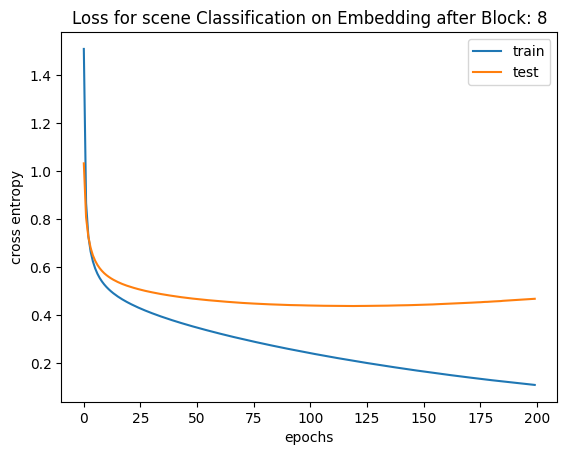

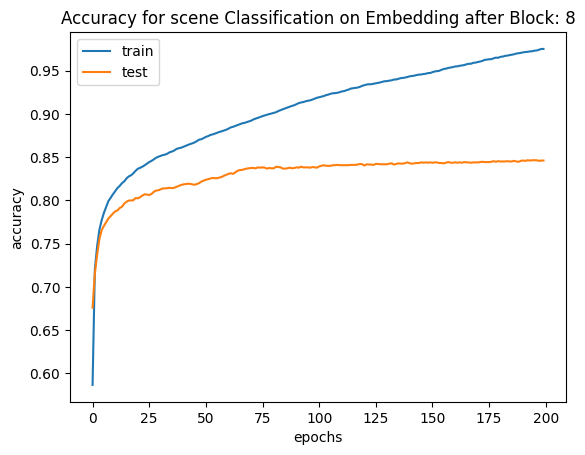

In [127]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [128]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [129]:
X_test=train_ready(test_data,col_name)

In [130]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

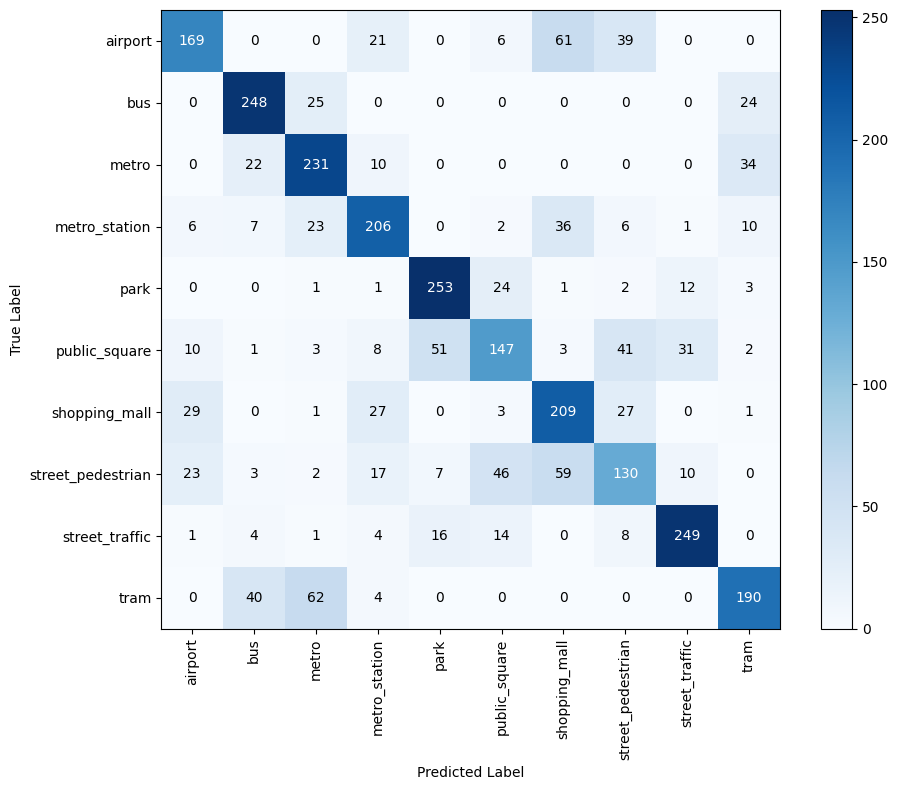

Accuracy: 0.6846


In [131]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-9

In [132]:
Block_number=9

In [133]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [134]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [135]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


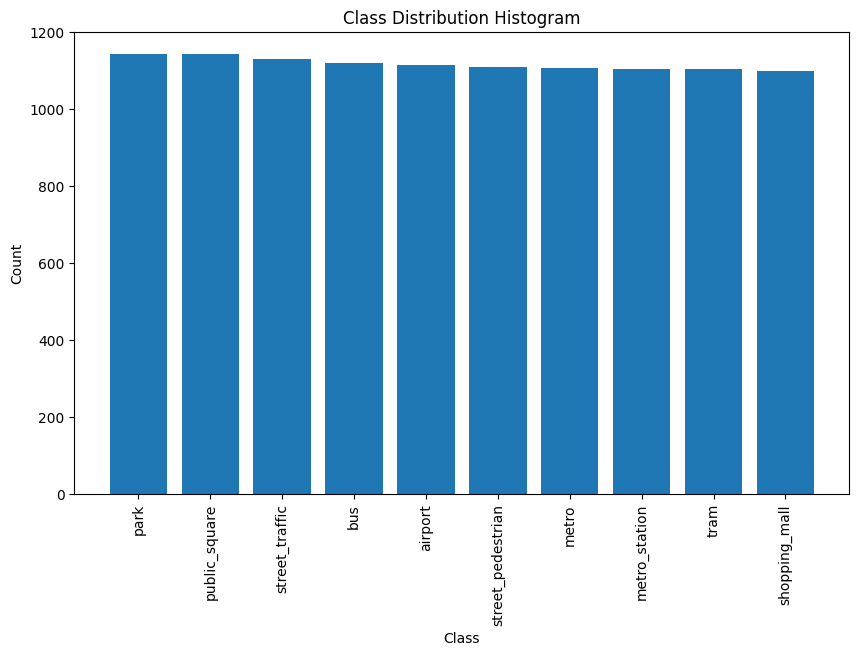

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [136]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


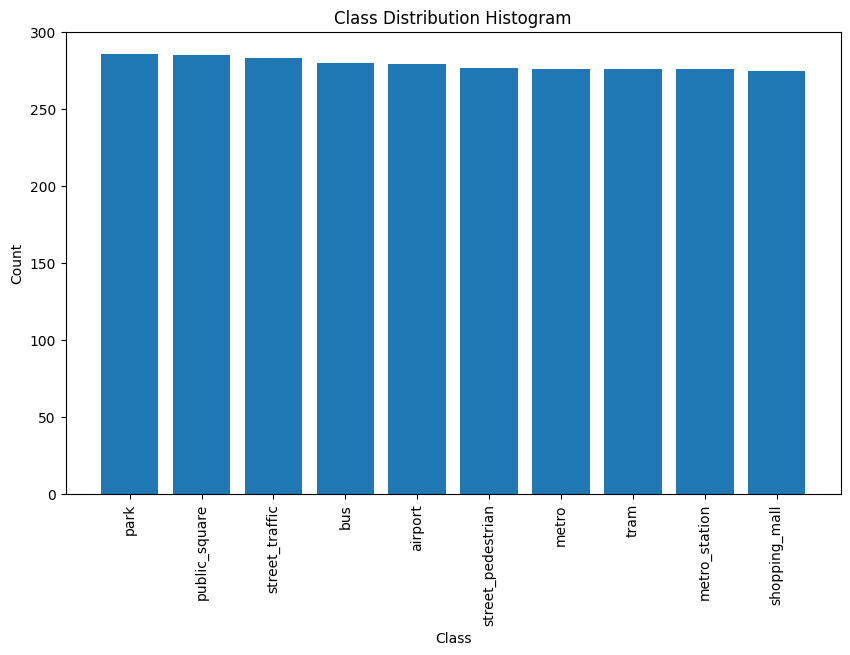

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [137]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [138]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [139]:
X_train_tensor.shape

torch.Size([11169, 768])

In [140]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [141]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 368.35batch/s, acc=0.719, loss=0.942]


Epoch 0 validation: Cross-entropy=0.94, Accuracy=70.5%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 420.45batch/s, acc=0.781, loss=0.721]


Epoch 1 validation: Cross-entropy=0.74, Accuracy=73.7%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 423.08batch/s, acc=0.781, loss=0.649]


Epoch 2 validation: Cross-entropy=0.67, Accuracy=75.7%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 482.09batch/s, acc=0.781, loss=0.615]


Epoch 3 validation: Cross-entropy=0.63, Accuracy=76.7%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 425.67batch/s, acc=0.812, loss=0.595]


Epoch 4 validation: Cross-entropy=0.60, Accuracy=77.9%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 370.09batch/s, acc=0.797, loss=0.583]


Epoch 5 validation: Cross-entropy=0.58, Accuracy=78.6%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 422.07batch/s, acc=0.812, loss=0.573]


Epoch 6 validation: Cross-entropy=0.56, Accuracy=79.0%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 480.29batch/s, acc=0.812, loss=0.565]


Epoch 7 validation: Cross-entropy=0.55, Accuracy=79.4%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 432.67batch/s, acc=0.812, loss=0.559]


Epoch 8 validation: Cross-entropy=0.54, Accuracy=79.8%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 421.67batch/s, acc=0.828, loss=0.553]


Epoch 9 validation: Cross-entropy=0.53, Accuracy=79.8%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 365.11batch/s, acc=0.828, loss=0.548]


Epoch 10 validation: Cross-entropy=0.52, Accuracy=79.9%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 470.70batch/s, acc=0.828, loss=0.544]


Epoch 11 validation: Cross-entropy=0.52, Accuracy=80.1%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 423.46batch/s, acc=0.828, loss=0.539]


Epoch 12 validation: Cross-entropy=0.51, Accuracy=80.3%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 425.42batch/s, acc=0.828, loss=0.535]


Epoch 13 validation: Cross-entropy=0.51, Accuracy=80.5%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 483.39batch/s, acc=0.828, loss=0.531]


Epoch 14 validation: Cross-entropy=0.50, Accuracy=80.7%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 427.06batch/s, acc=0.828, loss=0.527]


Epoch 15 validation: Cross-entropy=0.50, Accuracy=80.8%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 368.31batch/s, acc=0.812, loss=0.523]


Epoch 16 validation: Cross-entropy=0.50, Accuracy=80.8%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 482.56batch/s, acc=0.812, loss=0.519]


Epoch 17 validation: Cross-entropy=0.49, Accuracy=80.8%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 422.68batch/s, acc=0.812, loss=0.515]


Epoch 18 validation: Cross-entropy=0.49, Accuracy=81.0%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 413.53batch/s, acc=0.812, loss=0.511]


Epoch 19 validation: Cross-entropy=0.49, Accuracy=81.2%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 403.27batch/s, acc=0.812, loss=0.507]


Epoch 20 validation: Cross-entropy=0.48, Accuracy=81.2%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 402.14batch/s, acc=0.812, loss=0.503]


Epoch 21 validation: Cross-entropy=0.48, Accuracy=81.5%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 413.63batch/s, acc=0.812, loss=0.499]


Epoch 22 validation: Cross-entropy=0.48, Accuracy=81.5%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 415.53batch/s, acc=0.812, loss=0.496]


Epoch 23 validation: Cross-entropy=0.48, Accuracy=81.6%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 450.58batch/s, acc=0.812, loss=0.492]


Epoch 24 validation: Cross-entropy=0.47, Accuracy=81.7%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 400.30batch/s, acc=0.812, loss=0.488]


Epoch 25 validation: Cross-entropy=0.47, Accuracy=81.9%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 365.83batch/s, acc=0.828, loss=0.485]


Epoch 26 validation: Cross-entropy=0.47, Accuracy=82.0%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 469.62batch/s, acc=0.828, loss=0.481]


Epoch 27 validation: Cross-entropy=0.47, Accuracy=82.0%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 426.42batch/s, acc=0.828, loss=0.477]


Epoch 28 validation: Cross-entropy=0.47, Accuracy=82.2%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 431.78batch/s, acc=0.828, loss=0.474]


Epoch 29 validation: Cross-entropy=0.46, Accuracy=82.3%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 425.27batch/s, acc=0.828, loss=0.47] 


Epoch 30 validation: Cross-entropy=0.46, Accuracy=82.4%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 412.84batch/s, acc=0.828, loss=0.466]


Epoch 31 validation: Cross-entropy=0.46, Accuracy=82.3%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 416.87batch/s, acc=0.828, loss=0.462]


Epoch 32 validation: Cross-entropy=0.46, Accuracy=82.6%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 423.34batch/s, acc=0.828, loss=0.459]


Epoch 33 validation: Cross-entropy=0.46, Accuracy=82.8%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 483.24batch/s, acc=0.828, loss=0.455]


Epoch 34 validation: Cross-entropy=0.46, Accuracy=82.9%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 300.23batch/s, acc=0.828, loss=0.451]


Epoch 35 validation: Cross-entropy=0.45, Accuracy=82.9%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 399.83batch/s, acc=0.828, loss=0.448]


Epoch 36 validation: Cross-entropy=0.45, Accuracy=82.9%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 446.55batch/s, acc=0.828, loss=0.444]


Epoch 37 validation: Cross-entropy=0.45, Accuracy=83.0%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 396.30batch/s, acc=0.828, loss=0.441]


Epoch 38 validation: Cross-entropy=0.45, Accuracy=83.1%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 408.24batch/s, acc=0.828, loss=0.437]


Epoch 39 validation: Cross-entropy=0.45, Accuracy=83.1%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 378.16batch/s, acc=0.828, loss=0.434]


Epoch 40 validation: Cross-entropy=0.45, Accuracy=83.1%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 433.42batch/s, acc=0.828, loss=0.43] 


Epoch 41 validation: Cross-entropy=0.45, Accuracy=83.0%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 404.15batch/s, acc=0.828, loss=0.427]


Epoch 42 validation: Cross-entropy=0.45, Accuracy=83.1%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 428.28batch/s, acc=0.828, loss=0.423]


Epoch 43 validation: Cross-entropy=0.45, Accuracy=83.2%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 392.62batch/s, acc=0.828, loss=0.42] 


Epoch 44 validation: Cross-entropy=0.45, Accuracy=83.2%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 415.93batch/s, acc=0.828, loss=0.416]


Epoch 45 validation: Cross-entropy=0.44, Accuracy=83.2%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 419.78batch/s, acc=0.828, loss=0.414]


Epoch 46 validation: Cross-entropy=0.44, Accuracy=83.4%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 454.29batch/s, acc=0.828, loss=0.411]


Epoch 47 validation: Cross-entropy=0.44, Accuracy=83.4%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 364.53batch/s, acc=0.828, loss=0.408]


Epoch 48 validation: Cross-entropy=0.44, Accuracy=83.5%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 391.64batch/s, acc=0.828, loss=0.405]


Epoch 49 validation: Cross-entropy=0.44, Accuracy=83.6%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 461.30batch/s, acc=0.828, loss=0.401]


Epoch 50 validation: Cross-entropy=0.44, Accuracy=83.6%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 409.53batch/s, acc=0.828, loss=0.399]


Epoch 51 validation: Cross-entropy=0.44, Accuracy=83.7%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 471.78batch/s, acc=0.828, loss=0.396]


Epoch 52 validation: Cross-entropy=0.44, Accuracy=83.6%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 350.83batch/s, acc=0.828, loss=0.393]


Epoch 53 validation: Cross-entropy=0.44, Accuracy=83.7%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 412.97batch/s, acc=0.828, loss=0.39] 


Epoch 54 validation: Cross-entropy=0.44, Accuracy=83.9%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 430.79batch/s, acc=0.844, loss=0.387]


Epoch 55 validation: Cross-entropy=0.44, Accuracy=84.0%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 444.92batch/s, acc=0.844, loss=0.384]


Epoch 56 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 414.43batch/s, acc=0.844, loss=0.381]


Epoch 57 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 392.66batch/s, acc=0.844, loss=0.378]


Epoch 58 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 408.65batch/s, acc=0.844, loss=0.375]


Epoch 59 validation: Cross-entropy=0.44, Accuracy=84.1%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 408.57batch/s, acc=0.844, loss=0.372]


Epoch 60 validation: Cross-entropy=0.43, Accuracy=84.1%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 448.76batch/s, acc=0.844, loss=0.369]


Epoch 61 validation: Cross-entropy=0.43, Accuracy=84.2%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 363.52batch/s, acc=0.844, loss=0.366]


Epoch 62 validation: Cross-entropy=0.43, Accuracy=84.2%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 414.16batch/s, acc=0.844, loss=0.363]


Epoch 63 validation: Cross-entropy=0.43, Accuracy=84.2%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 414.90batch/s, acc=0.844, loss=0.36] 


Epoch 64 validation: Cross-entropy=0.43, Accuracy=84.3%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 460.51batch/s, acc=0.844, loss=0.357]


Epoch 65 validation: Cross-entropy=0.43, Accuracy=84.3%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 408.89batch/s, acc=0.844, loss=0.355]


Epoch 66 validation: Cross-entropy=0.43, Accuracy=84.3%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 392.54batch/s, acc=0.844, loss=0.352]


Epoch 67 validation: Cross-entropy=0.43, Accuracy=84.3%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 433.18batch/s, acc=0.844, loss=0.348]


Epoch 68 validation: Cross-entropy=0.43, Accuracy=84.3%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 419.07batch/s, acc=0.844, loss=0.346]


Epoch 69 validation: Cross-entropy=0.43, Accuracy=84.4%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 416.07batch/s, acc=0.844, loss=0.343]


Epoch 70 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 310.43batch/s, acc=0.844, loss=0.34] 


Epoch 71 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 343.88batch/s, acc=0.844, loss=0.337]


Epoch 72 validation: Cross-entropy=0.43, Accuracy=84.5%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 392.71batch/s, acc=0.844, loss=0.335]


Epoch 73 validation: Cross-entropy=0.43, Accuracy=84.6%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 315.64batch/s, acc=0.844, loss=0.332]


Epoch 74 validation: Cross-entropy=0.43, Accuracy=84.7%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 304.56batch/s, acc=0.844, loss=0.33] 


Epoch 75 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 350.14batch/s, acc=0.844, loss=0.327]


Epoch 76 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 347.02batch/s, acc=0.859, loss=0.324]


Epoch 77 validation: Cross-entropy=0.43, Accuracy=84.9%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 410.32batch/s, acc=0.859, loss=0.322]


Epoch 78 validation: Cross-entropy=0.43, Accuracy=84.9%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 308.54batch/s, acc=0.859, loss=0.32] 


Epoch 79 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 337.22batch/s, acc=0.859, loss=0.317]


Epoch 80 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 320.30batch/s, acc=0.859, loss=0.315]


Epoch 81 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 386.08batch/s, acc=0.875, loss=0.312]


Epoch 82 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 346.09batch/s, acc=0.875, loss=0.31] 


Epoch 83 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 290.85batch/s, acc=0.875, loss=0.308]


Epoch 84 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 335.86batch/s, acc=0.875, loss=0.305]


Epoch 85 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 383.11batch/s, acc=0.875, loss=0.303] 


Epoch 86 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 341.22batch/s, acc=0.875, loss=0.301]


Epoch 87 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 311.95batch/s, acc=0.875, loss=0.298] 


Epoch 88 validation: Cross-entropy=0.43, Accuracy=84.9%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 423.19batch/s, acc=0.875, loss=0.295] 


Epoch 89 validation: Cross-entropy=0.43, Accuracy=84.9%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 363.81batch/s, acc=0.875, loss=0.293] 


Epoch 90 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 370.43batch/s, acc=0.875, loss=0.291] 


Epoch 91 validation: Cross-entropy=0.43, Accuracy=85.0%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 413.87batch/s, acc=0.875, loss=0.289] 


Epoch 92 validation: Cross-entropy=0.43, Accuracy=85.0%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 317.68batch/s, acc=0.875, loss=0.287] 


Epoch 93 validation: Cross-entropy=0.43, Accuracy=84.9%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 351.44batch/s, acc=0.891, loss=0.284] 


Epoch 94 validation: Cross-entropy=0.43, Accuracy=85.0%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 415.64batch/s, acc=0.891, loss=0.282] 


Epoch 95 validation: Cross-entropy=0.43, Accuracy=85.0%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 345.52batch/s, acc=0.891, loss=0.279] 


Epoch 96 validation: Cross-entropy=0.43, Accuracy=84.9%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 308.10batch/s, acc=0.891, loss=0.277]


Epoch 97 validation: Cross-entropy=0.43, Accuracy=84.9%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 416.38batch/s, acc=0.891, loss=0.275] 


Epoch 98 validation: Cross-entropy=0.43, Accuracy=84.8%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 356.24batch/s, acc=0.906, loss=0.272] 


Epoch 99 validation: Cross-entropy=0.43, Accuracy=84.9%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 360.88batch/s, acc=0.891, loss=0.27]  


Epoch 100 validation: Cross-entropy=0.43, Accuracy=84.9%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 335.64batch/s, acc=0.906, loss=0.268] 


Epoch 101 validation: Cross-entropy=0.43, Accuracy=84.9%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 399.02batch/s, acc=0.922, loss=0.266] 


Epoch 102 validation: Cross-entropy=0.43, Accuracy=85.0%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 362.82batch/s, acc=0.922, loss=0.263] 


Epoch 103 validation: Cross-entropy=0.43, Accuracy=85.0%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 414.77batch/s, acc=0.922, loss=0.261]


Epoch 104 validation: Cross-entropy=0.43, Accuracy=85.0%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 387.88batch/s, acc=0.922, loss=0.259] 


Epoch 105 validation: Cross-entropy=0.43, Accuracy=85.0%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 320.12batch/s, acc=0.922, loss=0.256] 


Epoch 106 validation: Cross-entropy=0.43, Accuracy=85.1%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 393.92batch/s, acc=0.922, loss=0.255] 


Epoch 107 validation: Cross-entropy=0.43, Accuracy=85.1%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 392.61batch/s, acc=0.922, loss=0.252] 


Epoch 108 validation: Cross-entropy=0.43, Accuracy=85.1%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 359.09batch/s, acc=0.922, loss=0.25]  


Epoch 109 validation: Cross-entropy=0.43, Accuracy=85.1%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 358.36batch/s, acc=0.922, loss=0.248] 


Epoch 110 validation: Cross-entropy=0.43, Accuracy=85.1%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 381.17batch/s, acc=0.922, loss=0.245] 


Epoch 111 validation: Cross-entropy=0.43, Accuracy=85.1%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 371.46batch/s, acc=0.922, loss=0.244] 


Epoch 112 validation: Cross-entropy=0.43, Accuracy=85.1%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 376.87batch/s, acc=0.922, loss=0.241] 


Epoch 113 validation: Cross-entropy=0.43, Accuracy=85.2%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 364.18batch/s, acc=0.922, loss=0.239] 


Epoch 114 validation: Cross-entropy=0.43, Accuracy=85.2%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 356.71batch/s, acc=0.922, loss=0.237] 


Epoch 115 validation: Cross-entropy=0.43, Accuracy=85.1%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 381.86batch/s, acc=0.922, loss=0.235] 


Epoch 116 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 396.46batch/s, acc=0.922, loss=0.232] 


Epoch 117 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 366.48batch/s, acc=0.922, loss=0.23]  


Epoch 118 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 328.73batch/s, acc=0.922, loss=0.228] 


Epoch 119 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 407.78batch/s, acc=0.922, loss=0.226] 


Epoch 120 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 359.08batch/s, acc=0.922, loss=0.224] 


Epoch 121 validation: Cross-entropy=0.44, Accuracy=85.3%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 368.71batch/s, acc=0.922, loss=0.222] 


Epoch 122 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 360.38batch/s, acc=0.938, loss=0.22]  


Epoch 123 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 356.49batch/s, acc=0.938, loss=0.217] 


Epoch 124 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 363.36batch/s, acc=0.938, loss=0.216] 


Epoch 125 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 416.55batch/s, acc=0.938, loss=0.214] 


Epoch 126 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 326.08batch/s, acc=0.938, loss=0.211] 


Epoch 127 validation: Cross-entropy=0.44, Accuracy=85.2%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 347.04batch/s, acc=0.938, loss=0.209] 


Epoch 128 validation: Cross-entropy=0.44, Accuracy=85.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 427.60batch/s, acc=0.938, loss=0.206] 


Epoch 129 validation: Cross-entropy=0.44, Accuracy=85.3%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 367.33batch/s, acc=0.938, loss=0.205] 


Epoch 130 validation: Cross-entropy=0.44, Accuracy=85.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 358.79batch/s, acc=0.938, loss=0.203] 


Epoch 131 validation: Cross-entropy=0.44, Accuracy=85.3%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 353.93batch/s, acc=0.938, loss=0.2]   


Epoch 132 validation: Cross-entropy=0.44, Accuracy=85.3%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 358.40batch/s, acc=0.938, loss=0.198] 


Epoch 133 validation: Cross-entropy=0.44, Accuracy=85.3%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 362.82batch/s, acc=0.938, loss=0.196] 


Epoch 134 validation: Cross-entropy=0.44, Accuracy=85.4%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 422.36batch/s, acc=0.938, loss=0.194] 


Epoch 135 validation: Cross-entropy=0.44, Accuracy=85.4%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 322.30batch/s, acc=0.938, loss=0.191] 


Epoch 136 validation: Cross-entropy=0.44, Accuracy=85.4%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 366.57batch/s, acc=0.938, loss=0.189] 


Epoch 137 validation: Cross-entropy=0.44, Accuracy=85.4%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 424.00batch/s, acc=0.938, loss=0.188] 


Epoch 138 validation: Cross-entropy=0.45, Accuracy=85.4%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 364.88batch/s, acc=0.938, loss=0.185] 


Epoch 139 validation: Cross-entropy=0.45, Accuracy=85.4%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 325.49batch/s, acc=0.938, loss=0.184] 


Epoch 140 validation: Cross-entropy=0.45, Accuracy=85.4%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 413.27batch/s, acc=0.938, loss=0.182] 


Epoch 141 validation: Cross-entropy=0.45, Accuracy=85.4%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 361.70batch/s, acc=0.938, loss=0.179] 


Epoch 142 validation: Cross-entropy=0.45, Accuracy=85.3%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 370.91batch/s, acc=0.938, loss=0.177] 


Epoch 143 validation: Cross-entropy=0.45, Accuracy=85.3%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 418.29batch/s, acc=0.938, loss=0.176] 


Epoch 144 validation: Cross-entropy=0.45, Accuracy=85.3%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 324.52batch/s, acc=0.938, loss=0.172] 


Epoch 145 validation: Cross-entropy=0.45, Accuracy=85.3%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 361.43batch/s, acc=0.938, loss=0.171] 


Epoch 146 validation: Cross-entropy=0.45, Accuracy=85.3%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 365.53batch/s, acc=0.938, loss=0.169] 


Epoch 147 validation: Cross-entropy=0.45, Accuracy=85.3%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 364.91batch/s, acc=0.938, loss=0.167] 


Epoch 148 validation: Cross-entropy=0.45, Accuracy=85.3%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 313.89batch/s, acc=0.938, loss=0.165] 


Epoch 149 validation: Cross-entropy=0.45, Accuracy=85.4%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 402.63batch/s, acc=0.938, loss=0.163] 


Epoch 150 validation: Cross-entropy=0.45, Accuracy=85.4%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 361.37batch/s, acc=0.938, loss=0.161] 


Epoch 151 validation: Cross-entropy=0.45, Accuracy=85.3%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 360.03batch/s, acc=0.938, loss=0.159] 


Epoch 152 validation: Cross-entropy=0.45, Accuracy=85.4%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 359.24batch/s, acc=0.938, loss=0.156] 


Epoch 153 validation: Cross-entropy=0.45, Accuracy=85.4%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 349.93batch/s, acc=0.938, loss=0.154] 


Epoch 154 validation: Cross-entropy=0.46, Accuracy=85.4%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 362.80batch/s, acc=0.938, loss=0.152] 


Epoch 155 validation: Cross-entropy=0.46, Accuracy=85.4%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 409.60batch/s, acc=0.953, loss=0.151] 


Epoch 156 validation: Cross-entropy=0.46, Accuracy=85.4%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 336.59batch/s, acc=0.953, loss=0.149] 


Epoch 157 validation: Cross-entropy=0.46, Accuracy=85.4%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 353.33batch/s, acc=0.953, loss=0.146] 


Epoch 158 validation: Cross-entropy=0.46, Accuracy=85.4%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 411.26batch/s, acc=0.953, loss=0.145] 


Epoch 159 validation: Cross-entropy=0.46, Accuracy=85.4%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 365.62batch/s, acc=0.953, loss=0.142] 


Epoch 160 validation: Cross-entropy=0.46, Accuracy=85.4%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 355.42batch/s, acc=0.953, loss=0.14]  


Epoch 161 validation: Cross-entropy=0.46, Accuracy=85.4%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 355.34batch/s, acc=0.953, loss=0.139] 


Epoch 162 validation: Cross-entropy=0.46, Accuracy=85.5%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 360.17batch/s, acc=0.953, loss=0.136] 


Epoch 163 validation: Cross-entropy=0.46, Accuracy=85.5%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 367.29batch/s, acc=0.969, loss=0.134] 


Epoch 164 validation: Cross-entropy=0.46, Accuracy=85.5%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 417.96batch/s, acc=0.969, loss=0.132] 


Epoch 165 validation: Cross-entropy=0.46, Accuracy=85.5%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 318.08batch/s, acc=0.969, loss=0.13]  


Epoch 166 validation: Cross-entropy=0.46, Accuracy=85.5%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 362.64batch/s, acc=0.969, loss=0.127] 


Epoch 167 validation: Cross-entropy=0.47, Accuracy=85.4%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 423.38batch/s, acc=0.969, loss=0.126] 


Epoch 168 validation: Cross-entropy=0.47, Accuracy=85.4%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 356.76batch/s, acc=0.969, loss=0.124] 


Epoch 169 validation: Cross-entropy=0.47, Accuracy=85.3%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 311.05batch/s, acc=0.969, loss=0.121] 


Epoch 170 validation: Cross-entropy=0.47, Accuracy=85.4%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 418.54batch/s, acc=0.984, loss=0.12]  


Epoch 171 validation: Cross-entropy=0.47, Accuracy=85.4%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 363.05batch/s, acc=0.984, loss=0.118] 


Epoch 172 validation: Cross-entropy=0.47, Accuracy=85.4%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 359.70batch/s, acc=0.984, loss=0.116] 


Epoch 173 validation: Cross-entropy=0.47, Accuracy=85.4%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 322.35batch/s, acc=0.984, loss=0.114] 


Epoch 174 validation: Cross-entropy=0.47, Accuracy=85.4%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 419.01batch/s, acc=0.984, loss=0.113] 


Epoch 175 validation: Cross-entropy=0.47, Accuracy=85.5%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 366.78batch/s, acc=0.984, loss=0.111] 


Epoch 176 validation: Cross-entropy=0.47, Accuracy=85.6%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 360.37batch/s, acc=0.984, loss=0.108] 


Epoch 177 validation: Cross-entropy=0.47, Accuracy=85.6%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 420.27batch/s, acc=0.984, loss=0.107] 


Epoch 178 validation: Cross-entropy=0.48, Accuracy=85.6%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 326.76batch/s, acc=0.984, loss=0.105] 


Epoch 179 validation: Cross-entropy=0.48, Accuracy=85.6%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 349.29batch/s, acc=0.984, loss=0.103] 


Epoch 180 validation: Cross-entropy=0.48, Accuracy=85.6%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 421.84batch/s, acc=0.984, loss=0.102] 


Epoch 181 validation: Cross-entropy=0.48, Accuracy=85.6%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 368.13batch/s, acc=0.984, loss=0.0994]


Epoch 182 validation: Cross-entropy=0.48, Accuracy=85.6%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 321.27batch/s, acc=0.984, loss=0.0977]


Epoch 183 validation: Cross-entropy=0.48, Accuracy=85.6%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 412.60batch/s, acc=0.984, loss=0.096] 


Epoch 184 validation: Cross-entropy=0.48, Accuracy=85.6%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 357.27batch/s, acc=0.984, loss=0.0941]


Epoch 185 validation: Cross-entropy=0.48, Accuracy=85.6%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 367.37batch/s, acc=0.984, loss=0.0929]


Epoch 186 validation: Cross-entropy=0.48, Accuracy=85.6%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 351.59batch/s, acc=0.984, loss=0.0907]


Epoch 187 validation: Cross-entropy=0.48, Accuracy=85.6%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 363.72batch/s, acc=1, loss=0.0897]    


Epoch 188 validation: Cross-entropy=0.49, Accuracy=85.6%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 372.40batch/s, acc=1, loss=0.0883]    


Epoch 189 validation: Cross-entropy=0.49, Accuracy=85.6%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 424.67batch/s, acc=1, loss=0.0864]    


Epoch 190 validation: Cross-entropy=0.49, Accuracy=85.6%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 316.71batch/s, acc=1, loss=0.0852]    


Epoch 191 validation: Cross-entropy=0.49, Accuracy=85.6%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 362.29batch/s, acc=1, loss=0.0831]    


Epoch 192 validation: Cross-entropy=0.49, Accuracy=85.7%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 424.38batch/s, acc=1, loss=0.0828]    


Epoch 193 validation: Cross-entropy=0.49, Accuracy=85.6%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 361.84batch/s, acc=1, loss=0.0813]    


Epoch 194 validation: Cross-entropy=0.49, Accuracy=85.7%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 357.48batch/s, acc=1, loss=0.0795]    


Epoch 195 validation: Cross-entropy=0.49, Accuracy=85.7%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 376.78batch/s, acc=1, loss=0.0782]    


Epoch 196 validation: Cross-entropy=0.49, Accuracy=85.6%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 367.20batch/s, acc=1, loss=0.0769]    


Epoch 197 validation: Cross-entropy=0.50, Accuracy=85.6%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 364.35batch/s, acc=1, loss=0.0758]    


Epoch 198 validation: Cross-entropy=0.50, Accuracy=85.6%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 357.27batch/s, acc=1, loss=0.0745]    


Epoch 199 validation: Cross-entropy=0.50, Accuracy=85.6%


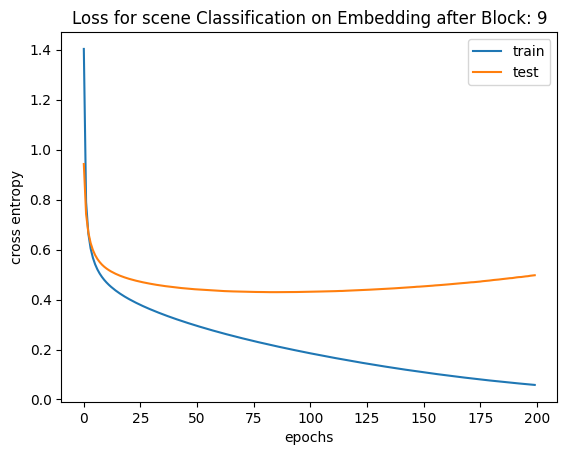

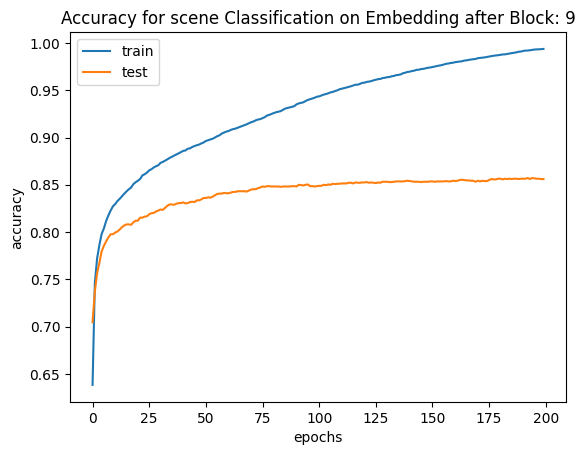

In [142]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [143]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [144]:
X_test=train_ready(test_data,col_name)

In [145]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

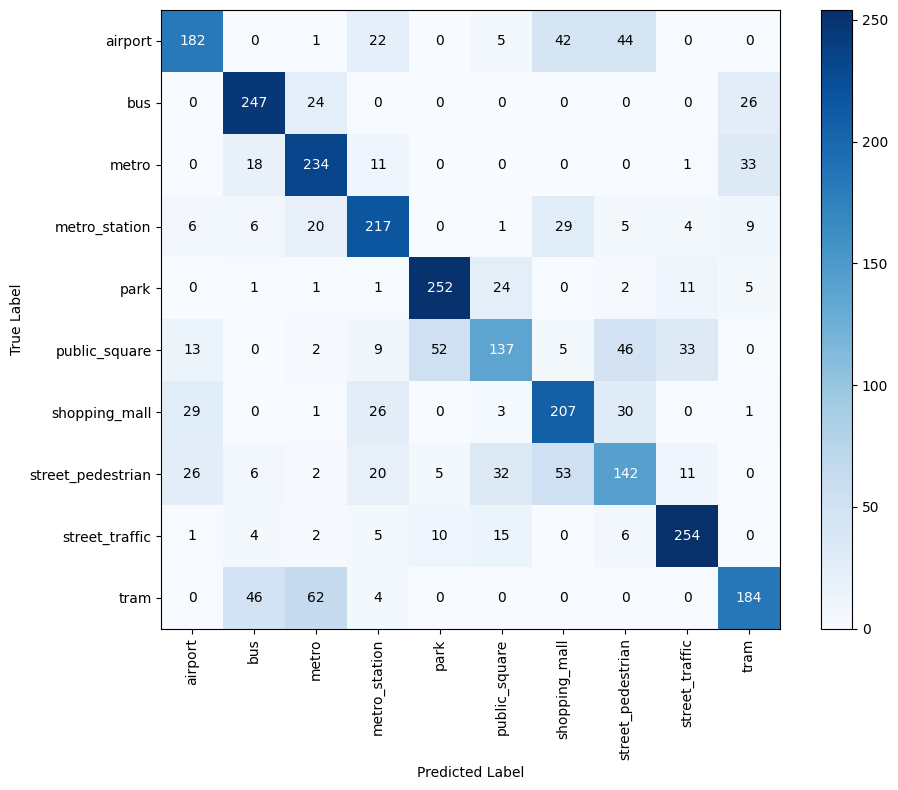

Accuracy: 0.6927


In [146]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-10

In [147]:
Block_number=10

In [148]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [149]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [150]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


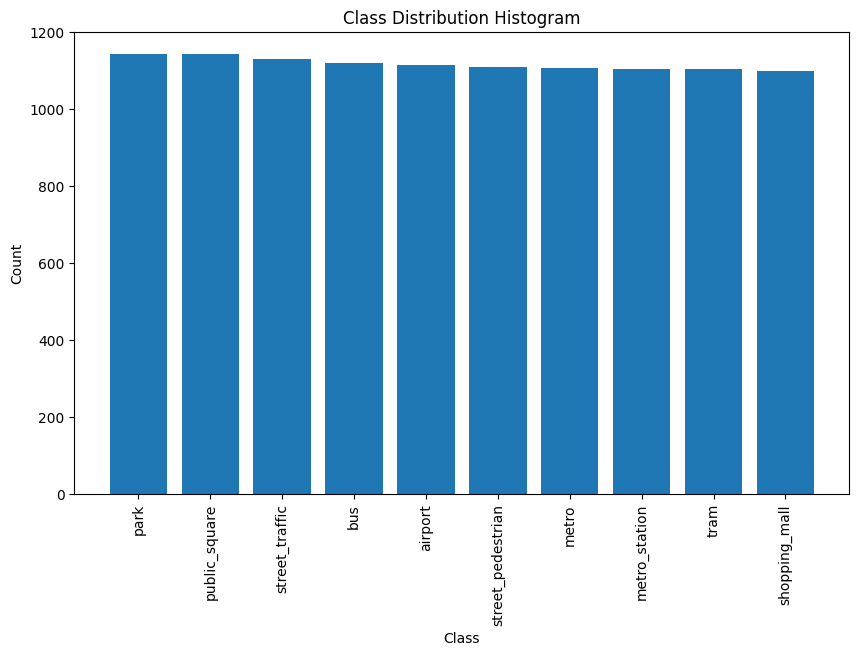

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [151]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


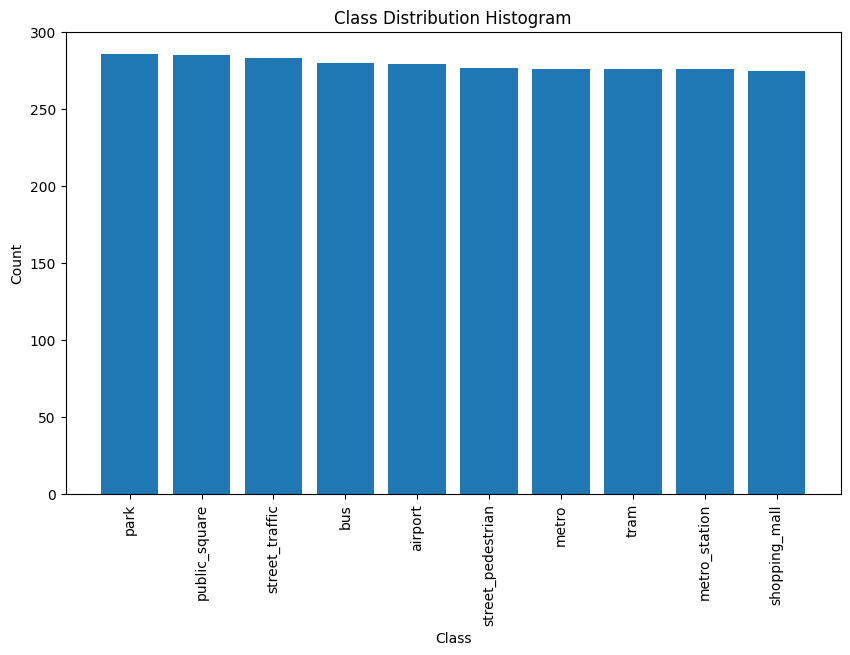

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [152]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [153]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [154]:
X_train_tensor.shape

torch.Size([11169, 768])

In [155]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [156]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 418.44batch/s, acc=0.781, loss=0.845]


Epoch 0 validation: Cross-entropy=0.83, Accuracy=74.4%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 365.22batch/s, acc=0.812, loss=0.66] 


Epoch 1 validation: Cross-entropy=0.66, Accuracy=76.9%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 411.21batch/s, acc=0.828, loss=0.604]


Epoch 2 validation: Cross-entropy=0.59, Accuracy=78.8%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 477.16batch/s, acc=0.828, loss=0.579]


Epoch 3 validation: Cross-entropy=0.55, Accuracy=79.9%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 366.43batch/s, acc=0.828, loss=0.565]


Epoch 4 validation: Cross-entropy=0.53, Accuracy=80.5%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 414.84batch/s, acc=0.828, loss=0.557]


Epoch 5 validation: Cross-entropy=0.51, Accuracy=81.1%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 485.02batch/s, acc=0.828, loss=0.551]


Epoch 6 validation: Cross-entropy=0.50, Accuracy=81.5%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 361.82batch/s, acc=0.828, loss=0.547]


Epoch 7 validation: Cross-entropy=0.49, Accuracy=81.9%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 417.49batch/s, acc=0.828, loss=0.542]


Epoch 8 validation: Cross-entropy=0.48, Accuracy=82.2%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 425.60batch/s, acc=0.828, loss=0.538]


Epoch 9 validation: Cross-entropy=0.47, Accuracy=82.4%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 481.19batch/s, acc=0.828, loss=0.533]


Epoch 10 validation: Cross-entropy=0.47, Accuracy=82.4%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 416.51batch/s, acc=0.828, loss=0.529]


Epoch 11 validation: Cross-entropy=0.46, Accuracy=82.6%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 371.43batch/s, acc=0.828, loss=0.524]


Epoch 12 validation: Cross-entropy=0.46, Accuracy=82.8%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 466.54batch/s, acc=0.828, loss=0.52] 


Epoch 13 validation: Cross-entropy=0.45, Accuracy=83.0%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 415.28batch/s, acc=0.828, loss=0.515]


Epoch 14 validation: Cross-entropy=0.45, Accuracy=83.0%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 418.55batch/s, acc=0.828, loss=0.511]


Epoch 15 validation: Cross-entropy=0.44, Accuracy=83.1%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 419.24batch/s, acc=0.828, loss=0.506]


Epoch 16 validation: Cross-entropy=0.44, Accuracy=83.3%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 425.64batch/s, acc=0.828, loss=0.502]


Epoch 17 validation: Cross-entropy=0.44, Accuracy=83.4%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 412.25batch/s, acc=0.828, loss=0.497]


Epoch 18 validation: Cross-entropy=0.43, Accuracy=83.4%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 411.19batch/s, acc=0.828, loss=0.493]


Epoch 19 validation: Cross-entropy=0.43, Accuracy=83.7%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 474.77batch/s, acc=0.828, loss=0.488]


Epoch 20 validation: Cross-entropy=0.43, Accuracy=83.8%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 426.97batch/s, acc=0.844, loss=0.483]


Epoch 21 validation: Cross-entropy=0.43, Accuracy=83.9%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 385.16batch/s, acc=0.844, loss=0.479]


Epoch 22 validation: Cross-entropy=0.43, Accuracy=84.0%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 416.68batch/s, acc=0.844, loss=0.475]


Epoch 23 validation: Cross-entropy=0.42, Accuracy=84.1%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 470.23batch/s, acc=0.844, loss=0.47] 


Epoch 24 validation: Cross-entropy=0.42, Accuracy=84.1%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 419.87batch/s, acc=0.844, loss=0.466]


Epoch 25 validation: Cross-entropy=0.42, Accuracy=84.1%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 423.29batch/s, acc=0.844, loss=0.461]


Epoch 26 validation: Cross-entropy=0.42, Accuracy=84.3%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 486.35batch/s, acc=0.844, loss=0.457]


Epoch 27 validation: Cross-entropy=0.42, Accuracy=84.5%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 377.11batch/s, acc=0.844, loss=0.452]


Epoch 28 validation: Cross-entropy=0.41, Accuracy=84.6%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 432.79batch/s, acc=0.844, loss=0.447]


Epoch 29 validation: Cross-entropy=0.41, Accuracy=84.7%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 480.16batch/s, acc=0.844, loss=0.443]


Epoch 30 validation: Cross-entropy=0.41, Accuracy=84.7%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 426.45batch/s, acc=0.844, loss=0.439]


Epoch 31 validation: Cross-entropy=0.41, Accuracy=84.8%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 424.79batch/s, acc=0.844, loss=0.434]


Epoch 32 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 413.86batch/s, acc=0.844, loss=0.43] 


Epoch 33 validation: Cross-entropy=0.41, Accuracy=85.0%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 428.02batch/s, acc=0.859, loss=0.426]


Epoch 34 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 424.37batch/s, acc=0.859, loss=0.422]


Epoch 35 validation: Cross-entropy=0.41, Accuracy=84.8%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 421.19batch/s, acc=0.859, loss=0.417]


Epoch 36 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 485.28batch/s, acc=0.859, loss=0.413]


Epoch 37 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 375.62batch/s, acc=0.859, loss=0.409]


Epoch 38 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 401.53batch/s, acc=0.859, loss=0.405]


Epoch 39 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 486.81batch/s, acc=0.859, loss=0.401]


Epoch 40 validation: Cross-entropy=0.40, Accuracy=84.8%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 417.05batch/s, acc=0.859, loss=0.397]


Epoch 41 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 415.42batch/s, acc=0.859, loss=0.392]


Epoch 42 validation: Cross-entropy=0.40, Accuracy=84.8%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 426.37batch/s, acc=0.859, loss=0.388]


Epoch 43 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 412.55batch/s, acc=0.859, loss=0.384]


Epoch 44 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 421.52batch/s, acc=0.859, loss=0.38] 


Epoch 45 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 424.94batch/s, acc=0.859, loss=0.376]


Epoch 46 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 486.33batch/s, acc=0.859, loss=0.372]


Epoch 47 validation: Cross-entropy=0.40, Accuracy=84.9%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 426.78batch/s, acc=0.875, loss=0.368]


Epoch 48 validation: Cross-entropy=0.40, Accuracy=84.8%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 382.18batch/s, acc=0.891, loss=0.364]


Epoch 49 validation: Cross-entropy=0.40, Accuracy=84.8%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 478.80batch/s, acc=0.891, loss=0.36] 


Epoch 50 validation: Cross-entropy=0.40, Accuracy=84.7%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 425.70batch/s, acc=0.891, loss=0.357]


Epoch 51 validation: Cross-entropy=0.39, Accuracy=84.9%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 425.45batch/s, acc=0.891, loss=0.353]


Epoch 52 validation: Cross-entropy=0.39, Accuracy=84.9%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 473.29batch/s, acc=0.891, loss=0.349]


Epoch 53 validation: Cross-entropy=0.39, Accuracy=84.9%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 371.50batch/s, acc=0.891, loss=0.345]


Epoch 54 validation: Cross-entropy=0.39, Accuracy=85.0%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 425.59batch/s, acc=0.891, loss=0.342]


Epoch 55 validation: Cross-entropy=0.39, Accuracy=85.1%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 473.05batch/s, acc=0.891, loss=0.338]


Epoch 56 validation: Cross-entropy=0.39, Accuracy=85.1%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 419.37batch/s, acc=0.891, loss=0.334]


Epoch 57 validation: Cross-entropy=0.39, Accuracy=85.1%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 423.41batch/s, acc=0.906, loss=0.33] 


Epoch 58 validation: Cross-entropy=0.39, Accuracy=85.2%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 373.52batch/s, acc=0.906, loss=0.327]


Epoch 59 validation: Cross-entropy=0.39, Accuracy=85.2%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 484.28batch/s, acc=0.906, loss=0.323]


Epoch 60 validation: Cross-entropy=0.39, Accuracy=85.2%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 428.98batch/s, acc=0.906, loss=0.32] 


Epoch 61 validation: Cross-entropy=0.39, Accuracy=85.2%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 420.95batch/s, acc=0.906, loss=0.317]


Epoch 62 validation: Cross-entropy=0.39, Accuracy=85.3%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 445.70batch/s, acc=0.906, loss=0.313]


Epoch 63 validation: Cross-entropy=0.39, Accuracy=85.4%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 398.34batch/s, acc=0.906, loss=0.309]


Epoch 64 validation: Cross-entropy=0.39, Accuracy=85.4%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 429.58batch/s, acc=0.906, loss=0.306] 


Epoch 65 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 433.72batch/s, acc=0.906, loss=0.303] 


Epoch 66 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 480.95batch/s, acc=0.906, loss=0.299] 


Epoch 67 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 423.65batch/s, acc=0.906, loss=0.296] 


Epoch 68 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 388.11batch/s, acc=0.906, loss=0.293] 


Epoch 69 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 476.35batch/s, acc=0.906, loss=0.289] 


Epoch 70 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 426.69batch/s, acc=0.906, loss=0.286] 


Epoch 71 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 425.28batch/s, acc=0.906, loss=0.283] 


Epoch 72 validation: Cross-entropy=0.39, Accuracy=85.6%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 424.50batch/s, acc=0.906, loss=0.28]  


Epoch 73 validation: Cross-entropy=0.39, Accuracy=85.6%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 486.38batch/s, acc=0.906, loss=0.277] 


Epoch 74 validation: Cross-entropy=0.39, Accuracy=85.7%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 366.07batch/s, acc=0.906, loss=0.274] 


Epoch 75 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 426.46batch/s, acc=0.906, loss=0.27]  


Epoch 76 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 481.35batch/s, acc=0.906, loss=0.267] 


Epoch 77 validation: Cross-entropy=0.39, Accuracy=85.9%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 426.43batch/s, acc=0.906, loss=0.263] 


Epoch 78 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 427.97batch/s, acc=0.906, loss=0.26]  


Epoch 79 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 417.34batch/s, acc=0.906, loss=0.257] 


Epoch 80 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 422.04batch/s, acc=0.906, loss=0.254] 


Epoch 81 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 418.43batch/s, acc=0.906, loss=0.251] 


Epoch 82 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 403.48batch/s, acc=0.906, loss=0.248] 


Epoch 83 validation: Cross-entropy=0.39, Accuracy=85.9%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 487.10batch/s, acc=0.906, loss=0.245] 


Epoch 84 validation: Cross-entropy=0.39, Accuracy=85.9%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 381.09batch/s, acc=0.906, loss=0.242] 


Epoch 85 validation: Cross-entropy=0.39, Accuracy=85.9%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 428.98batch/s, acc=0.906, loss=0.239] 


Epoch 86 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 487.30batch/s, acc=0.906, loss=0.236] 


Epoch 87 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 427.76batch/s, acc=0.906, loss=0.232] 


Epoch 88 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 428.37batch/s, acc=0.906, loss=0.229] 


Epoch 89 validation: Cross-entropy=0.39, Accuracy=85.9%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 377.52batch/s, acc=0.906, loss=0.227] 


Epoch 90 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 476.61batch/s, acc=0.906, loss=0.223] 


Epoch 91 validation: Cross-entropy=0.39, Accuracy=85.9%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 422.32batch/s, acc=0.906, loss=0.22]  


Epoch 92 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 422.88batch/s, acc=0.906, loss=0.217] 


Epoch 93 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 484.82batch/s, acc=0.906, loss=0.214] 


Epoch 94 validation: Cross-entropy=0.39, Accuracy=85.7%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 374.80batch/s, acc=0.906, loss=0.212] 


Epoch 95 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 422.97batch/s, acc=0.906, loss=0.209] 


Epoch 96 validation: Cross-entropy=0.40, Accuracy=85.7%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 480.35batch/s, acc=0.906, loss=0.206] 


Epoch 97 validation: Cross-entropy=0.40, Accuracy=85.8%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 429.05batch/s, acc=0.906, loss=0.203] 


Epoch 98 validation: Cross-entropy=0.40, Accuracy=85.8%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 428.62batch/s, acc=0.906, loss=0.199] 


Epoch 99 validation: Cross-entropy=0.40, Accuracy=85.8%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 421.42batch/s, acc=0.906, loss=0.196] 


Epoch 100 validation: Cross-entropy=0.40, Accuracy=85.8%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 422.25batch/s, acc=0.906, loss=0.194] 


Epoch 101 validation: Cross-entropy=0.40, Accuracy=85.8%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 417.16batch/s, acc=0.922, loss=0.191] 


Epoch 102 validation: Cross-entropy=0.40, Accuracy=85.8%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 428.59batch/s, acc=0.922, loss=0.188] 


Epoch 103 validation: Cross-entropy=0.40, Accuracy=85.7%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 486.99batch/s, acc=0.922, loss=0.185] 


Epoch 104 validation: Cross-entropy=0.40, Accuracy=85.9%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 427.85batch/s, acc=0.922, loss=0.182] 


Epoch 105 validation: Cross-entropy=0.40, Accuracy=85.8%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 362.12batch/s, acc=0.922, loss=0.178] 


Epoch 106 validation: Cross-entropy=0.40, Accuracy=85.8%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 421.91batch/s, acc=0.938, loss=0.175] 


Epoch 107 validation: Cross-entropy=0.40, Accuracy=85.9%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 483.65batch/s, acc=0.938, loss=0.174] 


Epoch 108 validation: Cross-entropy=0.40, Accuracy=86.0%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 417.45batch/s, acc=0.938, loss=0.17]  


Epoch 109 validation: Cross-entropy=0.40, Accuracy=86.0%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 413.40batch/s, acc=0.938, loss=0.168] 


Epoch 110 validation: Cross-entropy=0.40, Accuracy=86.0%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 382.09batch/s, acc=0.938, loss=0.164] 


Epoch 111 validation: Cross-entropy=0.40, Accuracy=85.9%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 465.42batch/s, acc=0.938, loss=0.161] 


Epoch 112 validation: Cross-entropy=0.40, Accuracy=86.0%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 425.10batch/s, acc=0.938, loss=0.159] 


Epoch 113 validation: Cross-entropy=0.40, Accuracy=86.1%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 489.93batch/s, acc=0.938, loss=0.156] 


Epoch 114 validation: Cross-entropy=0.41, Accuracy=86.0%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 420.63batch/s, acc=0.938, loss=0.153] 


Epoch 115 validation: Cross-entropy=0.41, Accuracy=86.0%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 408.74batch/s, acc=0.938, loss=0.151] 


Epoch 116 validation: Cross-entropy=0.41, Accuracy=86.1%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 393.42batch/s, acc=0.938, loss=0.147] 


Epoch 117 validation: Cross-entropy=0.41, Accuracy=86.1%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 484.25batch/s, acc=0.953, loss=0.145] 


Epoch 118 validation: Cross-entropy=0.41, Accuracy=86.1%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 422.20batch/s, acc=0.953, loss=0.142] 


Epoch 119 validation: Cross-entropy=0.41, Accuracy=86.1%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 426.95batch/s, acc=0.953, loss=0.14]  


Epoch 120 validation: Cross-entropy=0.41, Accuracy=86.0%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 484.78batch/s, acc=0.953, loss=0.137] 


Epoch 121 validation: Cross-entropy=0.41, Accuracy=86.1%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 359.54batch/s, acc=0.953, loss=0.134] 


Epoch 122 validation: Cross-entropy=0.41, Accuracy=86.2%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 428.66batch/s, acc=0.953, loss=0.132] 


Epoch 123 validation: Cross-entropy=0.41, Accuracy=86.2%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 483.18batch/s, acc=0.953, loss=0.129] 


Epoch 124 validation: Cross-entropy=0.41, Accuracy=86.1%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 425.97batch/s, acc=0.953, loss=0.127] 


Epoch 125 validation: Cross-entropy=0.41, Accuracy=86.1%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 425.10batch/s, acc=0.953, loss=0.124] 


Epoch 126 validation: Cross-entropy=0.41, Accuracy=86.2%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 401.39batch/s, acc=0.953, loss=0.122] 


Epoch 127 validation: Cross-entropy=0.41, Accuracy=86.2%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 460.10batch/s, acc=0.953, loss=0.119] 


Epoch 128 validation: Cross-entropy=0.42, Accuracy=86.1%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 422.08batch/s, acc=0.953, loss=0.117] 


Epoch 129 validation: Cross-entropy=0.42, Accuracy=86.1%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 454.97batch/s, acc=0.953, loss=0.115] 


Epoch 130 validation: Cross-entropy=0.42, Accuracy=86.2%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 455.35batch/s, acc=0.953, loss=0.113] 


Epoch 131 validation: Cross-entropy=0.42, Accuracy=86.1%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 376.49batch/s, acc=0.969, loss=0.11]  


Epoch 132 validation: Cross-entropy=0.42, Accuracy=86.1%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 424.68batch/s, acc=0.969, loss=0.108] 


Epoch 133 validation: Cross-entropy=0.42, Accuracy=86.1%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 481.57batch/s, acc=0.969, loss=0.106] 


Epoch 134 validation: Cross-entropy=0.42, Accuracy=86.1%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 431.42batch/s, acc=0.984, loss=0.104] 


Epoch 135 validation: Cross-entropy=0.42, Accuracy=86.1%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 414.58batch/s, acc=0.984, loss=0.101] 


Epoch 136 validation: Cross-entropy=0.42, Accuracy=86.1%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 422.54batch/s, acc=0.984, loss=0.0996]


Epoch 137 validation: Cross-entropy=0.42, Accuracy=86.1%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 425.14batch/s, acc=0.984, loss=0.0978]


Epoch 138 validation: Cross-entropy=0.42, Accuracy=86.1%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 424.08batch/s, acc=0.984, loss=0.0959]


Epoch 139 validation: Cross-entropy=0.43, Accuracy=86.1%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 401.62batch/s, acc=0.984, loss=0.0943]


Epoch 140 validation: Cross-entropy=0.43, Accuracy=86.1%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 481.76batch/s, acc=0.984, loss=0.0926]


Epoch 141 validation: Cross-entropy=0.43, Accuracy=86.1%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 375.49batch/s, acc=0.984, loss=0.0905]


Epoch 142 validation: Cross-entropy=0.43, Accuracy=86.2%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 416.37batch/s, acc=1, loss=0.0882]    


Epoch 143 validation: Cross-entropy=0.43, Accuracy=86.2%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 489.17batch/s, acc=1, loss=0.0865]    


Epoch 144 validation: Cross-entropy=0.43, Accuracy=86.1%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 407.95batch/s, acc=1, loss=0.0852]    


Epoch 145 validation: Cross-entropy=0.43, Accuracy=86.3%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 422.96batch/s, acc=1, loss=0.0832]    


Epoch 146 validation: Cross-entropy=0.43, Accuracy=86.3%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 365.71batch/s, acc=1, loss=0.0819]    


Epoch 147 validation: Cross-entropy=0.43, Accuracy=86.4%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 488.79batch/s, acc=1, loss=0.0807]    


Epoch 148 validation: Cross-entropy=0.44, Accuracy=86.3%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 423.64batch/s, acc=1, loss=0.0787]    


Epoch 149 validation: Cross-entropy=0.44, Accuracy=86.5%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 425.41batch/s, acc=1, loss=0.077]     


Epoch 150 validation: Cross-entropy=0.44, Accuracy=86.4%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 487.70batch/s, acc=1, loss=0.0756]    


Epoch 151 validation: Cross-entropy=0.44, Accuracy=86.4%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 432.34batch/s, acc=1, loss=0.0742]    


Epoch 152 validation: Cross-entropy=0.44, Accuracy=86.5%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 372.78batch/s, acc=1, loss=0.0725]    


Epoch 153 validation: Cross-entropy=0.44, Accuracy=86.5%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 487.57batch/s, acc=1, loss=0.0715]    


Epoch 154 validation: Cross-entropy=0.44, Accuracy=86.4%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 422.57batch/s, acc=1, loss=0.0701]    


Epoch 155 validation: Cross-entropy=0.44, Accuracy=86.4%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 429.26batch/s, acc=1, loss=0.0688]    


Epoch 156 validation: Cross-entropy=0.44, Accuracy=86.4%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 424.95batch/s, acc=1, loss=0.0671]    


Epoch 157 validation: Cross-entropy=0.45, Accuracy=86.3%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 419.96batch/s, acc=1, loss=0.066]     


Epoch 158 validation: Cross-entropy=0.45, Accuracy=86.4%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 429.33batch/s, acc=1, loss=0.0643]    


Epoch 159 validation: Cross-entropy=0.45, Accuracy=86.3%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 412.10batch/s, acc=1, loss=0.0639]    


Epoch 160 validation: Cross-entropy=0.45, Accuracy=86.3%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 484.16batch/s, acc=1, loss=0.0622]    


Epoch 161 validation: Cross-entropy=0.45, Accuracy=86.4%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 423.78batch/s, acc=1, loss=0.0613]    


Epoch 162 validation: Cross-entropy=0.45, Accuracy=86.3%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 364.60batch/s, acc=1, loss=0.06]      


Epoch 163 validation: Cross-entropy=0.45, Accuracy=86.3%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 482.85batch/s, acc=1, loss=0.0585]    


Epoch 164 validation: Cross-entropy=0.45, Accuracy=86.3%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 442.14batch/s, acc=1, loss=0.0573]    


Epoch 165 validation: Cross-entropy=0.46, Accuracy=86.3%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 427.21batch/s, acc=1, loss=0.0563]    


Epoch 166 validation: Cross-entropy=0.46, Accuracy=86.2%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 486.19batch/s, acc=1, loss=0.0549]    


Epoch 167 validation: Cross-entropy=0.46, Accuracy=86.3%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 376.66batch/s, acc=1, loss=0.054]     


Epoch 168 validation: Cross-entropy=0.46, Accuracy=86.3%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 424.93batch/s, acc=1, loss=0.0525]    


Epoch 169 validation: Cross-entropy=0.46, Accuracy=86.4%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 482.83batch/s, acc=1, loss=0.0517]    


Epoch 170 validation: Cross-entropy=0.46, Accuracy=86.3%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 425.57batch/s, acc=1, loss=0.0506]    


Epoch 171 validation: Cross-entropy=0.46, Accuracy=86.3%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 421.84batch/s, acc=1, loss=0.0493]    


Epoch 172 validation: Cross-entropy=0.47, Accuracy=86.2%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 428.89batch/s, acc=1, loss=0.0487]    


Epoch 173 validation: Cross-entropy=0.47, Accuracy=86.3%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 421.81batch/s, acc=1, loss=0.0471]    


Epoch 174 validation: Cross-entropy=0.47, Accuracy=86.2%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 422.72batch/s, acc=1, loss=0.0467]    


Epoch 175 validation: Cross-entropy=0.47, Accuracy=86.2%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 427.90batch/s, acc=1, loss=0.0455]    


Epoch 176 validation: Cross-entropy=0.47, Accuracy=86.2%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 482.44batch/s, acc=1, loss=0.0447]    


Epoch 177 validation: Cross-entropy=0.47, Accuracy=86.2%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 424.96batch/s, acc=1, loss=0.0439]    


Epoch 178 validation: Cross-entropy=0.47, Accuracy=86.2%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 370.17batch/s, acc=1, loss=0.0429]    


Epoch 179 validation: Cross-entropy=0.48, Accuracy=86.2%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 429.11batch/s, acc=1, loss=0.0417]    


Epoch 180 validation: Cross-entropy=0.48, Accuracy=86.2%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 486.68batch/s, acc=1, loss=0.0407]    


Epoch 181 validation: Cross-entropy=0.48, Accuracy=86.2%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 408.32batch/s, acc=1, loss=0.0406]    


Epoch 182 validation: Cross-entropy=0.48, Accuracy=86.2%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 410.30batch/s, acc=1, loss=0.0393]    


Epoch 183 validation: Cross-entropy=0.48, Accuracy=86.2%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 419.86batch/s, acc=1, loss=0.0385]    


Epoch 184 validation: Cross-entropy=0.48, Accuracy=86.2%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 408.06batch/s, acc=1, loss=0.0375]    


Epoch 185 validation: Cross-entropy=0.48, Accuracy=86.3%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 425.49batch/s, acc=1, loss=0.0369]    


Epoch 186 validation: Cross-entropy=0.49, Accuracy=86.2%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 483.42batch/s, acc=1, loss=0.036]     


Epoch 187 validation: Cross-entropy=0.49, Accuracy=86.3%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 414.37batch/s, acc=1, loss=0.035]     


Epoch 188 validation: Cross-entropy=0.49, Accuracy=86.3%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 375.20batch/s, acc=1, loss=0.0345]    


Epoch 189 validation: Cross-entropy=0.49, Accuracy=86.2%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 476.74batch/s, acc=1, loss=0.034]     


Epoch 190 validation: Cross-entropy=0.49, Accuracy=86.2%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 427.21batch/s, acc=1, loss=0.0326]    


Epoch 191 validation: Cross-entropy=0.49, Accuracy=86.1%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 428.16batch/s, acc=1, loss=0.0318]    


Epoch 192 validation: Cross-entropy=0.50, Accuracy=86.1%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 423.27batch/s, acc=1, loss=0.0314]   


Epoch 193 validation: Cross-entropy=0.50, Accuracy=86.2%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 485.19batch/s, acc=1, loss=0.0301]   


Epoch 194 validation: Cross-entropy=0.50, Accuracy=86.2%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 365.11batch/s, acc=1, loss=0.03]     


Epoch 195 validation: Cross-entropy=0.50, Accuracy=86.2%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 430.45batch/s, acc=1, loss=0.0289]   


Epoch 196 validation: Cross-entropy=0.50, Accuracy=86.2%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 460.96batch/s, acc=1, loss=0.028]    


Epoch 197 validation: Cross-entropy=0.50, Accuracy=86.1%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 451.64batch/s, acc=1, loss=0.0276]   


Epoch 198 validation: Cross-entropy=0.51, Accuracy=86.2%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 428.88batch/s, acc=1, loss=0.027]    


Epoch 199 validation: Cross-entropy=0.51, Accuracy=86.2%


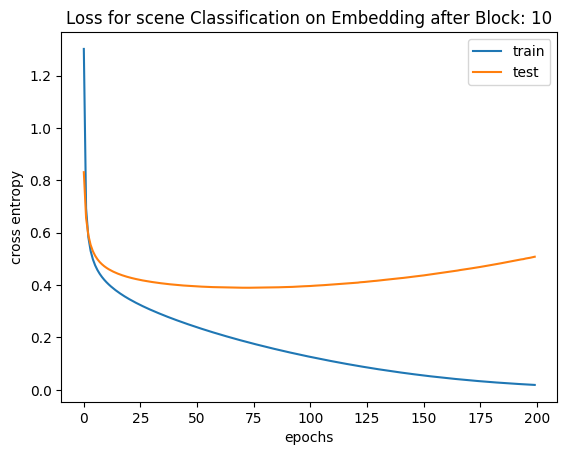

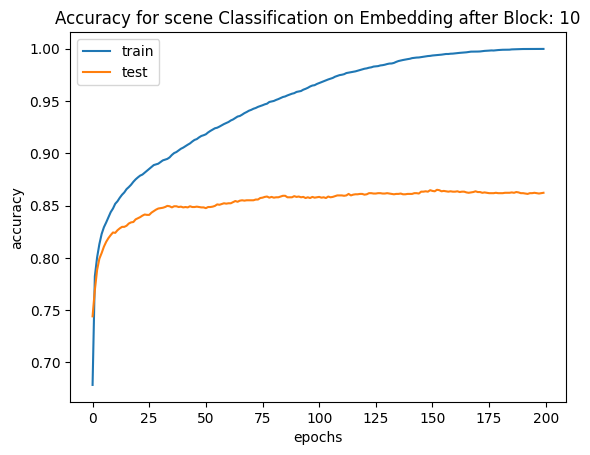

In [157]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [158]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [159]:
X_test=train_ready(test_data,col_name)

In [160]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

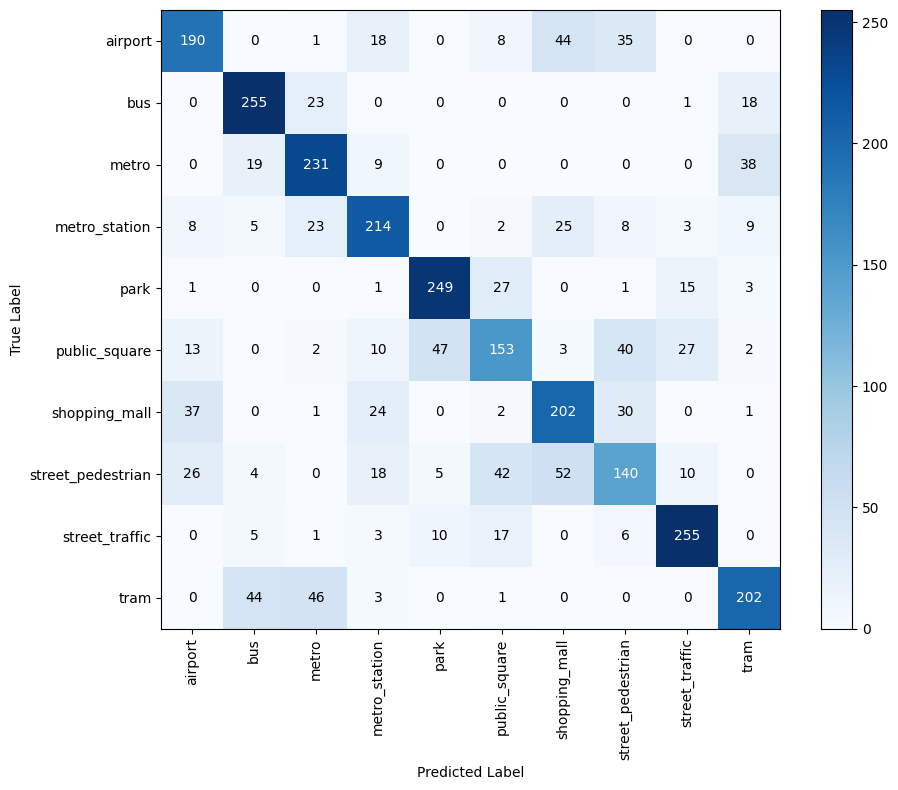

Accuracy: 0.7045


In [161]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-11

In [162]:
Block_number=11

In [163]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [164]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [165]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


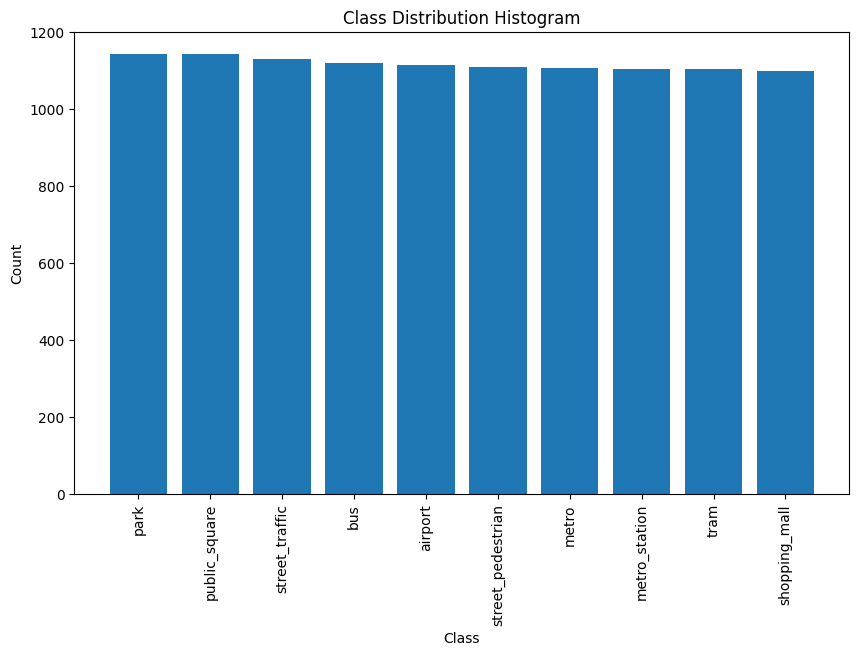

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [166]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


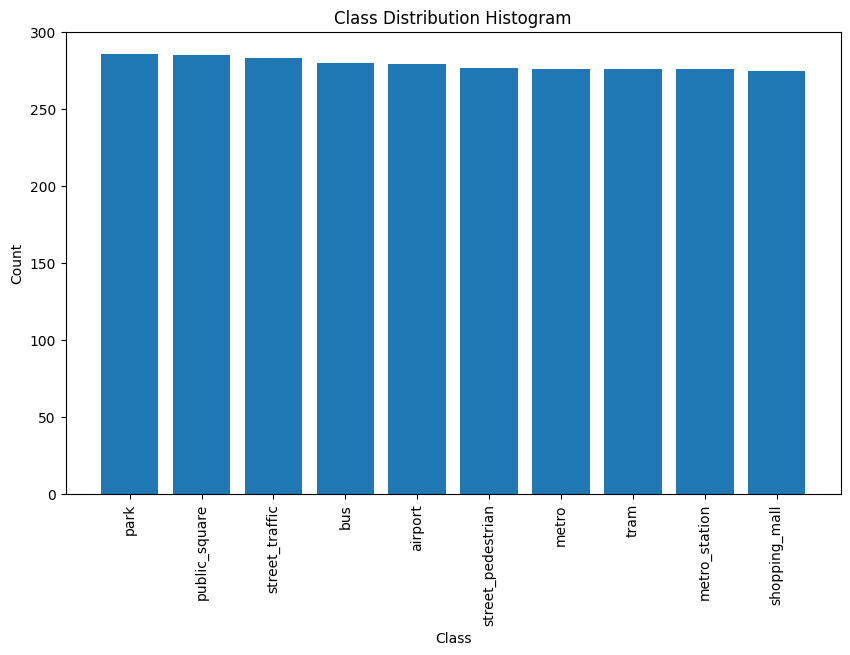

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [167]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [168]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [169]:
X_train_tensor.shape

torch.Size([11169, 768])

In [170]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [171]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 341.89batch/s, acc=0.812, loss=0.644]


Epoch 0 validation: Cross-entropy=0.62, Accuracy=80.1%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 405.51batch/s, acc=0.844, loss=0.551]


Epoch 1 validation: Cross-entropy=0.50, Accuracy=82.8%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 460.76batch/s, acc=0.828, loss=0.538]


Epoch 2 validation: Cross-entropy=0.46, Accuracy=83.9%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 374.39batch/s, acc=0.828, loss=0.533]


Epoch 3 validation: Cross-entropy=0.44, Accuracy=84.3%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 407.42batch/s, acc=0.812, loss=0.532]


Epoch 4 validation: Cross-entropy=0.42, Accuracy=84.6%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 455.46batch/s, acc=0.812, loss=0.53] 


Epoch 5 validation: Cross-entropy=0.41, Accuracy=84.9%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 354.51batch/s, acc=0.812, loss=0.528]


Epoch 6 validation: Cross-entropy=0.40, Accuracy=85.0%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 407.22batch/s, acc=0.812, loss=0.525]


Epoch 7 validation: Cross-entropy=0.40, Accuracy=85.2%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 409.76batch/s, acc=0.812, loss=0.521]


Epoch 8 validation: Cross-entropy=0.39, Accuracy=85.5%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 469.57batch/s, acc=0.812, loss=0.518]


Epoch 9 validation: Cross-entropy=0.39, Accuracy=85.8%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 415.91batch/s, acc=0.812, loss=0.514]


Epoch 10 validation: Cross-entropy=0.38, Accuracy=86.1%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 365.87batch/s, acc=0.812, loss=0.51] 


Epoch 11 validation: Cross-entropy=0.38, Accuracy=86.4%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 417.72batch/s, acc=0.812, loss=0.507]


Epoch 12 validation: Cross-entropy=0.38, Accuracy=86.6%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 463.68batch/s, acc=0.812, loss=0.503]


Epoch 13 validation: Cross-entropy=0.37, Accuracy=86.5%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 411.41batch/s, acc=0.828, loss=0.499]


Epoch 14 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 413.19batch/s, acc=0.828, loss=0.495]


Epoch 15 validation: Cross-entropy=0.37, Accuracy=86.6%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 404.91batch/s, acc=0.828, loss=0.491]


Epoch 16 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 411.12batch/s, acc=0.828, loss=0.487]


Epoch 17 validation: Cross-entropy=0.37, Accuracy=86.2%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 407.22batch/s, acc=0.828, loss=0.482]


Epoch 18 validation: Cross-entropy=0.36, Accuracy=86.4%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 409.07batch/s, acc=0.828, loss=0.478]


Epoch 19 validation: Cross-entropy=0.36, Accuracy=86.5%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 458.08batch/s, acc=0.828, loss=0.474]


Epoch 20 validation: Cross-entropy=0.36, Accuracy=86.6%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 370.88batch/s, acc=0.828, loss=0.47] 


Epoch 21 validation: Cross-entropy=0.36, Accuracy=86.8%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 405.28batch/s, acc=0.828, loss=0.466]


Epoch 22 validation: Cross-entropy=0.36, Accuracy=86.8%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 468.22batch/s, acc=0.828, loss=0.462]


Epoch 23 validation: Cross-entropy=0.36, Accuracy=86.9%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 420.69batch/s, acc=0.828, loss=0.457]


Epoch 24 validation: Cross-entropy=0.36, Accuracy=87.0%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 412.13batch/s, acc=0.828, loss=0.452]


Epoch 25 validation: Cross-entropy=0.36, Accuracy=87.0%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 467.07batch/s, acc=0.828, loss=0.448]


Epoch 26 validation: Cross-entropy=0.35, Accuracy=87.1%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 359.66batch/s, acc=0.828, loss=0.443]


Epoch 27 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 419.68batch/s, acc=0.828, loss=0.439]


Epoch 28 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 472.05batch/s, acc=0.844, loss=0.434]


Epoch 29 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 418.82batch/s, acc=0.844, loss=0.43] 


Epoch 30 validation: Cross-entropy=0.35, Accuracy=87.2%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 416.87batch/s, acc=0.844, loss=0.425]


Epoch 31 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 367.93batch/s, acc=0.844, loss=0.421]


Epoch 32 validation: Cross-entropy=0.35, Accuracy=87.2%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 473.13batch/s, acc=0.844, loss=0.416]


Epoch 33 validation: Cross-entropy=0.35, Accuracy=87.2%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 419.04batch/s, acc=0.844, loss=0.411]


Epoch 34 validation: Cross-entropy=0.35, Accuracy=87.2%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 411.12batch/s, acc=0.844, loss=0.407]


Epoch 35 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 430.46batch/s, acc=0.844, loss=0.402]


Epoch 36 validation: Cross-entropy=0.35, Accuracy=87.2%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 407.01batch/s, acc=0.844, loss=0.397]


Epoch 37 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 417.58batch/s, acc=0.844, loss=0.392]


Epoch 38 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 416.62batch/s, acc=0.844, loss=0.387]


Epoch 39 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 477.44batch/s, acc=0.844, loss=0.382]


Epoch 40 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 421.97batch/s, acc=0.844, loss=0.377]


Epoch 41 validation: Cross-entropy=0.35, Accuracy=87.2%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 367.85batch/s, acc=0.844, loss=0.372]


Epoch 42 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 417.86batch/s, acc=0.859, loss=0.367]


Epoch 43 validation: Cross-entropy=0.35, Accuracy=87.4%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 434.76batch/s, acc=0.859, loss=0.362] 


Epoch 44 validation: Cross-entropy=0.35, Accuracy=87.5%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 461.77batch/s, acc=0.859, loss=0.357] 


Epoch 45 validation: Cross-entropy=0.35, Accuracy=87.5%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 417.75batch/s, acc=0.859, loss=0.352] 


Epoch 46 validation: Cross-entropy=0.35, Accuracy=87.5%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 364.52batch/s, acc=0.859, loss=0.347] 


Epoch 47 validation: Cross-entropy=0.35, Accuracy=87.5%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 466.76batch/s, acc=0.859, loss=0.343] 


Epoch 48 validation: Cross-entropy=0.35, Accuracy=87.5%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 421.87batch/s, acc=0.859, loss=0.337] 


Epoch 49 validation: Cross-entropy=0.35, Accuracy=87.4%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 415.69batch/s, acc=0.859, loss=0.332] 


Epoch 50 validation: Cross-entropy=0.35, Accuracy=87.5%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 472.97batch/s, acc=0.859, loss=0.327] 


Epoch 51 validation: Cross-entropy=0.35, Accuracy=87.5%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 373.75batch/s, acc=0.859, loss=0.322] 


Epoch 52 validation: Cross-entropy=0.35, Accuracy=87.6%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 416.43batch/s, acc=0.859, loss=0.317] 


Epoch 53 validation: Cross-entropy=0.35, Accuracy=87.6%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 410.18batch/s, acc=0.859, loss=0.313] 


Epoch 54 validation: Cross-entropy=0.35, Accuracy=87.7%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 469.55batch/s, acc=0.859, loss=0.307] 


Epoch 55 validation: Cross-entropy=0.35, Accuracy=87.8%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 419.05batch/s, acc=0.859, loss=0.303] 


Epoch 56 validation: Cross-entropy=0.35, Accuracy=87.8%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 418.33batch/s, acc=0.859, loss=0.298] 


Epoch 57 validation: Cross-entropy=0.35, Accuracy=87.8%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 415.68batch/s, acc=0.875, loss=0.293] 


Epoch 58 validation: Cross-entropy=0.35, Accuracy=87.9%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 419.87batch/s, acc=0.875, loss=0.289] 


Epoch 59 validation: Cross-entropy=0.35, Accuracy=87.8%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 419.99batch/s, acc=0.875, loss=0.283] 


Epoch 60 validation: Cross-entropy=0.35, Accuracy=87.9%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 417.12batch/s, acc=0.875, loss=0.279] 


Epoch 61 validation: Cross-entropy=0.35, Accuracy=87.8%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 478.00batch/s, acc=0.891, loss=0.274] 


Epoch 62 validation: Cross-entropy=0.35, Accuracy=87.8%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 355.02batch/s, acc=0.891, loss=0.27]  


Epoch 63 validation: Cross-entropy=0.35, Accuracy=87.8%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 409.84batch/s, acc=0.891, loss=0.264] 


Epoch 64 validation: Cross-entropy=0.35, Accuracy=87.9%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 474.92batch/s, acc=0.891, loss=0.26]  


Epoch 65 validation: Cross-entropy=0.35, Accuracy=87.9%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 412.35batch/s, acc=0.891, loss=0.255] 


Epoch 66 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 415.15batch/s, acc=0.891, loss=0.251] 


Epoch 67 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 395.87batch/s, acc=0.891, loss=0.247] 


Epoch 68 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 412.36batch/s, acc=0.891, loss=0.242] 


Epoch 69 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 322.38batch/s, acc=0.891, loss=0.237] 


Epoch 70 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 292.57batch/s, acc=0.906, loss=0.232] 


Epoch 71 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 364.03batch/s, acc=0.922, loss=0.227] 


Epoch 72 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 380.56batch/s, acc=0.922, loss=0.223] 


Epoch 73 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 397.97batch/s, acc=0.922, loss=0.218] 


Epoch 74 validation: Cross-entropy=0.35, Accuracy=88.2%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 380.10batch/s, acc=0.922, loss=0.214] 


Epoch 75 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 386.85batch/s, acc=0.922, loss=0.209] 


Epoch 76 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 387.21batch/s, acc=0.922, loss=0.205] 


Epoch 77 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 453.64batch/s, acc=0.922, loss=0.201] 


Epoch 78 validation: Cross-entropy=0.36, Accuracy=88.2%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 393.14batch/s, acc=0.922, loss=0.196] 


Epoch 79 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 346.11batch/s, acc=0.922, loss=0.192] 


Epoch 80 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 447.03batch/s, acc=0.922, loss=0.187] 


Epoch 81 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 390.17batch/s, acc=0.922, loss=0.182] 


Epoch 82 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 394.42batch/s, acc=0.938, loss=0.179] 


Epoch 83 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 388.05batch/s, acc=0.953, loss=0.175] 


Epoch 84 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 392.29batch/s, acc=0.953, loss=0.171] 


Epoch 85 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 395.03batch/s, acc=0.953, loss=0.166] 


Epoch 86 validation: Cross-entropy=0.36, Accuracy=88.3%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 450.15batch/s, acc=0.953, loss=0.162] 


Epoch 87 validation: Cross-entropy=0.36, Accuracy=88.2%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 384.96batch/s, acc=0.953, loss=0.158] 


Epoch 88 validation: Cross-entropy=0.36, Accuracy=88.2%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 342.95batch/s, acc=0.953, loss=0.154] 


Epoch 89 validation: Cross-entropy=0.36, Accuracy=88.2%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 433.44batch/s, acc=0.953, loss=0.15]  


Epoch 90 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 407.71batch/s, acc=0.969, loss=0.146] 


Epoch 91 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 403.21batch/s, acc=0.969, loss=0.142] 


Epoch 92 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 389.56batch/s, acc=0.969, loss=0.139] 


Epoch 93 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 392.91batch/s, acc=0.969, loss=0.135] 


Epoch 94 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 392.92batch/s, acc=0.969, loss=0.131] 


Epoch 95 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 445.63batch/s, acc=0.969, loss=0.128] 


Epoch 96 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 402.69batch/s, acc=0.969, loss=0.123] 


Epoch 97 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 346.76batch/s, acc=0.969, loss=0.12]  


Epoch 98 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 450.36batch/s, acc=0.969, loss=0.116] 


Epoch 99 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 397.81batch/s, acc=0.969, loss=0.112] 


Epoch 100 validation: Cross-entropy=0.37, Accuracy=88.2%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 404.10batch/s, acc=0.969, loss=0.11]  


Epoch 101 validation: Cross-entropy=0.38, Accuracy=88.3%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 388.07batch/s, acc=0.969, loss=0.105] 


Epoch 102 validation: Cross-entropy=0.38, Accuracy=88.2%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 400.10batch/s, acc=0.969, loss=0.103] 


Epoch 103 validation: Cross-entropy=0.38, Accuracy=88.3%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 383.98batch/s, acc=0.969, loss=0.0991]


Epoch 104 validation: Cross-entropy=0.38, Accuracy=88.4%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 454.91batch/s, acc=0.984, loss=0.0956]


Epoch 105 validation: Cross-entropy=0.38, Accuracy=88.4%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 355.55batch/s, acc=0.984, loss=0.0931]


Epoch 106 validation: Cross-entropy=0.38, Accuracy=88.4%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 394.13batch/s, acc=0.984, loss=0.0896]


Epoch 107 validation: Cross-entropy=0.38, Accuracy=88.3%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 453.80batch/s, acc=0.984, loss=0.0872]


Epoch 108 validation: Cross-entropy=0.38, Accuracy=88.4%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 393.15batch/s, acc=0.984, loss=0.0847]


Epoch 109 validation: Cross-entropy=0.38, Accuracy=88.3%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 399.36batch/s, acc=0.984, loss=0.0817]


Epoch 110 validation: Cross-entropy=0.39, Accuracy=88.3%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 386.94batch/s, acc=0.984, loss=0.0793]


Epoch 111 validation: Cross-entropy=0.39, Accuracy=88.4%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 386.03batch/s, acc=0.984, loss=0.0771]


Epoch 112 validation: Cross-entropy=0.39, Accuracy=88.4%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 395.38batch/s, acc=0.984, loss=0.074] 


Epoch 113 validation: Cross-entropy=0.39, Accuracy=88.4%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 458.00batch/s, acc=0.984, loss=0.0717]


Epoch 114 validation: Cross-entropy=0.39, Accuracy=88.3%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 351.13batch/s, acc=0.984, loss=0.0696]


Epoch 115 validation: Cross-entropy=0.39, Accuracy=88.4%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 402.42batch/s, acc=0.984, loss=0.0671]


Epoch 116 validation: Cross-entropy=0.39, Accuracy=88.4%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 447.60batch/s, acc=0.984, loss=0.0651]


Epoch 117 validation: Cross-entropy=0.39, Accuracy=88.4%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 391.83batch/s, acc=0.984, loss=0.0628]


Epoch 118 validation: Cross-entropy=0.40, Accuracy=88.3%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 403.82batch/s, acc=0.984, loss=0.0608]


Epoch 119 validation: Cross-entropy=0.40, Accuracy=88.4%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 389.67batch/s, acc=0.984, loss=0.0592]


Epoch 120 validation: Cross-entropy=0.40, Accuracy=88.3%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 397.31batch/s, acc=0.984, loss=0.057] 


Epoch 121 validation: Cross-entropy=0.40, Accuracy=88.4%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 398.03batch/s, acc=1, loss=0.0551]    


Epoch 122 validation: Cross-entropy=0.40, Accuracy=88.4%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 454.20batch/s, acc=1, loss=0.0534]    


Epoch 123 validation: Cross-entropy=0.40, Accuracy=88.3%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 347.70batch/s, acc=1, loss=0.0519]    


Epoch 124 validation: Cross-entropy=0.41, Accuracy=88.2%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 394.10batch/s, acc=1, loss=0.05]      


Epoch 125 validation: Cross-entropy=0.41, Accuracy=88.3%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 436.35batch/s, acc=1, loss=0.0488]    


Epoch 126 validation: Cross-entropy=0.41, Accuracy=88.4%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 398.69batch/s, acc=1, loss=0.0468]    


Epoch 127 validation: Cross-entropy=0.41, Accuracy=88.3%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 393.38batch/s, acc=1, loss=0.0455]    


Epoch 128 validation: Cross-entropy=0.41, Accuracy=88.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 377.19batch/s, acc=1, loss=0.0439]    


Epoch 129 validation: Cross-entropy=0.41, Accuracy=88.3%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 394.11batch/s, acc=1, loss=0.0424]    


Epoch 130 validation: Cross-entropy=0.42, Accuracy=88.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 397.02batch/s, acc=1, loss=0.0413]    


Epoch 131 validation: Cross-entropy=0.42, Accuracy=88.3%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 448.70batch/s, acc=1, loss=0.0398]    


Epoch 132 validation: Cross-entropy=0.42, Accuracy=88.3%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 350.27batch/s, acc=1, loss=0.0383]    


Epoch 133 validation: Cross-entropy=0.42, Accuracy=88.3%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 392.50batch/s, acc=1, loss=0.0371]    


Epoch 134 validation: Cross-entropy=0.42, Accuracy=88.2%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 454.37batch/s, acc=1, loss=0.0361]    


Epoch 135 validation: Cross-entropy=0.42, Accuracy=88.3%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 396.14batch/s, acc=1, loss=0.0345]    


Epoch 136 validation: Cross-entropy=0.43, Accuracy=88.3%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 348.02batch/s, acc=1, loss=0.0335]    


Epoch 137 validation: Cross-entropy=0.43, Accuracy=88.2%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 443.91batch/s, acc=1, loss=0.0324]    


Epoch 138 validation: Cross-entropy=0.43, Accuracy=88.3%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 379.17batch/s, acc=1, loss=0.0314]    


Epoch 139 validation: Cross-entropy=0.43, Accuracy=88.3%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 397.97batch/s, acc=1, loss=0.0302]    


Epoch 140 validation: Cross-entropy=0.43, Accuracy=88.3%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 446.49batch/s, acc=1, loss=0.029]     


Epoch 141 validation: Cross-entropy=0.44, Accuracy=88.2%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 341.43batch/s, acc=1, loss=0.0284]    


Epoch 142 validation: Cross-entropy=0.44, Accuracy=88.2%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 383.44batch/s, acc=1, loss=0.0273]    


Epoch 143 validation: Cross-entropy=0.44, Accuracy=88.3%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 448.82batch/s, acc=1, loss=0.0265]    


Epoch 144 validation: Cross-entropy=0.44, Accuracy=88.3%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 401.18batch/s, acc=1, loss=0.0254]    


Epoch 145 validation: Cross-entropy=0.44, Accuracy=88.2%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 350.31batch/s, acc=1, loss=0.0245]    


Epoch 146 validation: Cross-entropy=0.45, Accuracy=88.3%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 413.45batch/s, acc=1, loss=0.0235]    


Epoch 147 validation: Cross-entropy=0.45, Accuracy=88.3%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 412.58batch/s, acc=1, loss=0.0227]    


Epoch 148 validation: Cross-entropy=0.45, Accuracy=88.3%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 392.99batch/s, acc=1, loss=0.0223]    


Epoch 149 validation: Cross-entropy=0.45, Accuracy=88.3%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 452.14batch/s, acc=1, loss=0.0214]    


Epoch 150 validation: Cross-entropy=0.45, Accuracy=88.1%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 338.11batch/s, acc=1, loss=0.0207]    


Epoch 151 validation: Cross-entropy=0.46, Accuracy=88.2%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 398.31batch/s, acc=1, loss=0.0198]   


Epoch 152 validation: Cross-entropy=0.46, Accuracy=88.2%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 456.91batch/s, acc=1, loss=0.0194]    


Epoch 153 validation: Cross-entropy=0.46, Accuracy=88.1%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 411.77batch/s, acc=1, loss=0.0186]   


Epoch 154 validation: Cross-entropy=0.46, Accuracy=88.2%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 333.81batch/s, acc=1, loss=0.0179]   


Epoch 155 validation: Cross-entropy=0.47, Accuracy=88.1%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 416.29batch/s, acc=1, loss=0.0173]   


Epoch 156 validation: Cross-entropy=0.47, Accuracy=88.1%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 431.11batch/s, acc=1, loss=0.0165]   


Epoch 157 validation: Cross-entropy=0.47, Accuracy=88.1%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 393.13batch/s, acc=1, loss=0.0161]   


Epoch 158 validation: Cross-entropy=0.47, Accuracy=88.1%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 334.20batch/s, acc=1, loss=0.0156]   


Epoch 159 validation: Cross-entropy=0.47, Accuracy=88.2%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 453.97batch/s, acc=1, loss=0.0148]   


Epoch 160 validation: Cross-entropy=0.48, Accuracy=88.2%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 395.49batch/s, acc=1, loss=0.0142] 


Epoch 161 validation: Cross-entropy=0.48, Accuracy=88.0%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 397.18batch/s, acc=1, loss=0.0138] 


Epoch 162 validation: Cross-entropy=0.48, Accuracy=88.1%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 458.36batch/s, acc=1, loss=0.0133] 


Epoch 163 validation: Cross-entropy=0.48, Accuracy=88.1%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 341.38batch/s, acc=1, loss=0.0128] 


Epoch 164 validation: Cross-entropy=0.49, Accuracy=88.1%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 399.83batch/s, acc=1, loss=0.0123] 


Epoch 165 validation: Cross-entropy=0.49, Accuracy=88.2%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 443.22batch/s, acc=1, loss=0.0117] 


Epoch 166 validation: Cross-entropy=0.49, Accuracy=88.1%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 388.29batch/s, acc=1, loss=0.0115] 


Epoch 167 validation: Cross-entropy=0.49, Accuracy=88.1%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 332.21batch/s, acc=1, loss=0.011]  


Epoch 168 validation: Cross-entropy=0.50, Accuracy=88.1%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 455.60batch/s, acc=1, loss=0.0105] 


Epoch 169 validation: Cross-entropy=0.50, Accuracy=88.2%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 392.22batch/s, acc=1, loss=0.0101] 


Epoch 170 validation: Cross-entropy=0.50, Accuracy=88.1%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 394.59batch/s, acc=1, loss=0.00984]


Epoch 171 validation: Cross-entropy=0.50, Accuracy=88.2%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 383.31batch/s, acc=1, loss=0.00939]


Epoch 172 validation: Cross-entropy=0.51, Accuracy=88.1%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 386.46batch/s, acc=1, loss=0.00903]


Epoch 173 validation: Cross-entropy=0.51, Accuracy=88.1%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 386.96batch/s, acc=1, loss=0.00863]


Epoch 174 validation: Cross-entropy=0.51, Accuracy=88.1%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 440.56batch/s, acc=1, loss=0.0084] 


Epoch 175 validation: Cross-entropy=0.51, Accuracy=88.2%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 385.02batch/s, acc=1, loss=0.00799]


Epoch 176 validation: Cross-entropy=0.52, Accuracy=88.1%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 337.17batch/s, acc=1, loss=0.00769]


Epoch 177 validation: Cross-entropy=0.52, Accuracy=88.2%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 451.07batch/s, acc=1, loss=0.0075] 


Epoch 178 validation: Cross-entropy=0.52, Accuracy=88.1%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 342.85batch/s, acc=1, loss=0.00718]


Epoch 179 validation: Cross-entropy=0.52, Accuracy=88.1%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 325.81batch/s, acc=1, loss=0.00689]


Epoch 180 validation: Cross-entropy=0.53, Accuracy=88.0%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 328.20batch/s, acc=1, loss=0.00659]


Epoch 181 validation: Cross-entropy=0.53, Accuracy=88.0%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 326.28batch/s, acc=1, loss=0.00639]


Epoch 182 validation: Cross-entropy=0.53, Accuracy=88.1%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 325.84batch/s, acc=1, loss=0.00617]


Epoch 183 validation: Cross-entropy=0.54, Accuracy=88.0%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 385.18batch/s, acc=1, loss=0.00586]


Epoch 184 validation: Cross-entropy=0.54, Accuracy=88.1%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 281.70batch/s, acc=1, loss=0.00564]


Epoch 185 validation: Cross-entropy=0.54, Accuracy=88.0%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 323.51batch/s, acc=1, loss=0.00551]


Epoch 186 validation: Cross-entropy=0.54, Accuracy=88.0%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 389.55batch/s, acc=1, loss=0.00516]


Epoch 187 validation: Cross-entropy=0.55, Accuracy=88.0%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 335.91batch/s, acc=1, loss=0.00503]


Epoch 188 validation: Cross-entropy=0.55, Accuracy=88.0%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 331.27batch/s, acc=1, loss=0.00481]


Epoch 189 validation: Cross-entropy=0.55, Accuracy=88.0%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 299.70batch/s, acc=1, loss=0.00463]


Epoch 190 validation: Cross-entropy=0.56, Accuracy=88.0%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 391.75batch/s, acc=1, loss=0.00446]


Epoch 191 validation: Cross-entropy=0.56, Accuracy=88.0%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 345.93batch/s, acc=1, loss=0.00432]


Epoch 192 validation: Cross-entropy=0.56, Accuracy=88.0%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 345.08batch/s, acc=1, loss=0.00412]


Epoch 193 validation: Cross-entropy=0.56, Accuracy=88.0%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 401.60batch/s, acc=1, loss=0.00394]


Epoch 194 validation: Cross-entropy=0.57, Accuracy=88.1%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 361.14batch/s, acc=1, loss=0.00384]


Epoch 195 validation: Cross-entropy=0.57, Accuracy=88.0%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 409.40batch/s, acc=1, loss=0.00366]


Epoch 196 validation: Cross-entropy=0.57, Accuracy=88.1%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 414.34batch/s, acc=1, loss=0.0035] 


Epoch 197 validation: Cross-entropy=0.58, Accuracy=87.9%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 472.87batch/s, acc=1, loss=0.00338]


Epoch 198 validation: Cross-entropy=0.58, Accuracy=88.0%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 415.62batch/s, acc=1, loss=0.00326]


Epoch 199 validation: Cross-entropy=0.58, Accuracy=88.0%


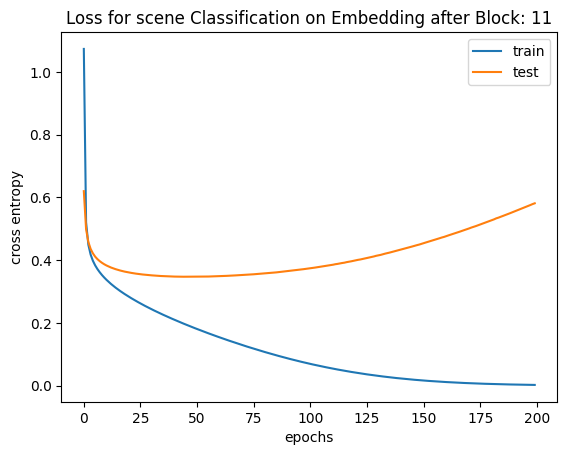

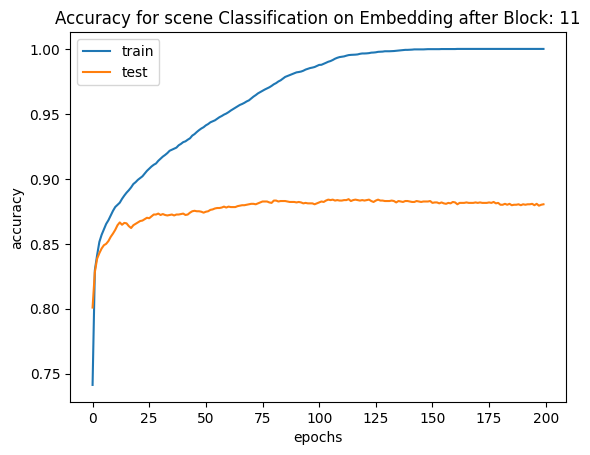

In [172]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [173]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [174]:
X_test=train_ready(test_data,col_name)

In [175]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

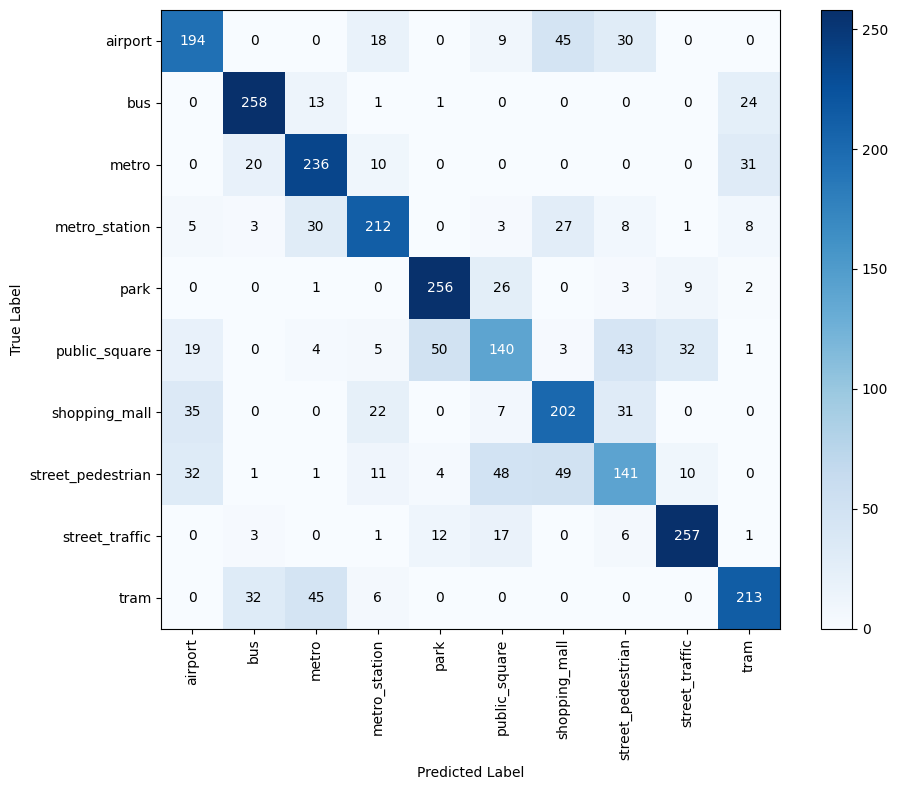

Accuracy: 0.7106


In [176]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# BLOCK-12


In [177]:
Block_number=12

In [178]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [179]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [180]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


11169
Per-class distribution for train data:
park: 1143
public_square: 1142
street_traffic: 1130
bus: 1120
airport: 1114
street_pedestrian: 1109
metro: 1106
metro_station: 1104
tram: 1103
shopping_mall: 1098


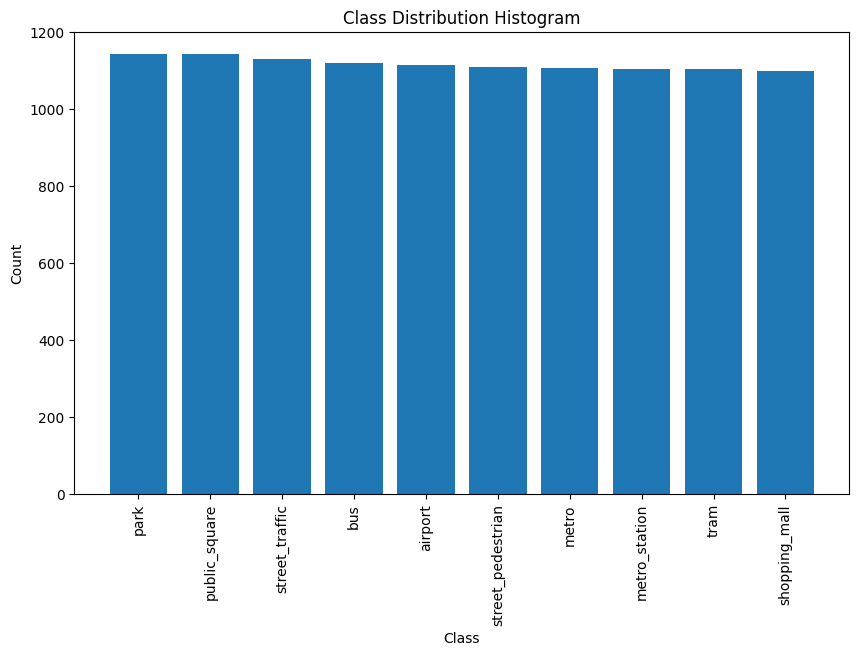

{'street_pedestrian': 1109,
 'metro': 1106,
 'park': 1143,
 'tram': 1103,
 'shopping_mall': 1098,
 'airport': 1114,
 'bus': 1120,
 'public_square': 1142,
 'metro_station': 1104,
 'street_traffic': 1130}

In [181]:
reverse=encoder.inverse_transform(y_train)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

2793
Per-class distribution for train data:
park: 286
public_square: 285
street_traffic: 283
bus: 280
airport: 279
street_pedestrian: 277
metro: 276
tram: 276
metro_station: 276
shopping_mall: 275


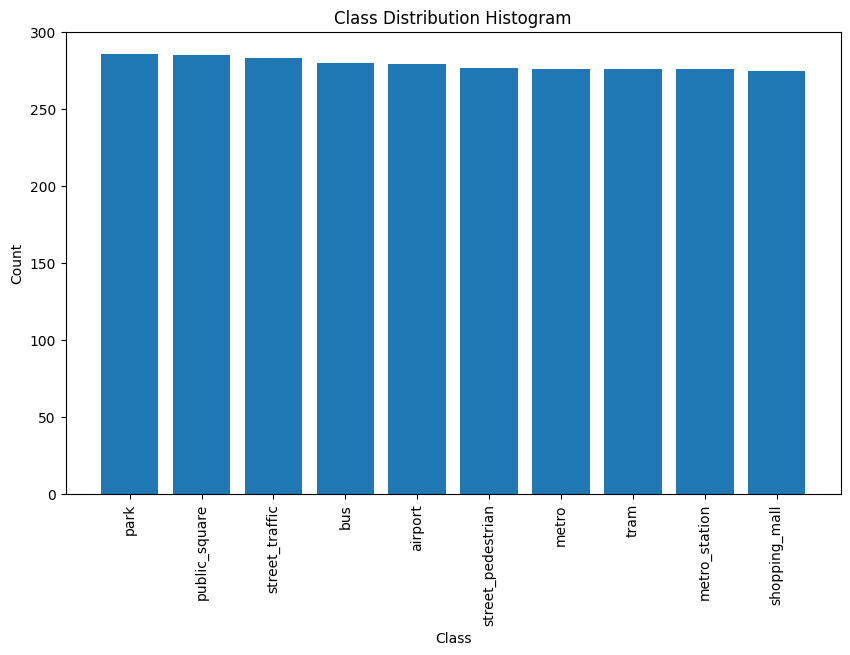

{'street_pedestrian': 277,
 'metro': 276,
 'park': 286,
 'tram': 276,
 'shopping_mall': 275,
 'airport': 279,
 'bus': 280,
 'public_square': 285,
 'metro_station': 276,
 'street_traffic': 283}

In [182]:
reverse=encoder.inverse_transform(y_val)
new_lst=[]
for i in range(len(list(reverse))):
    new_lst.append(reverse[i][0])
print(len(new_lst))
class_distribution(new_lst)

In [183]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [184]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [185]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 0:  10%|█         | 18/174 [00:00<00:00, 195.95batch/s, acc=0.672, loss=1.94]

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 351.52batch/s, acc=0.797, loss=0.625]


Epoch 0 validation: Cross-entropy=0.57, Accuracy=82.1%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 422.38batch/s, acc=0.844, loss=0.549]


Epoch 1 validation: Cross-entropy=0.46, Accuracy=83.6%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 427.94batch/s, acc=0.844, loss=0.535]


Epoch 2 validation: Cross-entropy=0.42, Accuracy=84.8%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 472.62batch/s, acc=0.828, loss=0.53] 


Epoch 3 validation: Cross-entropy=0.40, Accuracy=85.3%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 368.52batch/s, acc=0.844, loss=0.526]


Epoch 4 validation: Cross-entropy=0.39, Accuracy=85.9%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 416.67batch/s, acc=0.844, loss=0.522]


Epoch 5 validation: Cross-entropy=0.38, Accuracy=86.2%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 477.29batch/s, acc=0.844, loss=0.517]


Epoch 6 validation: Cross-entropy=0.38, Accuracy=86.2%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 420.17batch/s, acc=0.844, loss=0.512]


Epoch 7 validation: Cross-entropy=0.37, Accuracy=86.3%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 424.01batch/s, acc=0.844, loss=0.507]


Epoch 8 validation: Cross-entropy=0.37, Accuracy=86.4%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 421.28batch/s, acc=0.844, loss=0.501]


Epoch 9 validation: Cross-entropy=0.36, Accuracy=86.5%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 413.85batch/s, acc=0.844, loss=0.495]


Epoch 10 validation: Cross-entropy=0.36, Accuracy=86.6%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 414.48batch/s, acc=0.844, loss=0.489]


Epoch 11 validation: Cross-entropy=0.36, Accuracy=86.7%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 480.37batch/s, acc=0.844, loss=0.483]


Epoch 12 validation: Cross-entropy=0.36, Accuracy=86.9%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 420.11batch/s, acc=0.844, loss=0.477]


Epoch 13 validation: Cross-entropy=0.35, Accuracy=86.9%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 417.29batch/s, acc=0.844, loss=0.471]


Epoch 14 validation: Cross-entropy=0.35, Accuracy=87.0%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 416.93batch/s, acc=0.859, loss=0.464]


Epoch 15 validation: Cross-entropy=0.35, Accuracy=87.0%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 418.89batch/s, acc=0.859, loss=0.458]


Epoch 16 validation: Cross-entropy=0.35, Accuracy=87.0%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 415.87batch/s, acc=0.859, loss=0.452]


Epoch 17 validation: Cross-entropy=0.35, Accuracy=87.2%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 457.09batch/s, acc=0.859, loss=0.445]


Epoch 18 validation: Cross-entropy=0.35, Accuracy=87.3%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 432.65batch/s, acc=0.859, loss=0.439]


Epoch 19 validation: Cross-entropy=0.35, Accuracy=87.2%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 357.25batch/s, acc=0.859, loss=0.433]


Epoch 20 validation: Cross-entropy=0.35, Accuracy=87.2%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 418.17batch/s, acc=0.859, loss=0.426]


Epoch 21 validation: Cross-entropy=0.34, Accuracy=87.4%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 470.08batch/s, acc=0.859, loss=0.42] 


Epoch 22 validation: Cross-entropy=0.34, Accuracy=87.4%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 420.64batch/s, acc=0.859, loss=0.413]


Epoch 23 validation: Cross-entropy=0.34, Accuracy=87.4%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 419.06batch/s, acc=0.859, loss=0.407]


Epoch 24 validation: Cross-entropy=0.34, Accuracy=87.4%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 398.33batch/s, acc=0.859, loss=0.4]  


Epoch 25 validation: Cross-entropy=0.34, Accuracy=87.5%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 423.37batch/s, acc=0.859, loss=0.394]


Epoch 26 validation: Cross-entropy=0.34, Accuracy=87.5%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 426.55batch/s, acc=0.859, loss=0.388]


Epoch 27 validation: Cross-entropy=0.34, Accuracy=87.6%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 428.14batch/s, acc=0.859, loss=0.381]


Epoch 28 validation: Cross-entropy=0.34, Accuracy=87.5%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 481.93batch/s, acc=0.859, loss=0.375]


Epoch 29 validation: Cross-entropy=0.34, Accuracy=87.5%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 364.45batch/s, acc=0.875, loss=0.369]


Epoch 30 validation: Cross-entropy=0.34, Accuracy=87.5%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 420.51batch/s, acc=0.875, loss=0.363]


Epoch 31 validation: Cross-entropy=0.34, Accuracy=87.4%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 475.19batch/s, acc=0.875, loss=0.356] 


Epoch 32 validation: Cross-entropy=0.34, Accuracy=87.5%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 423.05batch/s, acc=0.875, loss=0.35] 


Epoch 33 validation: Cross-entropy=0.34, Accuracy=87.6%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 420.71batch/s, acc=0.875, loss=0.344] 


Epoch 34 validation: Cross-entropy=0.34, Accuracy=87.6%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 415.07batch/s, acc=0.875, loss=0.338] 


Epoch 35 validation: Cross-entropy=0.34, Accuracy=87.6%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 422.59batch/s, acc=0.875, loss=0.332] 


Epoch 36 validation: Cross-entropy=0.34, Accuracy=87.7%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 421.07batch/s, acc=0.875, loss=0.326] 


Epoch 37 validation: Cross-entropy=0.34, Accuracy=87.7%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 419.39batch/s, acc=0.875, loss=0.32]  


Epoch 38 validation: Cross-entropy=0.34, Accuracy=87.7%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 462.09batch/s, acc=0.875, loss=0.314] 


Epoch 39 validation: Cross-entropy=0.34, Accuracy=87.7%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 393.37batch/s, acc=0.875, loss=0.308] 


Epoch 40 validation: Cross-entropy=0.34, Accuracy=87.8%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 422.86batch/s, acc=0.875, loss=0.302] 


Epoch 41 validation: Cross-entropy=0.34, Accuracy=87.8%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 414.30batch/s, acc=0.875, loss=0.296] 


Epoch 42 validation: Cross-entropy=0.34, Accuracy=87.8%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 481.54batch/s, acc=0.875, loss=0.29]  


Epoch 43 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 425.69batch/s, acc=0.891, loss=0.284] 


Epoch 44 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 370.10batch/s, acc=0.891, loss=0.279] 


Epoch 45 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 482.20batch/s, acc=0.891, loss=0.273] 


Epoch 46 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 426.58batch/s, acc=0.891, loss=0.267] 


Epoch 47 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 426.55batch/s, acc=0.891, loss=0.262] 


Epoch 48 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 484.83batch/s, acc=0.891, loss=0.256] 


Epoch 49 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 428.52batch/s, acc=0.891, loss=0.25]  


Epoch 50 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 372.69batch/s, acc=0.891, loss=0.245] 


Epoch 51 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 464.87batch/s, acc=0.891, loss=0.239] 


Epoch 52 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 426.45batch/s, acc=0.891, loss=0.234] 


Epoch 53 validation: Cross-entropy=0.34, Accuracy=87.9%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 422.55batch/s, acc=0.891, loss=0.229] 


Epoch 54 validation: Cross-entropy=0.34, Accuracy=88.0%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 485.64batch/s, acc=0.891, loss=0.224] 


Epoch 55 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 374.32batch/s, acc=0.906, loss=0.218] 


Epoch 56 validation: Cross-entropy=0.35, Accuracy=88.0%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 425.55batch/s, acc=0.906, loss=0.213] 


Epoch 57 validation: Cross-entropy=0.35, Accuracy=88.2%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 423.73batch/s, acc=0.922, loss=0.207] 


Epoch 58 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 480.27batch/s, acc=0.922, loss=0.202] 


Epoch 59 validation: Cross-entropy=0.35, Accuracy=88.2%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 426.29batch/s, acc=0.922, loss=0.197] 


Epoch 60 validation: Cross-entropy=0.35, Accuracy=88.2%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 373.48batch/s, acc=0.922, loss=0.192] 


Epoch 61 validation: Cross-entropy=0.35, Accuracy=88.2%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 483.87batch/s, acc=0.922, loss=0.187] 


Epoch 62 validation: Cross-entropy=0.35, Accuracy=88.2%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 421.14batch/s, acc=0.922, loss=0.182] 


Epoch 63 validation: Cross-entropy=0.35, Accuracy=88.3%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 421.69batch/s, acc=0.922, loss=0.178] 


Epoch 64 validation: Cross-entropy=0.35, Accuracy=88.3%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 484.26batch/s, acc=0.922, loss=0.173] 


Epoch 65 validation: Cross-entropy=0.35, Accuracy=88.3%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 372.40batch/s, acc=0.922, loss=0.168] 


Epoch 66 validation: Cross-entropy=0.35, Accuracy=88.3%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 425.43batch/s, acc=0.938, loss=0.163] 


Epoch 67 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 420.79batch/s, acc=0.938, loss=0.158] 


Epoch 68 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 485.55batch/s, acc=0.938, loss=0.154] 


Epoch 69 validation: Cross-entropy=0.35, Accuracy=88.1%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 427.72batch/s, acc=0.938, loss=0.149] 


Epoch 70 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 367.20batch/s, acc=0.953, loss=0.144] 


Epoch 71 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 482.93batch/s, acc=0.953, loss=0.14]  


Epoch 72 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 425.09batch/s, acc=0.953, loss=0.135] 


Epoch 73 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 424.05batch/s, acc=0.953, loss=0.131] 


Epoch 74 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 427.99batch/s, acc=0.953, loss=0.126] 


Epoch 75 validation: Cross-entropy=0.36, Accuracy=88.0%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 483.94batch/s, acc=0.953, loss=0.123] 


Epoch 76 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 366.56batch/s, acc=0.953, loss=0.119] 


Epoch 77 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 426.34batch/s, acc=0.953, loss=0.115] 


Epoch 78 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 487.23batch/s, acc=0.953, loss=0.111] 


Epoch 79 validation: Cross-entropy=0.36, Accuracy=88.1%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 427.09batch/s, acc=0.953, loss=0.108] 


Epoch 80 validation: Cross-entropy=0.37, Accuracy=88.1%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 425.57batch/s, acc=0.953, loss=0.104] 


Epoch 81 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 404.85batch/s, acc=0.969, loss=0.1]   


Epoch 82 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 426.50batch/s, acc=0.969, loss=0.0975]


Epoch 83 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 425.09batch/s, acc=0.969, loss=0.0944]


Epoch 84 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 445.72batch/s, acc=0.984, loss=0.0909]


Epoch 85 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 472.93batch/s, acc=0.984, loss=0.0882]


Epoch 86 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 366.57batch/s, acc=0.984, loss=0.085] 


Epoch 87 validation: Cross-entropy=0.37, Accuracy=88.0%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 424.14batch/s, acc=0.984, loss=0.0821]


Epoch 88 validation: Cross-entropy=0.38, Accuracy=88.0%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 484.33batch/s, acc=0.984, loss=0.0795]


Epoch 89 validation: Cross-entropy=0.38, Accuracy=87.9%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 424.62batch/s, acc=0.984, loss=0.0768]


Epoch 90 validation: Cross-entropy=0.38, Accuracy=87.8%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 427.85batch/s, acc=0.984, loss=0.0746]


Epoch 91 validation: Cross-entropy=0.38, Accuracy=87.8%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 416.26batch/s, acc=0.984, loss=0.0718]


Epoch 92 validation: Cross-entropy=0.38, Accuracy=87.8%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 418.63batch/s, acc=0.984, loss=0.07]  


Epoch 93 validation: Cross-entropy=0.38, Accuracy=87.8%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 423.82batch/s, acc=0.984, loss=0.0673]


Epoch 94 validation: Cross-entropy=0.38, Accuracy=87.7%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 412.50batch/s, acc=0.984, loss=0.0647]


Epoch 95 validation: Cross-entropy=0.39, Accuracy=87.7%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 477.78batch/s, acc=0.984, loss=0.0628]


Epoch 96 validation: Cross-entropy=0.39, Accuracy=87.8%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 372.56batch/s, acc=0.984, loss=0.0608]


Epoch 97 validation: Cross-entropy=0.39, Accuracy=87.7%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 413.27batch/s, acc=1, loss=0.0582]    


Epoch 98 validation: Cross-entropy=0.39, Accuracy=87.8%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 481.75batch/s, acc=1, loss=0.0565]    


Epoch 99 validation: Cross-entropy=0.39, Accuracy=87.8%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 423.03batch/s, acc=1, loss=0.0545]    


Epoch 100 validation: Cross-entropy=0.39, Accuracy=87.8%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 426.70batch/s, acc=1, loss=0.0531]    


Epoch 101 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 371.49batch/s, acc=1, loss=0.0511]    


Epoch 102 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 480.11batch/s, acc=1, loss=0.0495]    


Epoch 103 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 428.46batch/s, acc=1, loss=0.0478]    


Epoch 104 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 430.06batch/s, acc=1, loss=0.046]     


Epoch 105 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 469.96batch/s, acc=1, loss=0.0444]    


Epoch 106 validation: Cross-entropy=0.40, Accuracy=87.8%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 425.54batch/s, acc=1, loss=0.0429]    


Epoch 107 validation: Cross-entropy=0.41, Accuracy=87.9%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 375.36batch/s, acc=1, loss=0.0415]    


Epoch 108 validation: Cross-entropy=0.41, Accuracy=87.8%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 486.43batch/s, acc=1, loss=0.0398]    


Epoch 109 validation: Cross-entropy=0.41, Accuracy=87.8%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 413.57batch/s, acc=1, loss=0.0386]    


Epoch 110 validation: Cross-entropy=0.41, Accuracy=87.8%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 423.82batch/s, acc=1, loss=0.0371]    


Epoch 111 validation: Cross-entropy=0.41, Accuracy=87.8%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 424.52batch/s, acc=1, loss=0.0362]    


Epoch 112 validation: Cross-entropy=0.42, Accuracy=87.8%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 419.52batch/s, acc=1, loss=0.0348]    


Epoch 113 validation: Cross-entropy=0.42, Accuracy=87.9%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 415.38batch/s, acc=1, loss=0.0335]    


Epoch 114 validation: Cross-entropy=0.42, Accuracy=87.8%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 417.53batch/s, acc=1, loss=0.0326]    


Epoch 115 validation: Cross-entropy=0.42, Accuracy=87.9%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 480.73batch/s, acc=1, loss=0.0315]    


Epoch 116 validation: Cross-entropy=0.43, Accuracy=87.8%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 423.65batch/s, acc=1, loss=0.0303]    


Epoch 117 validation: Cross-entropy=0.43, Accuracy=87.9%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 369.25batch/s, acc=1, loss=0.0291]    


Epoch 118 validation: Cross-entropy=0.43, Accuracy=87.9%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 431.66batch/s, acc=1, loss=0.0283]    


Epoch 119 validation: Cross-entropy=0.43, Accuracy=87.9%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 467.82batch/s, acc=1, loss=0.0272]    


Epoch 120 validation: Cross-entropy=0.43, Accuracy=87.8%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 421.37batch/s, acc=1, loss=0.0263]    


Epoch 121 validation: Cross-entropy=0.44, Accuracy=87.9%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 412.10batch/s, acc=1, loss=0.0253]    


Epoch 122 validation: Cross-entropy=0.44, Accuracy=87.9%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 399.90batch/s, acc=1, loss=0.0245]    


Epoch 123 validation: Cross-entropy=0.44, Accuracy=87.8%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 395.56batch/s, acc=1, loss=0.0236]   


Epoch 124 validation: Cross-entropy=0.44, Accuracy=87.8%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 366.65batch/s, acc=1, loss=0.0225]    


Epoch 125 validation: Cross-entropy=0.45, Accuracy=87.9%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 286.79batch/s, acc=1, loss=0.0219]    


Epoch 126 validation: Cross-entropy=0.45, Accuracy=87.9%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 330.01batch/s, acc=1, loss=0.0211] 


Epoch 127 validation: Cross-entropy=0.45, Accuracy=87.9%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 399.76batch/s, acc=1, loss=0.0202] 


Epoch 128 validation: Cross-entropy=0.45, Accuracy=87.9%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 326.86batch/s, acc=1, loss=0.0194] 


Epoch 129 validation: Cross-entropy=0.45, Accuracy=87.9%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 289.65batch/s, acc=1, loss=0.0188] 


Epoch 130 validation: Cross-entropy=0.46, Accuracy=87.9%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 384.81batch/s, acc=1, loss=0.0179] 


Epoch 131 validation: Cross-entropy=0.46, Accuracy=87.8%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 328.41batch/s, acc=1, loss=0.0174] 


Epoch 132 validation: Cross-entropy=0.46, Accuracy=87.8%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 344.88batch/s, acc=1, loss=0.0167] 


Epoch 133 validation: Cross-entropy=0.47, Accuracy=87.8%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 357.81batch/s, acc=1, loss=0.016]  


Epoch 134 validation: Cross-entropy=0.47, Accuracy=87.8%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 309.32batch/s, acc=1, loss=0.0155] 


Epoch 135 validation: Cross-entropy=0.47, Accuracy=87.8%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 355.43batch/s, acc=1, loss=0.0149] 


Epoch 136 validation: Cross-entropy=0.47, Accuracy=87.9%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 455.15batch/s, acc=1, loss=0.0142] 


Epoch 137 validation: Cross-entropy=0.48, Accuracy=87.8%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 413.51batch/s, acc=1, loss=0.0137] 


Epoch 138 validation: Cross-entropy=0.48, Accuracy=87.9%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 415.98batch/s, acc=1, loss=0.0132] 


Epoch 139 validation: Cross-entropy=0.48, Accuracy=87.8%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 423.61batch/s, acc=1, loss=0.0127] 


Epoch 140 validation: Cross-entropy=0.48, Accuracy=87.8%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 416.51batch/s, acc=1, loss=0.0122] 


Epoch 141 validation: Cross-entropy=0.49, Accuracy=87.9%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 422.02batch/s, acc=1, loss=0.0118] 


Epoch 142 validation: Cross-entropy=0.49, Accuracy=87.8%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 417.37batch/s, acc=1, loss=0.0111] 


Epoch 143 validation: Cross-entropy=0.49, Accuracy=87.9%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 480.10batch/s, acc=1, loss=0.0108] 


Epoch 144 validation: Cross-entropy=0.49, Accuracy=87.9%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 360.79batch/s, acc=1, loss=0.0103] 


Epoch 145 validation: Cross-entropy=0.50, Accuracy=87.8%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 418.67batch/s, acc=1, loss=0.00995]


Epoch 146 validation: Cross-entropy=0.50, Accuracy=87.8%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 480.24batch/s, acc=1, loss=0.00958]


Epoch 147 validation: Cross-entropy=0.50, Accuracy=87.8%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 419.55batch/s, acc=1, loss=0.0092] 


Epoch 148 validation: Cross-entropy=0.51, Accuracy=87.8%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 418.37batch/s, acc=1, loss=0.00874]


Epoch 149 validation: Cross-entropy=0.51, Accuracy=87.8%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 399.08batch/s, acc=1, loss=0.00843]


Epoch 150 validation: Cross-entropy=0.51, Accuracy=87.8%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 438.52batch/s, acc=1, loss=0.00808]


Epoch 151 validation: Cross-entropy=0.52, Accuracy=87.8%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 420.87batch/s, acc=1, loss=0.00774]


Epoch 152 validation: Cross-entropy=0.52, Accuracy=87.8%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 421.87batch/s, acc=1, loss=0.00743]


Epoch 153 validation: Cross-entropy=0.52, Accuracy=87.8%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 423.47batch/s, acc=1, loss=0.00712]


Epoch 154 validation: Cross-entropy=0.52, Accuracy=87.8%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 404.50batch/s, acc=1, loss=0.00681]


Epoch 155 validation: Cross-entropy=0.53, Accuracy=87.8%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 418.81batch/s, acc=1, loss=0.00654]


Epoch 156 validation: Cross-entropy=0.53, Accuracy=87.8%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 444.73batch/s, acc=1, loss=0.00628]


Epoch 157 validation: Cross-entropy=0.53, Accuracy=87.7%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 444.62batch/s, acc=1, loss=0.00602]


Epoch 158 validation: Cross-entropy=0.54, Accuracy=87.7%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 416.93batch/s, acc=1, loss=0.00579]


Epoch 159 validation: Cross-entropy=0.54, Accuracy=87.7%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 362.24batch/s, acc=1, loss=0.00548]


Epoch 160 validation: Cross-entropy=0.54, Accuracy=87.6%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 477.68batch/s, acc=1, loss=0.00524]


Epoch 161 validation: Cross-entropy=0.55, Accuracy=87.7%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 425.64batch/s, acc=1, loss=0.00504]


Epoch 162 validation: Cross-entropy=0.55, Accuracy=87.7%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 424.15batch/s, acc=1, loss=0.00483]


Epoch 163 validation: Cross-entropy=0.55, Accuracy=87.8%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 463.42batch/s, acc=1, loss=0.00463]


Epoch 164 validation: Cross-entropy=0.56, Accuracy=87.7%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 354.56batch/s, acc=1, loss=0.00442]


Epoch 165 validation: Cross-entropy=0.56, Accuracy=87.8%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 419.97batch/s, acc=1, loss=0.00422]


Epoch 166 validation: Cross-entropy=0.56, Accuracy=87.8%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 473.83batch/s, acc=1, loss=0.00404]


Epoch 167 validation: Cross-entropy=0.57, Accuracy=87.8%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 425.38batch/s, acc=1, loss=0.00382]


Epoch 168 validation: Cross-entropy=0.57, Accuracy=87.8%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 417.29batch/s, acc=1, loss=0.00369]


Epoch 169 validation: Cross-entropy=0.57, Accuracy=87.8%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 421.16batch/s, acc=1, loss=0.00351]


Epoch 170 validation: Cross-entropy=0.58, Accuracy=87.8%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 413.72batch/s, acc=1, loss=0.00334]


Epoch 171 validation: Cross-entropy=0.58, Accuracy=87.8%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 424.45batch/s, acc=1, loss=0.00322]


Epoch 172 validation: Cross-entropy=0.58, Accuracy=87.8%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 452.59batch/s, acc=1, loss=0.00308]


Epoch 173 validation: Cross-entropy=0.58, Accuracy=87.8%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 453.77batch/s, acc=1, loss=0.00293]


Epoch 174 validation: Cross-entropy=0.59, Accuracy=87.7%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 425.21batch/s, acc=1, loss=0.00276] 


Epoch 175 validation: Cross-entropy=0.59, Accuracy=87.8%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 417.87batch/s, acc=1, loss=0.00266] 


Epoch 176 validation: Cross-entropy=0.60, Accuracy=87.8%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 420.96batch/s, acc=1, loss=0.00253] 


Epoch 177 validation: Cross-entropy=0.60, Accuracy=87.8%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 423.46batch/s, acc=1, loss=0.00241] 


Epoch 178 validation: Cross-entropy=0.60, Accuracy=87.7%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 419.29batch/s, acc=1, loss=0.0023]  


Epoch 179 validation: Cross-entropy=0.61, Accuracy=87.7%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 462.94batch/s, acc=1, loss=0.00219] 


Epoch 180 validation: Cross-entropy=0.61, Accuracy=87.6%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 364.26batch/s, acc=1, loss=0.0021]  


Epoch 181 validation: Cross-entropy=0.61, Accuracy=87.6%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 418.18batch/s, acc=1, loss=0.002]   


Epoch 182 validation: Cross-entropy=0.62, Accuracy=87.6%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 483.48batch/s, acc=1, loss=0.00191] 


Epoch 183 validation: Cross-entropy=0.62, Accuracy=87.6%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 418.67batch/s, acc=1, loss=0.00183] 


Epoch 184 validation: Cross-entropy=0.62, Accuracy=87.6%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 422.02batch/s, acc=1, loss=0.00173] 


Epoch 185 validation: Cross-entropy=0.63, Accuracy=87.6%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 385.54batch/s, acc=1, loss=0.00164] 


Epoch 186 validation: Cross-entropy=0.63, Accuracy=87.6%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 456.54batch/s, acc=1, loss=0.00158] 


Epoch 187 validation: Cross-entropy=0.63, Accuracy=87.6%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 422.23batch/s, acc=1, loss=0.00152] 


Epoch 188 validation: Cross-entropy=0.64, Accuracy=87.6%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 418.84batch/s, acc=1, loss=0.00142] 


Epoch 189 validation: Cross-entropy=0.64, Accuracy=87.6%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 482.09batch/s, acc=1, loss=0.00138] 


Epoch 190 validation: Cross-entropy=0.64, Accuracy=87.6%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 368.72batch/s, acc=1, loss=0.0013]  


Epoch 191 validation: Cross-entropy=0.65, Accuracy=87.6%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 419.17batch/s, acc=1, loss=0.00123] 


Epoch 192 validation: Cross-entropy=0.65, Accuracy=87.6%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 434.12batch/s, acc=1, loss=0.00119] 


Epoch 193 validation: Cross-entropy=0.66, Accuracy=87.7%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 475.11batch/s, acc=1, loss=0.00113] 


Epoch 194 validation: Cross-entropy=0.66, Accuracy=87.6%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 420.19batch/s, acc=1, loss=0.00108] 


Epoch 195 validation: Cross-entropy=0.66, Accuracy=87.6%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 419.68batch/s, acc=1, loss=0.00103] 


Epoch 196 validation: Cross-entropy=0.67, Accuracy=87.7%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 419.51batch/s, acc=1, loss=0.000969]


Epoch 197 validation: Cross-entropy=0.67, Accuracy=87.8%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 424.05batch/s, acc=1, loss=0.000917]


Epoch 198 validation: Cross-entropy=0.67, Accuracy=87.8%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 426.21batch/s, acc=1, loss=0.000873]


Epoch 199 validation: Cross-entropy=0.68, Accuracy=87.7%


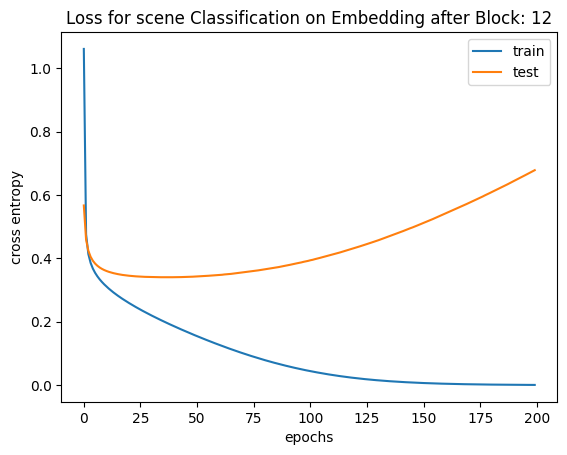

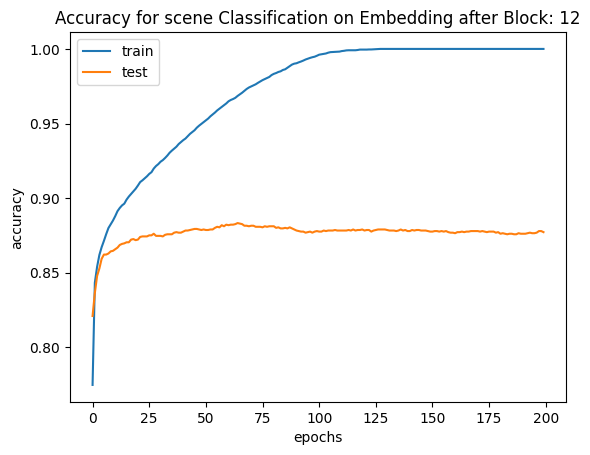

In [186]:
import tqdm
import copy
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# # Move model to device (if applicable)
# model.to(device)

best_loss =  np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)  # Move test data to device
        y_val_batch=y_val_tensor.to(device)
        y_pred = model(X_test_batch).to(device)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce <= best_loss  and acc >  best_acc:
        best_loss=ce
        best_weights = copy.deepcopy(model.state_dict())
        best_acc = acc

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

model.load_state_dict(best_weights)
# model.save("scene_classification.pth")

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [187]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
torch.save(model, f'scene_maam_audioset_without_opl/small_model_{run_mode}_{Block_number}_opl.pth')

In [188]:
X_test=train_ready(test_data,col_name)

In [189]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

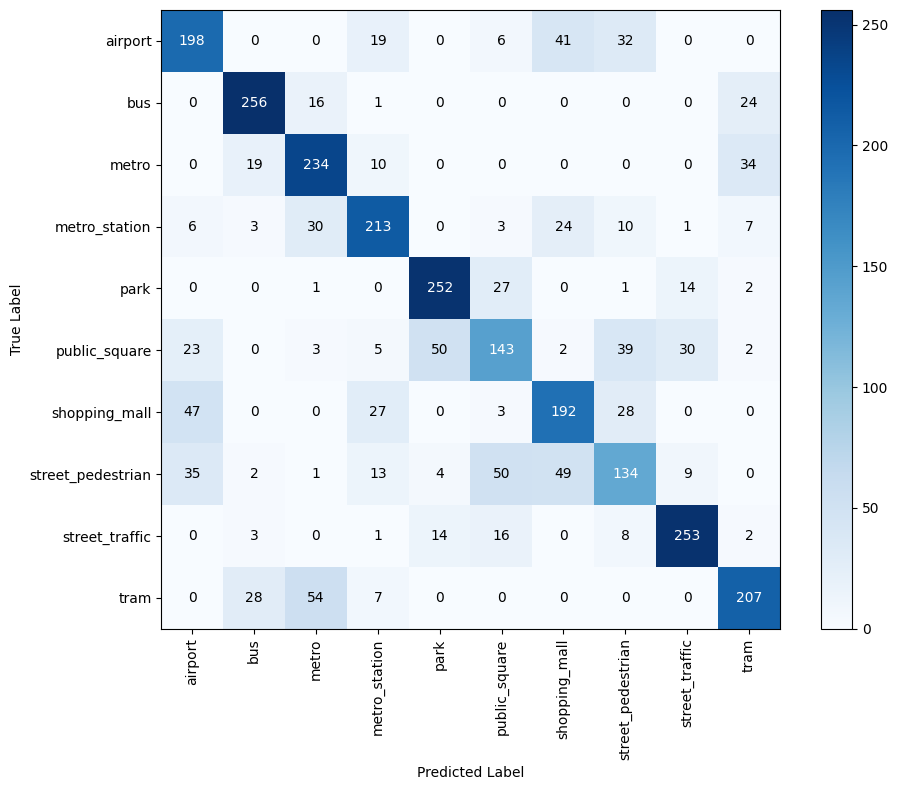

Accuracy: 0.7015


In [190]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

In [191]:
# df.to_csv(fr'{run_mode}_predictions.csv')

In [192]:
acc_list

[0.2429245283018868,
 0.46529649595687333,
 0.5279649595687331,
 0.5774932614555256,
 0.6340970350404312,
 0.6583557951482479,
 0.6735175202156334,
 0.6846361185983828,
 0.692722371967655,
 0.7045148247978437,
 0.7105795148247979,
 0.7014824797843666]

# Accuracy plot per block 

In [193]:
# # acc_list=[0.2065,0.3807,0.4660,0.5270,0.5799,0.6112,0.6449,0.6445,0.6597,0.6584,0.6580,0.6614]
# acc_list=[0.2392,0.4579,0.5273,0.5630,0.6287,0.6513,0.6752,0.6863,0.6883,0.7042,0.7032,0.7018]

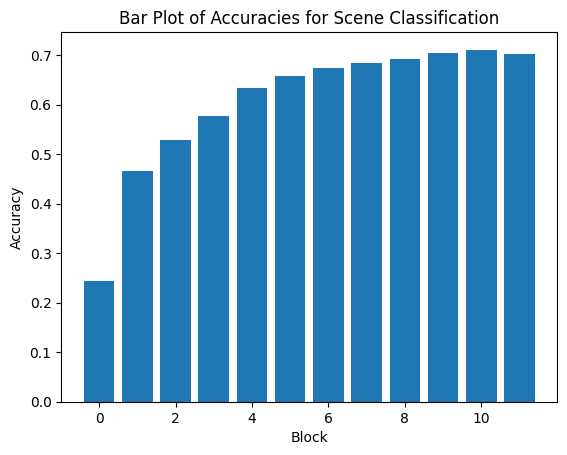

In [194]:
import matplotlib.pyplot as plt

# Example list of numbers
numbers = acc_list

# Create the plot
plt.bar(range(len(numbers)), numbers)

# Add labels and title
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Accuracies for Scene Classification')

# Display the plot
plt.show()
